In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [37]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def count_outliers(data, col_name):
    # Calculate Q1, Q3 and IQR
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers = data[(data[col_name] < (Q1 - 1.5 * IQR)) | (data[col_name] > (Q3 + 1.5 * IQR))]
    num_outliers = len(outliers)
    return num_outliers

def check_distribution_match(train_data, test_data, col_name):

    train_feature = train_data[col_name]
    test_feature = test_data[col_name]

    plt.figure(figsize=(20, 10))

    # Visualizing distributions with histograms
    plt.subplot(2, 3, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(2, 3, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')

    # Box plot comparison
    plt.subplot(2, 3, 3)
    sns.boxplot(data=[train_feature, test_feature], palette=["blue", "red"])
    plt.xticks([0, 1], ['Train', 'Test'])
    plt.title('Box Plot Comparison')

    # Violin plot comparison
    plt.subplot(2, 3, 4)
    sns.violinplot(data=[train_feature, test_feature], palette=["blue", "red"])
    plt.xticks([0, 1], ['Train', 'Test'])
    plt.title('Violin Plot Comparison')

    # Q-Q plot comparison for train data
    plt.subplot(2, 3, 5)
    stats.probplot(train_feature, dist="norm", plot=plt)
    plt.title('Q-Q Plot for Train Data')

    # Q-Q plot comparison for test data
    plt.subplot(2, 3, 6)
    stats.probplot(test_feature, dist="norm", plot=plt)
    plt.title('Q-Q Plot for Test Data')

    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print("======================================= " + "Train-Test Statistics" + " =======================================")
    print(f"\nKolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    print("\nNumber of outliers in Train: ", count_outliers(train_data, col_name))
    print("\nNumber of outliers in Test: ", count_outliers(test_data, col_name))

    skewness_train = train_data[col_name].skew()
    kurtosis_train = train_data[col_name].kurtosis()
    skewness_test = test_data[col_name].skew()
    kurtosis_test = test_data[col_name].kurtosis()

    print("\nSkewness of Train: ", skewness_train, "\nKurtosis of Train: ", kurtosis_train)
    print("\nSkewness of Test: ", skewness_test, "\nKurtosis of Test: ", kurtosis_test)

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True) // (1 / N) # divide feature values for all games in N equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1 - x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%': 'mean', 'team2_win%': 'mean', 'count': 'sum', f'{feature}_min': 'min',\
                                             f'{feature}_max': 'max'}).reset_index()
    N = min(N, df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    counts = df_g['count'].values.tolist()
    ind = np.arange(N)
    
    # plotting starts
    plt.figure(figsize=(10, 5))
    bars = plt.bar(ind, blue_bar, label='Team 1 win%')
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle='--')
    xlabel = re.sub('team_', 'ratio_', feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins')
    plt.ylabel('Win %')
    plt.title(f'RnP - {feature} vs win')
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'], 2)) + ' - ' + str(round(x[f'{feature}_max'], 2)), axis=1)
    plt.xticks(ind, df_g['xticks'])
    plt.ylim([ylim_lb, ylim_ub])
    plt.legend(loc='best')
    
    # Add counts on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

    x2, x1 = blue_bar[-1], blue_bar[0]
    slope = x2 / x1
    if slope < 1:
        slope = 1 / slope
        x1, x2 = x2, x1
    print('slope:', round(x2, 2), '/', round(x1, 2), '= ', round(slope, 2))
    plt.show()

    correlation = df['winner_01'].corr(df[feature])
    # print(f"Correlation between {feature} and winner_01 is: {correlation}")

    # Train a RandomForestClassifier to get feature importances
    X = df[['team_count_50runs_last15',feature]]
    y = df['winner_01']
    model = RandomForestClassifier()
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_
    # print("Feature importances wrt team_count_50runs_last15 :", importances[1])
    return correlation, importances[1]

In [98]:
def analyse_feature(X_12, feature):
    correlation, importance = createRnP(X_12, feature)
    check_distribution_match(train_data, test_data, feature)


    print("======================================= " + "Model Performance" + " =======================================")
    print(f"\nCorrelation between {feature} and winner_01 is: {correlation}")
    print(f"\nFeature importance wrt team_count_50runs_last15 : {importance}")

## Features

Feature 1

In [8]:
#new feature 1 bowler's performance of teams in recent mathes
def team_bowler_performance_recent(bowler_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count']) * 5 + recent_matches['dots']*1.5+(recent_matches['maiden']) * 1.5 -(recent_matches['Fours'] * 1) - recent_matches['Sixes']*1.5 - recent_matches['wides'] - recent_matches['noballs']                          
                           
                            
                             
            total_impact_score += player_impact.sum()

    return total_impact_score

In [9]:
train_data['team1_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
train_data = add_ratio_column(train_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

test_data['team1_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
test_data = add_ratio_column(test_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

slope: 0.61 / 0.34 =  1.8


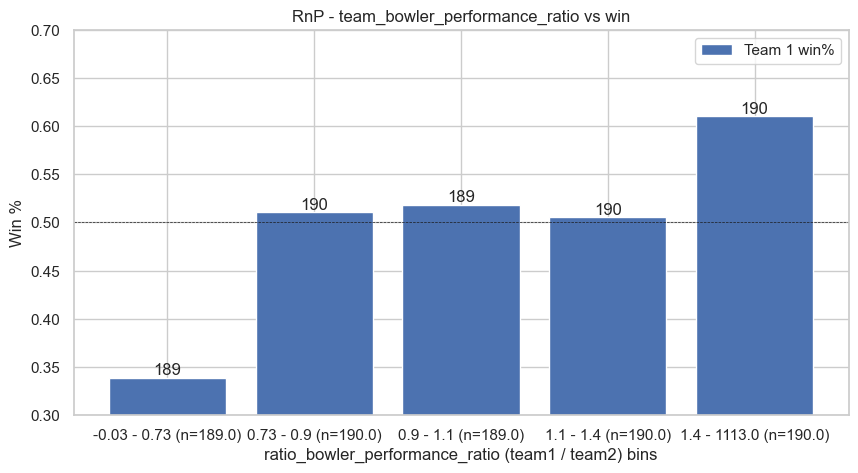

Correlation between team_bowler_performance_ratio and winner_01 is: -0.05037630480130837
Feature importances wrt team_count_50runs_last15 : 0.6371200364819275


In [31]:
createRnP(train_data, 'team_bowler_performance_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


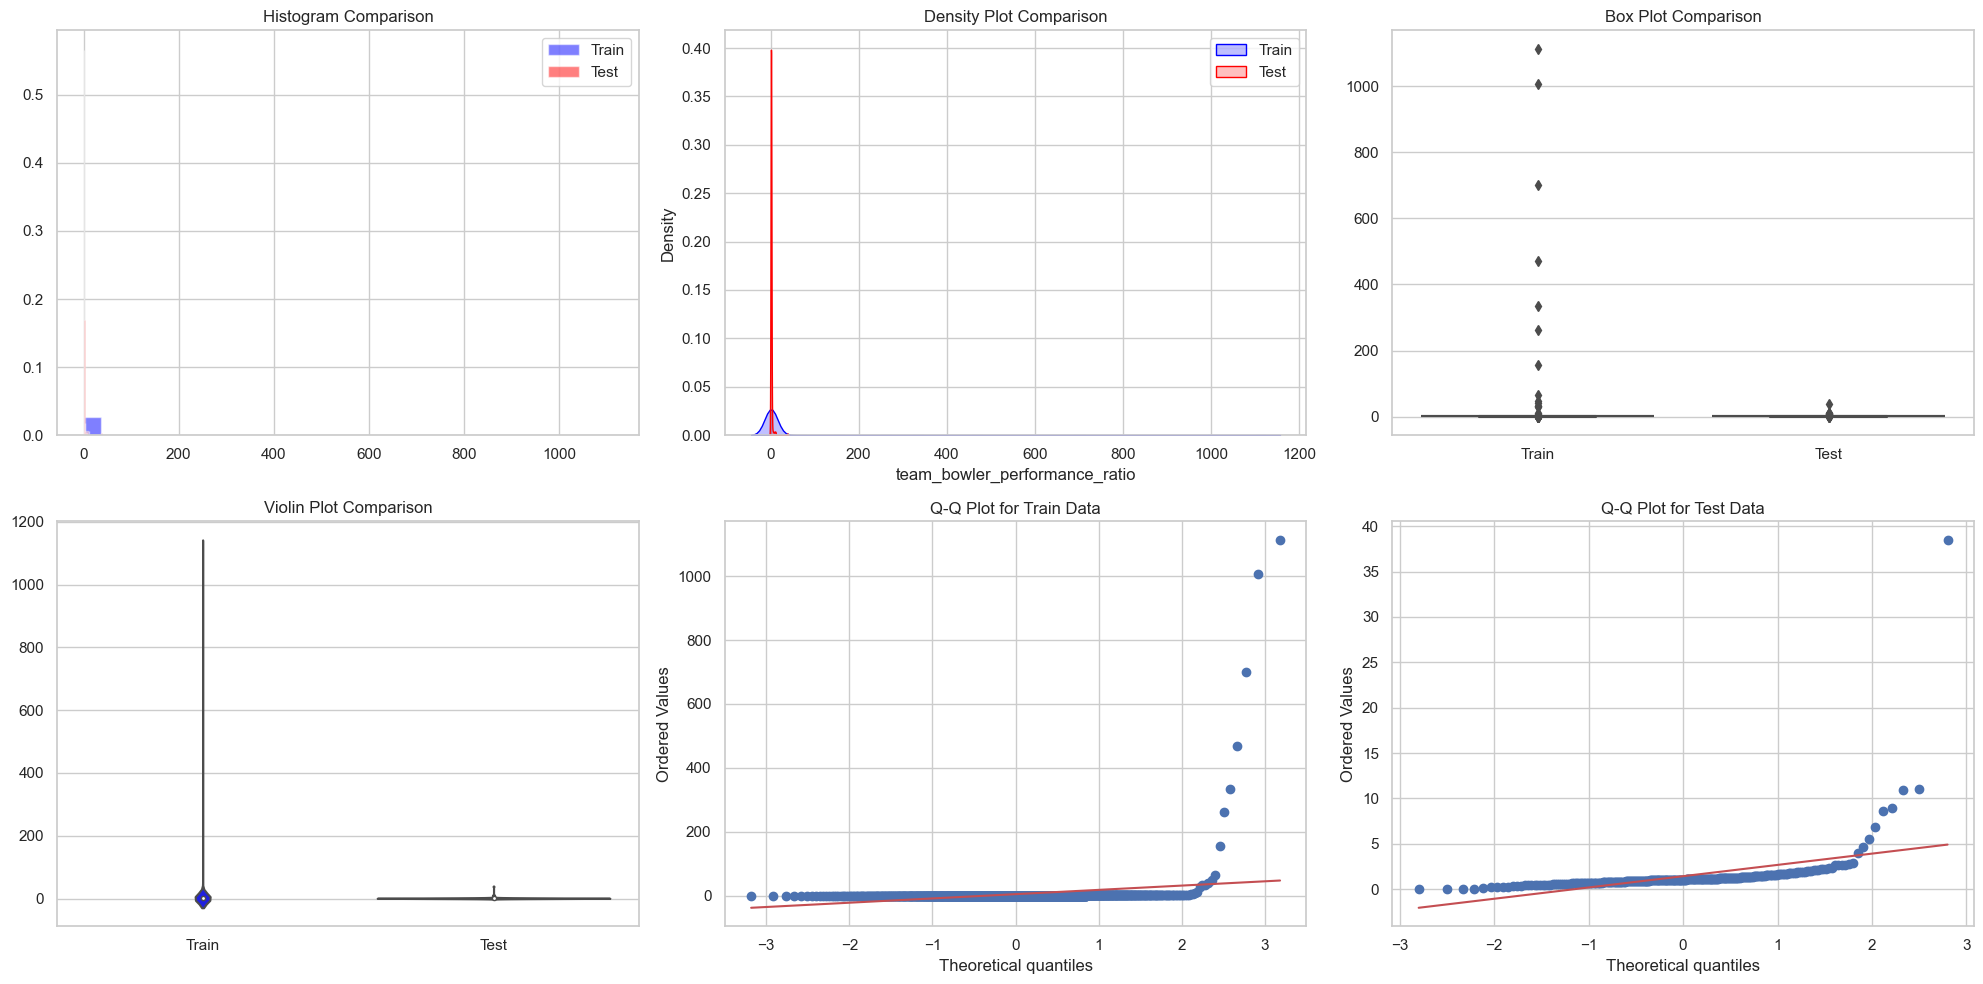

======================================= Train-Test Statistics =======================================

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Number of outliers in Train:  87

Number of outliers in Test:  26

Skewness of Train:  15.727021194757878 
Kurtosis of Train:  266.07928405443556

Skewness of Test:  11.446400247125148 
Kurtosis of Test:  156.22109804985087

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.618912    1.420354
std      57.700298    2.597474
min      -0.028103    0.000000
25%       0.790858    0.826576
50%       0.981911    1.051232
75%       1.284090    1.334909
max    1113.000000   38.500000


In [126]:
check_distribution_match(train_data, test_data, 'team_bowler_performance_ratio')

slope: 0.61 / 0.34 =  1.8


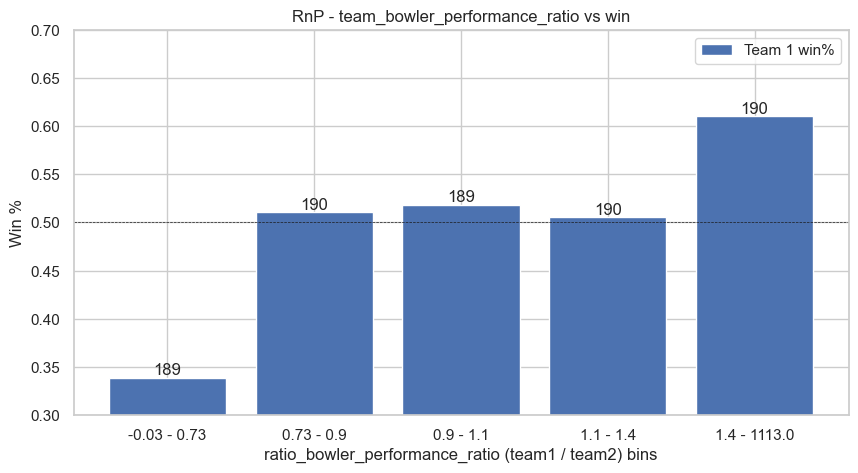

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


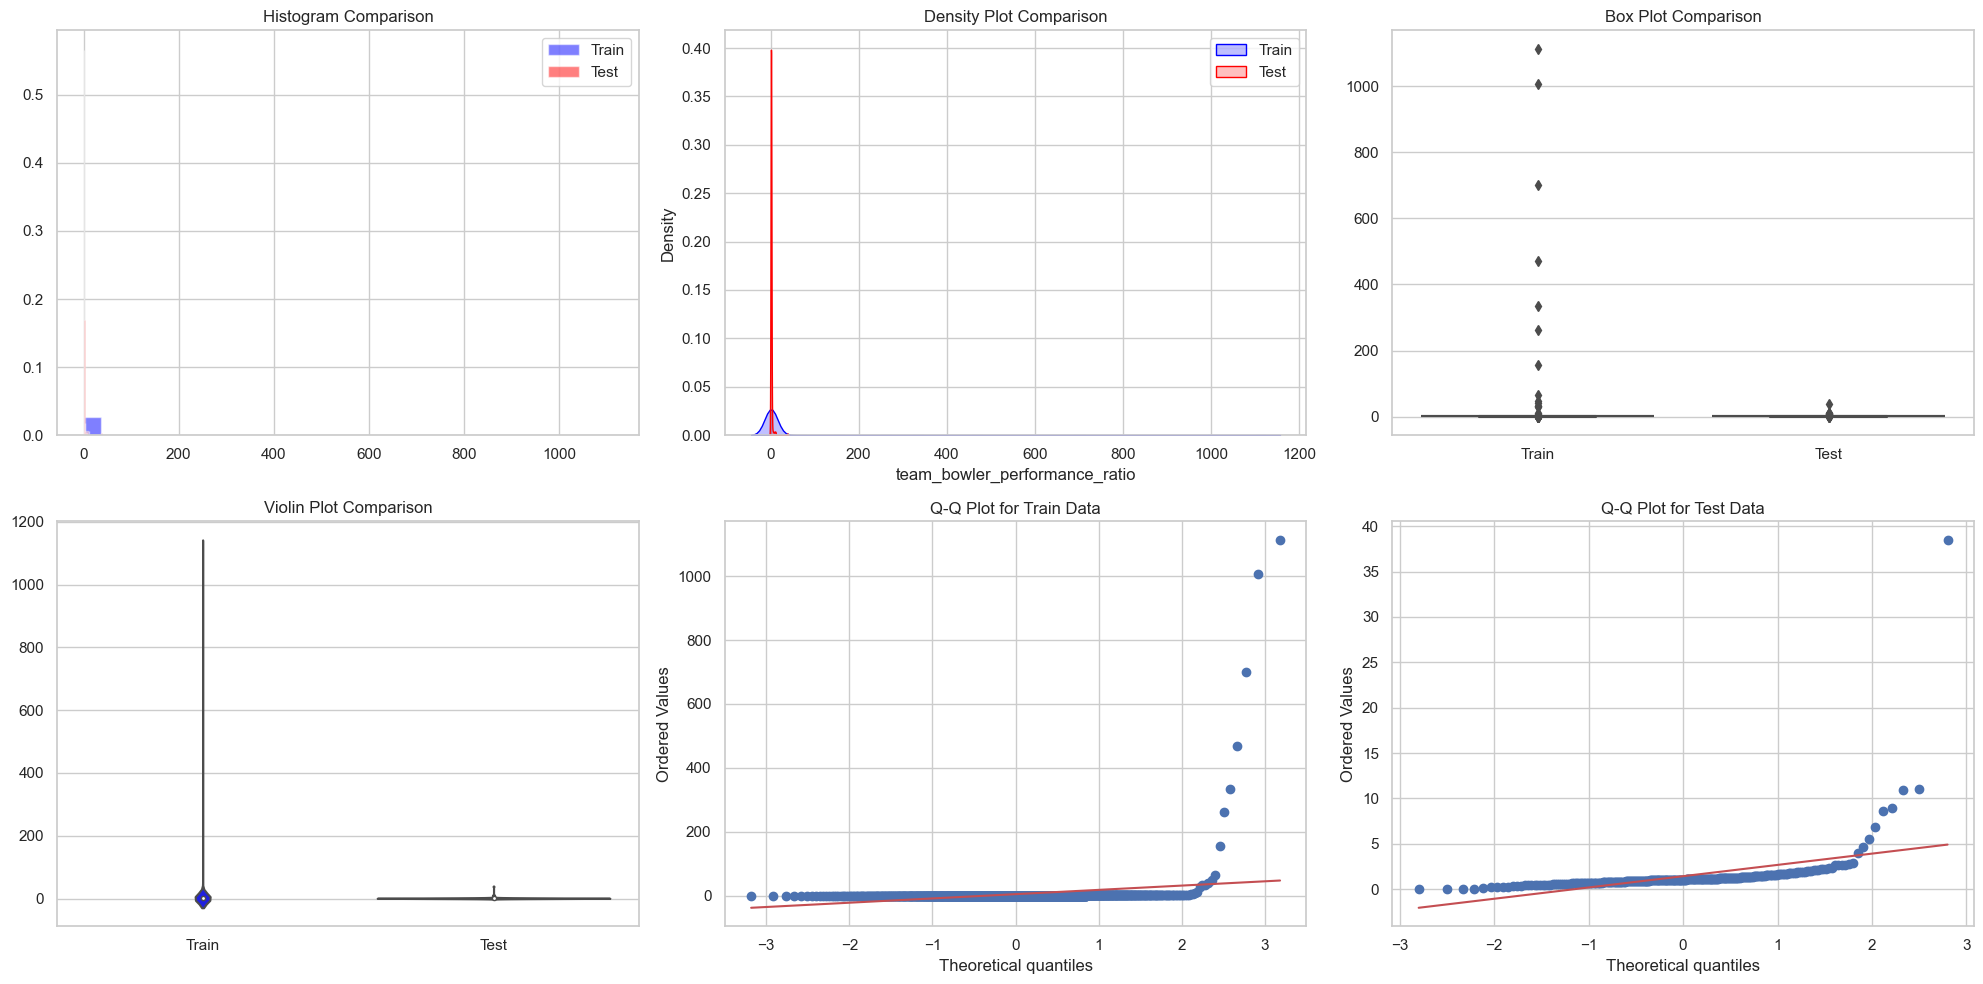

======================================= Train-Test Statistics =======================================

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Number of outliers in Train:  87

Number of outliers in Test:  26

Skewness of Train:  15.727021194757878 
Kurtosis of Train:  266.07928405443556

Skewness of Test:  11.446400247125148 
Kurtosis of Test:  156.22109804985087

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.618912    1.420354
std      57.700298    2.597474
min      -0.028103    0.000000
25%       0.790858    0.826576
50%       0.981911    1.051232
75%       1.284090    1.334909
max    1113.000000   38.500000
======================================= Model Performance =======================================

Correlation between team_bowler_performance_ratio and winner_01 is: -0.05037630480130837

Feature importance wrt team_count_50runs_last15 : 0.6383747707484813


In [127]:
analyse_feature(train_data, 'team_bowler_performance_ratio')

Feature 2

In [17]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':')
    res_list = []

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') 
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) 
        res_list.append(np.nansum(df_rel['gte_50runs']))
        
    return np.nansum(res_list)

In [18]:
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

train_data = train_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

100%|██████████| 271/271 [00:03<00:00, 89.50it/s]


slope: 0.6 / 0.39 =  1.53


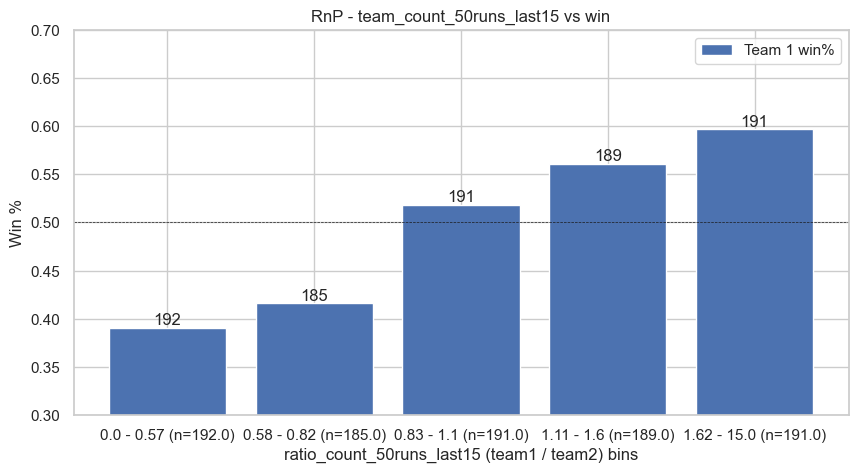

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931
Feature importances wrt team_count_50runs_last15 : 0.5038698691382515


In [33]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


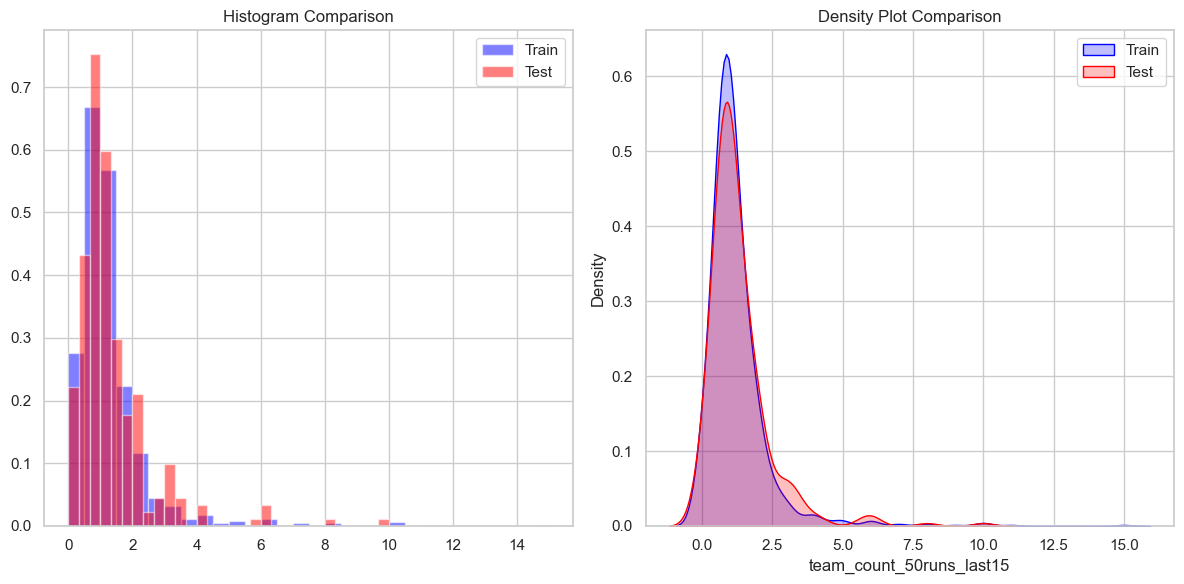

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000


In [15]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

slope: 0.6 / 0.39 =  1.53


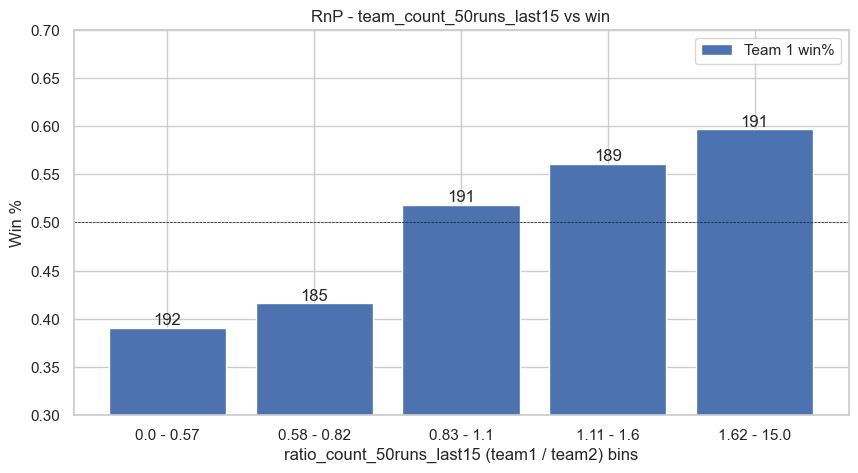

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


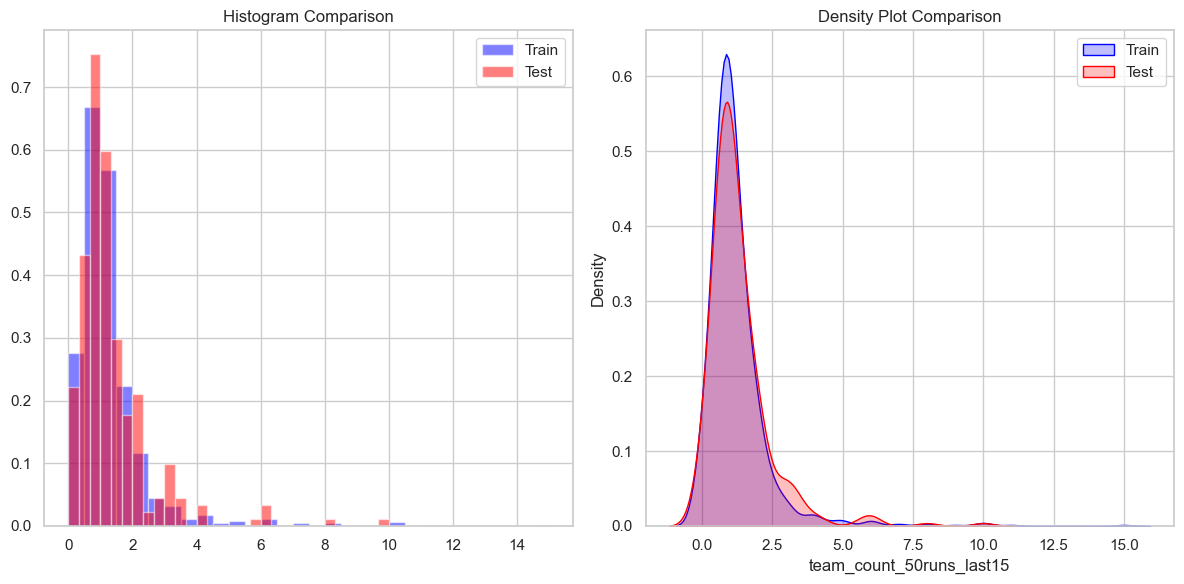

======================================= Train-Test Analysis =======================================

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Number of outliers in Train:  55

Number of outliers in Test:  22

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000
======================================= Model Performance =======================================

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931

Feature importance wrt team_count_50runs_last15 : 0.49605540188534547


In [106]:
analyse_feature(train_data, 'team_count_50runs_last15')

Feature 3

In [34]:
def team_win_rate_at_ground(team_id, ground_id, date, n):
    # Filter matches with specified team and ground, before the given date
    relevant_games = match_lvl_data[(match_lvl_data['match_dt'] < date) &
                                    ((match_lvl_data['team1_id'] == team_id) |
                                     (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['ground_id'] == ground_id)].sort_values(by='match_dt', ascending=False).head(n)

    # Calculate wins
    wins = relevant_games.apply(lambda x: 1 if x['winner_id'] == team_id else 0, axis=1).sum()

    # Calculate win rate
    if len(relevant_games) > 0:
        win_rate = wins / len(relevant_games)
    else:
        win_rate = 0  # No games to calculate from

    return win_rate

In [35]:
train_data['team1_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
train_data['team2_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

train_data = train_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

test_data['team1_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
test_data['team2_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

test_data = test_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

100%|██████████| 271/271 [00:00<00:00, 2225.31it/s]


slope: 0.56 / 0.47 =  1.2


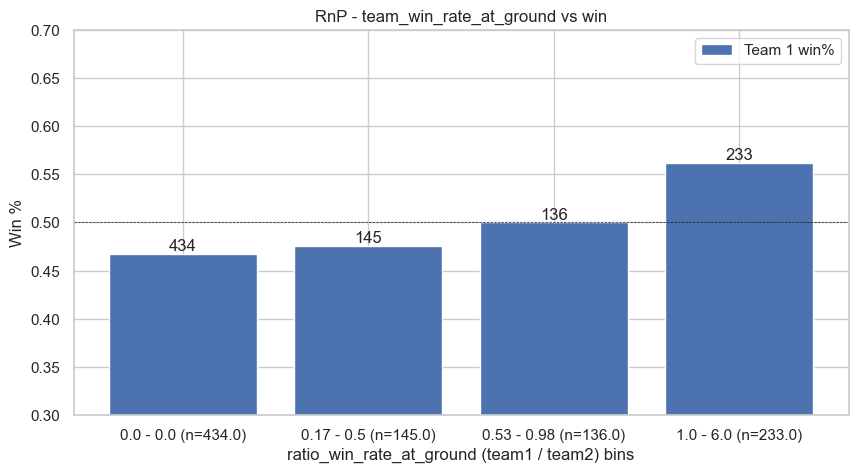

Correlation between team_win_rate_at_ground and winner_01 is: -0.05370441711356502
Feature importances wrt team_count_50runs_last15 : 0.2930361499954998


In [36]:
createRnP(train_data, 'team_win_rate_at_ground')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


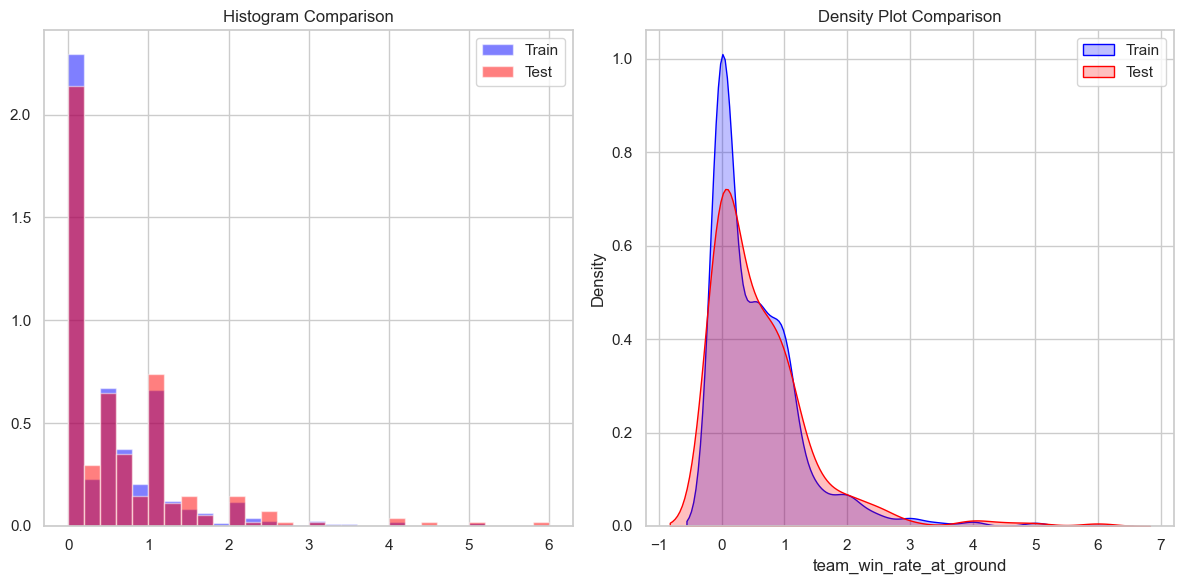

Kolmogorov-Smirnov test result: KS statistic = 0.0436, p-value = 0.7969

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542720    0.610622
std       0.740211    0.848291
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.937500    1.000000
max       6.000000    6.000000


In [19]:
check_distribution_match(train_data['team_win_rate_at_ground'], test_data['team_win_rate_at_ground'])

Feature 4

In [20]:
def calculate_batsman_strike_rate(player_list, date, n):
    player_list = str(player_list).split(':')  # Split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        runs = recent_matches['runs'].sum()
        balls = recent_matches['balls_faced'].sum()

        # Calculate strike rate and avoid division by zero
        if balls > 0:
            strike_rate = (runs / balls) * 100
        else:
            strike_rate = 0

        res_list.append(strike_rate)

    # Calculate the average strike rate across all players in the list
    if res_list:  # Ensure the list is not empty to avoid division by zero
        average_strike_rate = sum(res_list) / len(res_list)
    else:
        average_strike_rate = 0

    return average_strike_rate

In [21]:
train_data['team1_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

train_data = train_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

test_data['team1_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

test_data = test_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

100%|██████████| 271/271 [00:04<00:00, 61.84it/s]


slope: 0.55 / 0.42 =  1.32


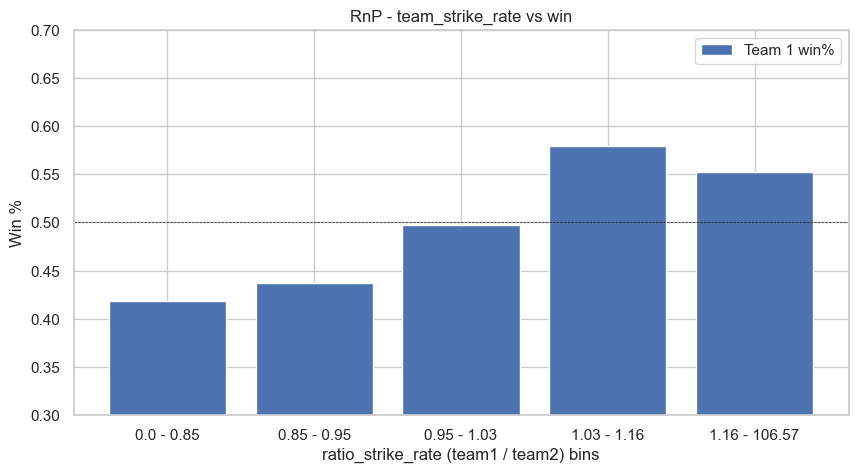

Correlation between team_strike_rate and winner_01 is: -0.046993779948201454


In [22]:
createRnP(train_data, 'team_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


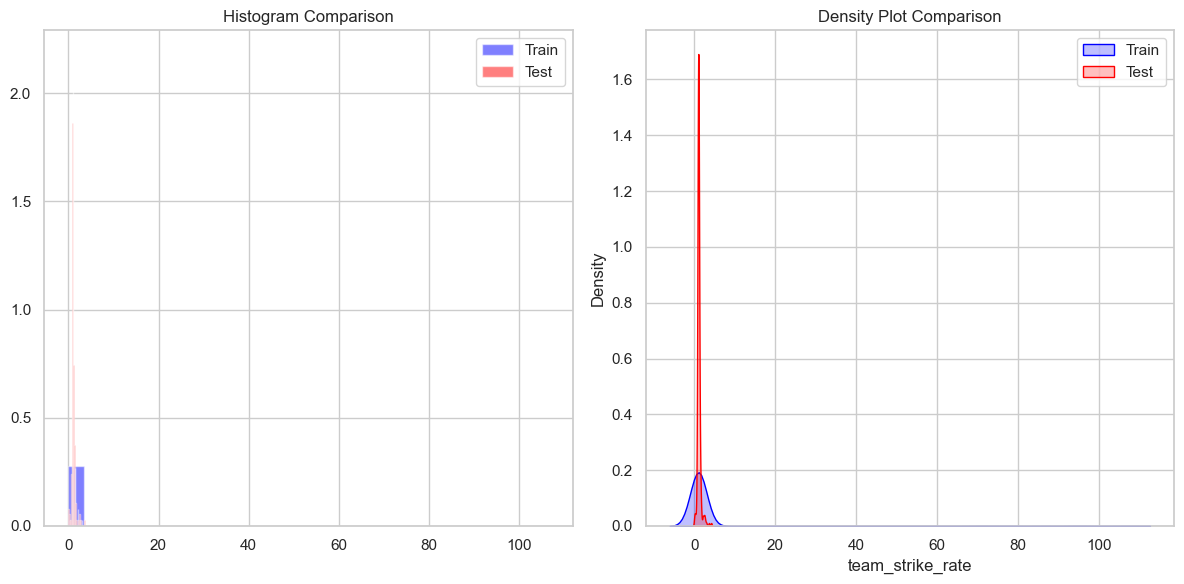

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.752818    1.056381
std       7.980454    0.426486
min       0.000000    0.000000
25%       0.887845    0.885572
50%       0.997539    0.998391
75%       1.115476    1.108754
max     106.574684    4.162338


In [23]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

Feature 5

In [24]:
def calculate_bowler_economy_rate(player_list, date, n):
    player_list = player_list.split(':')
    economy_rates = []
    for player_id in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        runs_conceded = recent_matches['runs'].sum()
        overs = (recent_matches['balls_bowled'].sum()) / 6
        economy_rate = (runs_conceded / overs) if overs > 0 else 0
        economy_rates.append(economy_rate)
    return sum(economy_rates) / len(economy_rates) if economy_rates else 0

In [25]:
train_data['team1_bowler_eco'] = train_data.progress_apply(lambda x: \
            calculate_bowler_economy_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_bowler_eco'] = train_data.progress_apply(lambda x: \
            calculate_bowler_economy_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_bowler_eco', 'team2_bowler_eco', 'team_bowler_eco')

train_data = train_data.drop(columns=['team1_bowler_eco', 'team2_bowler_eco'])

test_data['team1_bowler_eco'] = test_data.progress_apply(lambda x: \
            calculate_bowler_economy_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_bowler_eco'] = test_data.progress_apply(lambda x: \
            calculate_bowler_economy_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_bowler_eco', 'team2_bowler_eco', 'team_bowler_eco')

test_data = test_data.drop(columns=['team1_bowler_eco', 'team2_bowler_eco'])

100%|██████████| 271/271 [00:03<00:00, 76.31it/s]


slope: 0.48 / 0.47 =  1.03


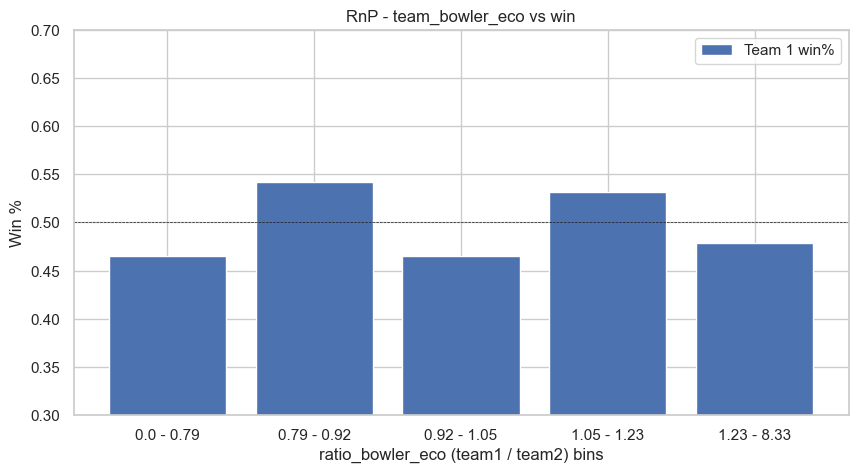

Correlation between team_bowler_eco and winner_01 is: -0.04197036190889738


In [26]:
createRnP(train_data, 'team_bowler_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


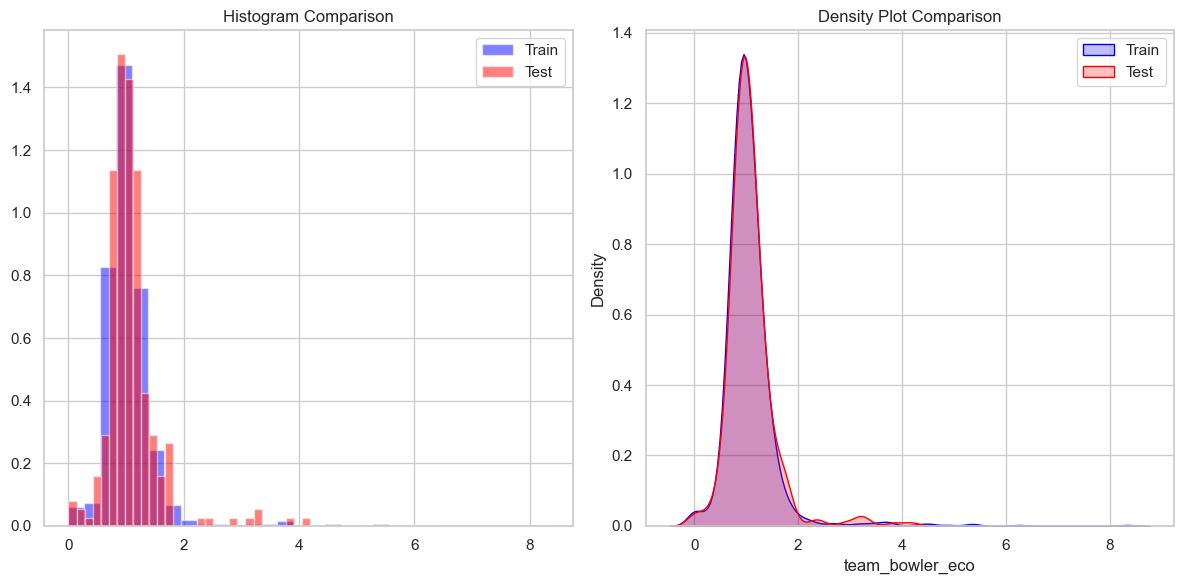

Kolmogorov-Smirnov test result: KS statistic = 0.0518, p-value = 0.6012

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.066295    1.077024
std       0.576179    0.481174
min       0.000000    0.000000
25%       0.818610    0.845078
50%       0.983986    0.994122
75%       1.178028    1.184080
max       8.330690    4.187878


In [27]:
check_distribution_match(train_data['team_bowler_eco'], test_data['team_bowler_eco'])

Feature 6

In [28]:
def average_wickets_taken(player_list, date, n):
    player_list = player_list.split(':')
    wickets_list = []
    for player_id in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_wickets = recent_matches['wicket_count'].sum()
        average_wickets = total_wickets / n if n > 0 else 0
        wickets_list.append(average_wickets)
    return sum(wickets_list) / len(wickets_list) if wickets_list else 0

In [29]:
train_data['team1_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

train_data = train_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

test_data['team1_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

test_data = test_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

100%|██████████| 271/271 [00:03<00:00, 77.68it/s]


slope: 0.6 / 0.39 =  1.55


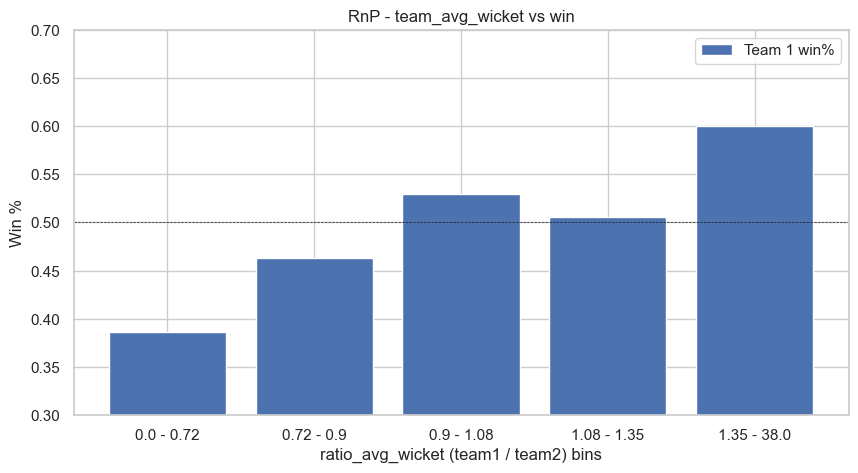

Correlation between team_avg_wicket and winner_01 is: -0.10351532938769395


In [30]:
createRnP(train_data, 'team_avg_wicket')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


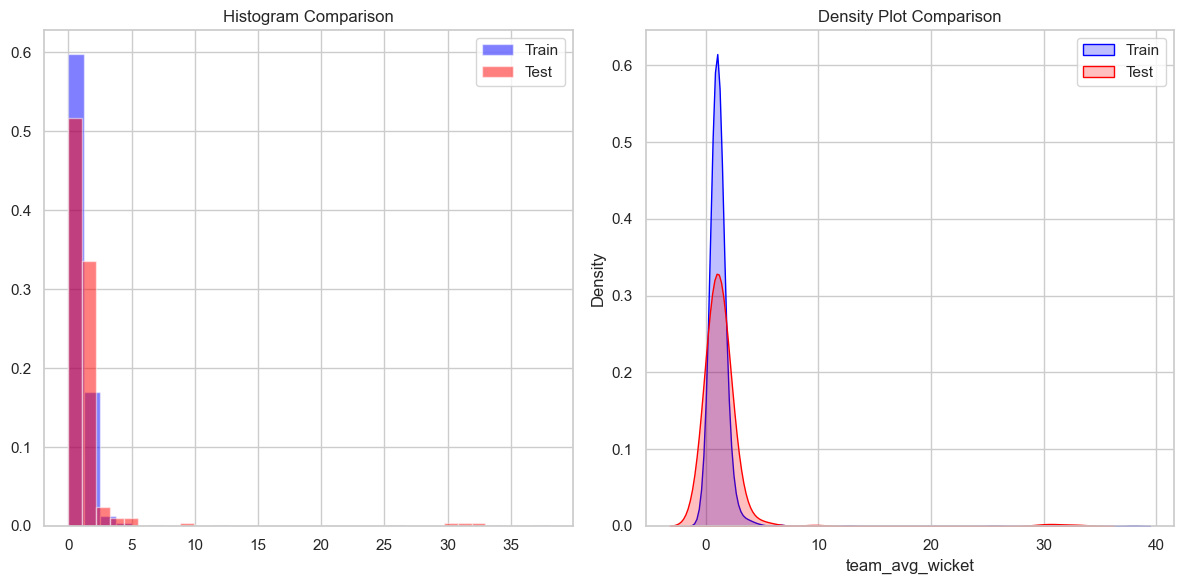

Kolmogorov-Smirnov test result: KS statistic = 0.0673, p-value = 0.2792

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.190463    1.501683
std       1.913690    3.281587
min       0.000000    0.000000
25%       0.785714    0.776298
50%       0.988300    1.000000
75%       1.258155    1.343919
max      38.000000   33.000000


In [31]:
check_distribution_match(train_data['team_avg_wicket'], test_data['team_avg_wicket'])

Feature 7

In [32]:
def team_batting_strength(player_list, date, n):
    players = player_list.split(':')
    total_runs = 0
    for player_id in players:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        total_runs += recent_matches['runs'].sum()
    return total_runs / len(players) if players else 0

In [33]:
train_data['team1_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

train_data = train_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

test_data['team1_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

test_data = test_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

100%|██████████| 271/271 [00:04<00:00, 62.78it/s]


slope: 0.64 / 0.34 =  1.88


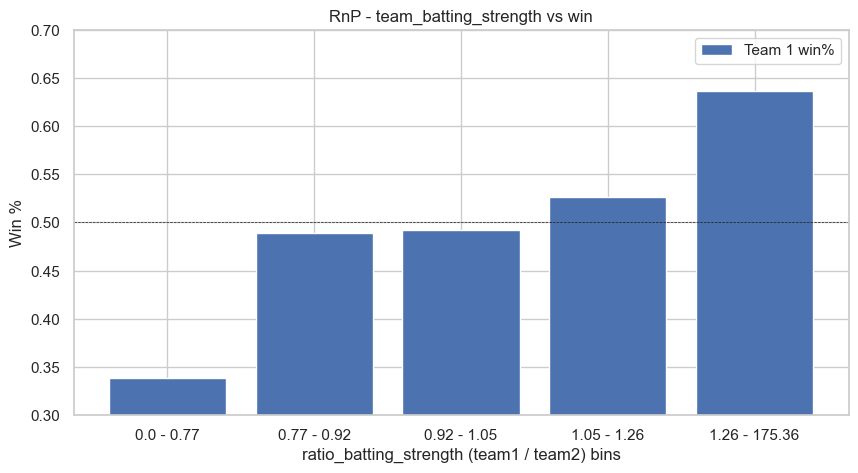

Correlation between team_batting_strength and winner_01 is: -0.06285430528267014


In [34]:
createRnP(train_data, 'team_batting_strength')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


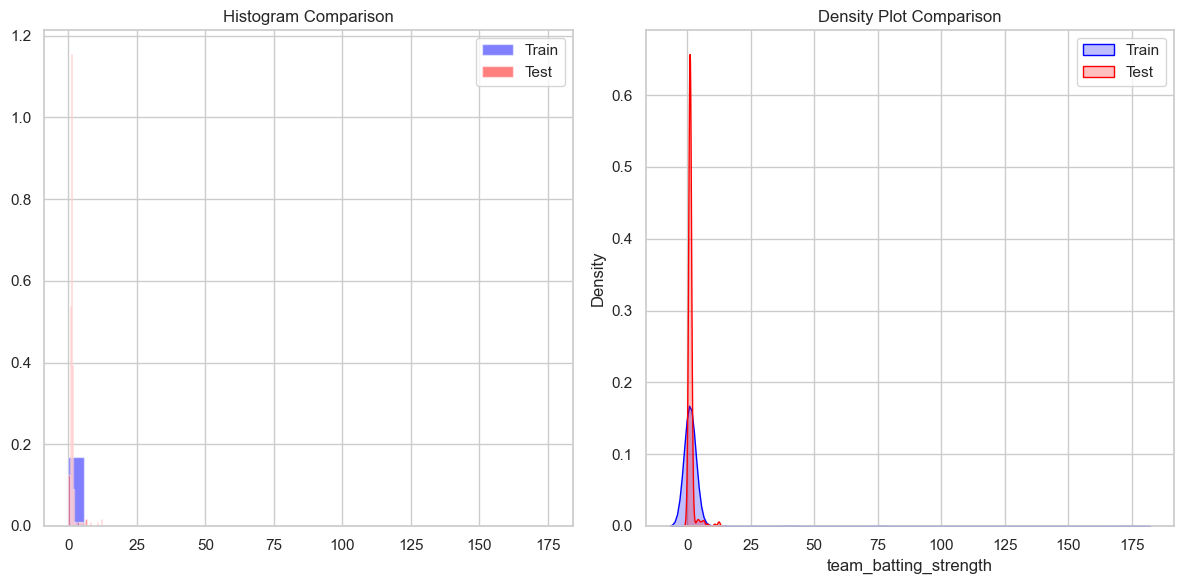

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.791761    1.270211
std       8.971790    1.436063
min       0.000000    0.000000
25%       0.813151    0.815097
50%       0.978937    0.993631
75%       1.189842    1.239880
max     175.363636   12.362069


In [35]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

Feature 8

In [36]:
def player_form_factor(player_list, date, n):
    players = player_list.split(':')
    form_factors = []
    for player_id in players:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            weights = np.linspace(1, 2, len(recent_matches))  # Linear weight increase from 1 to 2
            form_factors.append(np.average(recent_matches['runs'], weights=weights))
        else:
            form_factors.append(0)
    return np.mean(form_factors) if players else 0

In [37]:
train_data['team1_form_factor'] = train_data.progress_apply(lambda x: \
            player_form_factor(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_form_factor'] = train_data.progress_apply(lambda x: \
            player_form_factor(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_form_factor', 'team2_form_factor', 'team_form_factor')

train_data = train_data.drop(columns=['team1_form_factor', 'team2_form_factor'])

test_data['team1_form_factor'] = test_data.progress_apply(lambda x: \
            player_form_factor(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_form_factor'] = test_data.progress_apply(lambda x: \
            player_form_factor(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_form_factor', 'team2_form_factor', 'team_form_factor')

test_data = test_data.drop(columns=['team1_form_factor', 'team2_form_factor'])

100%|██████████| 271/271 [00:04<00:00, 61.43it/s]


slope: 0.59 / 0.41 =  1.46


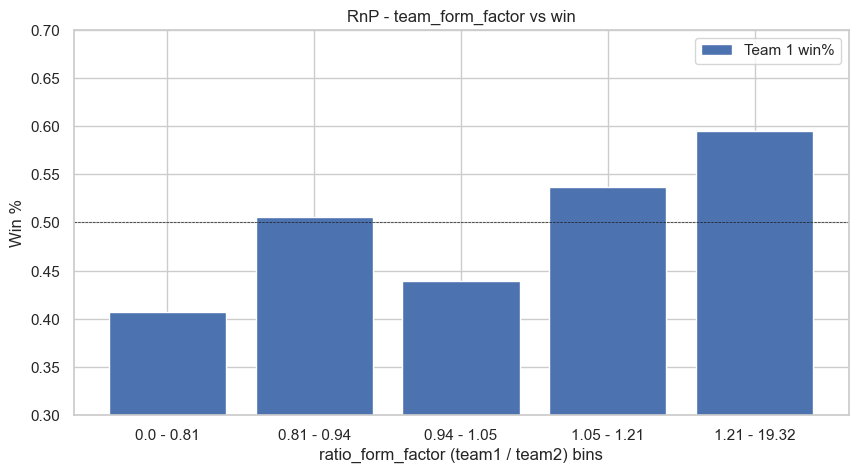

Correlation between team_form_factor and winner_01 is: -0.04545547811806016


In [38]:
createRnP(train_data, 'team_form_factor')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


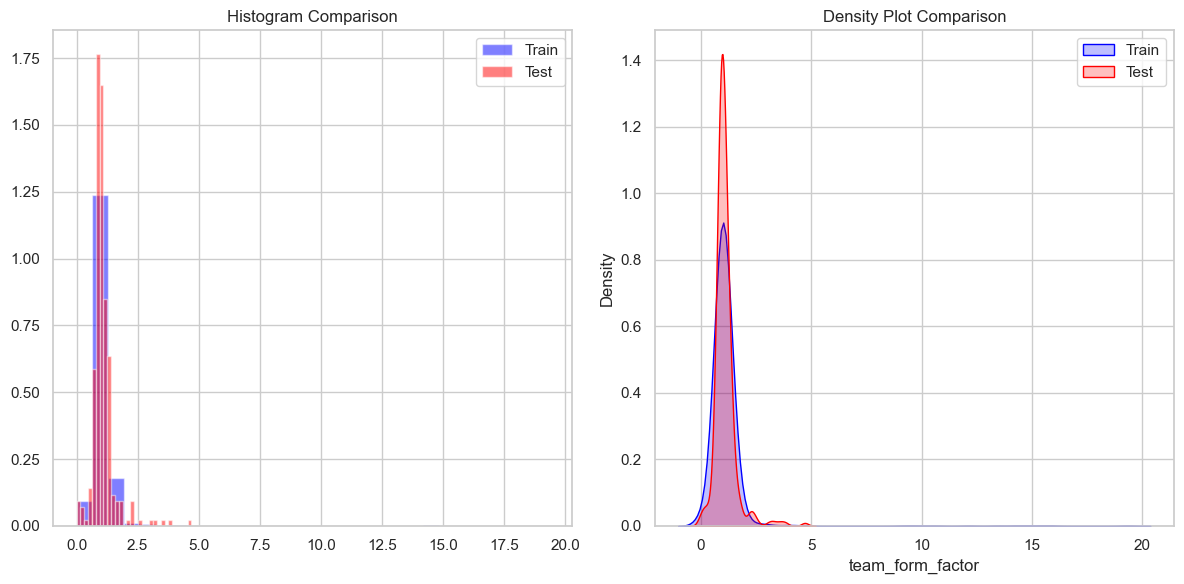

Kolmogorov-Smirnov test result: KS statistic = 0.0407, p-value = 0.8592

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.155706    1.069499
std       1.361124    0.494801
min       0.000000    0.000000
25%       0.847760    0.858813
50%       0.994122    0.985355
75%       1.161197    1.159973
max      19.323232    4.702703


In [39]:
check_distribution_match(train_data['team_form_factor'], test_data['team_form_factor'])

Feature 9

In [40]:
def head_to_head_performance(team1_id, team2_id, date, match_lvl_data):
    # Filter matches between the two teams up to the specified date
    relevant_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team1_id) & (match_lvl_data['team2_id'] == team2_id) |
         (match_lvl_data['team1_id'] == team2_id) & (match_lvl_data['team2_id'] == team1_id))
    ]

    # Calculate win percentage for team1
    team1_wins = relevant_matches['winner_id'].apply(lambda x: 1 if x == team1_id else 0).sum()
    win_percentage = team1_wins / len(relevant_matches) if len(relevant_matches) > 0 else 0

    # Calculate average score for team1 in these matches
    # Assuming scores are in 'inning1_runs' or 'inning2_runs' based on which team was batting first
    team1_scores = relevant_matches.apply(
        lambda x: x['inning1_runs'] if x['team1_id'] == team1_id else x['inning2_runs'], axis=1
    )
    team1_avg_score = team1_scores.mean() if len(team1_scores) > 0 else 0

    return win_percentage, team1_avg_score

In [41]:
train_data[['team1_win_percentage', 'team1_avg_score']] = train_data.apply(
    lambda x: head_to_head_performance(
        team1_id=x['team1_id'],
        team2_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1, result_type='expand'
)

train_data[['team2_win_percentage', 'team2_avg_score']] = train_data.apply(
    lambda x: head_to_head_performance(
        team1_id=x['team1_id'],
        team2_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1, result_type='expand'
)

train_data = add_ratio_column(train_data, 'team1_win_percentage', 'team2_win_percentage', 'team_win_percentage')
train_data = add_ratio_column(train_data, 'team1_avg_score', 'team2_avg_score', 'team_avg_score')

train_data = train_data.drop(columns=['team1_win_percentage', 'team2_win_percentage', 'team1_avg_score', 'team2_avg_score'])

test_data[['team1_win_percentage', 'team1_avg_score']] = test_data.apply(
    lambda x: head_to_head_performance(
        team1_id=x['team1_id'],
        team2_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1, result_type='expand'
)

test_data[['team2_win_percentage', 'team2_avg_score']] = test_data.apply(
    lambda x: head_to_head_performance(
        team1_id=x['team1_id'],
        team2_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1, result_type='expand'
)

test_data = add_ratio_column(test_data, 'team1_win_percentage', 'team2_win_percentage', 'team_win_percentage')
test_data = add_ratio_column(test_data, 'team1_avg_score', 'team2_avg_score', 'team_avg_score')

test_data = test_data.drop(columns=['team1_win_percentage', 'team2_win_percentage', 'team1_avg_score', 'team2_avg_score'])

slope: 0.52 / 0.45 =  1.16


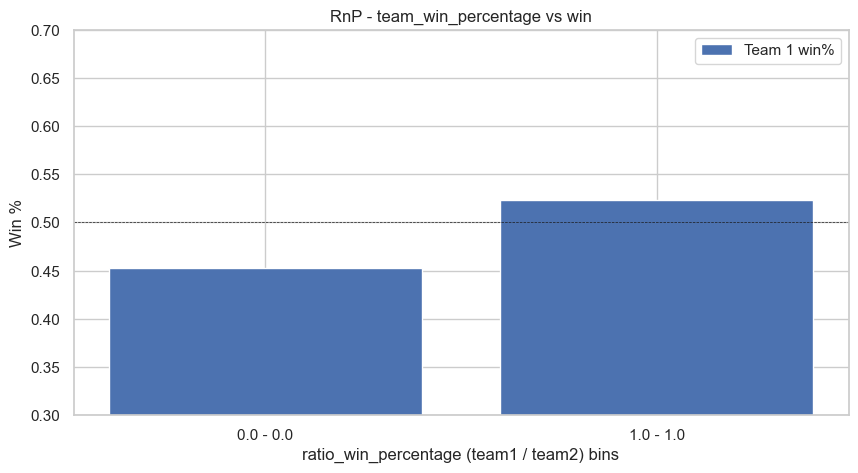

Correlation between team_win_percentage and winner_01 is: -0.0691549524605129


In [42]:
createRnP(train_data, 'team_win_percentage')

slope: 0.51 / 0.46 =  1.12


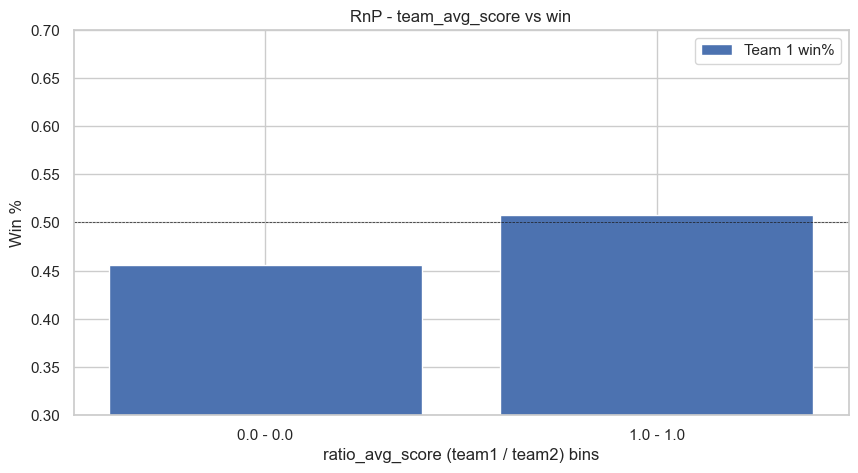

Correlation between team_avg_score and winner_01 is: -0.04307639259692788


In [43]:
createRnP(train_data, 'team_avg_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


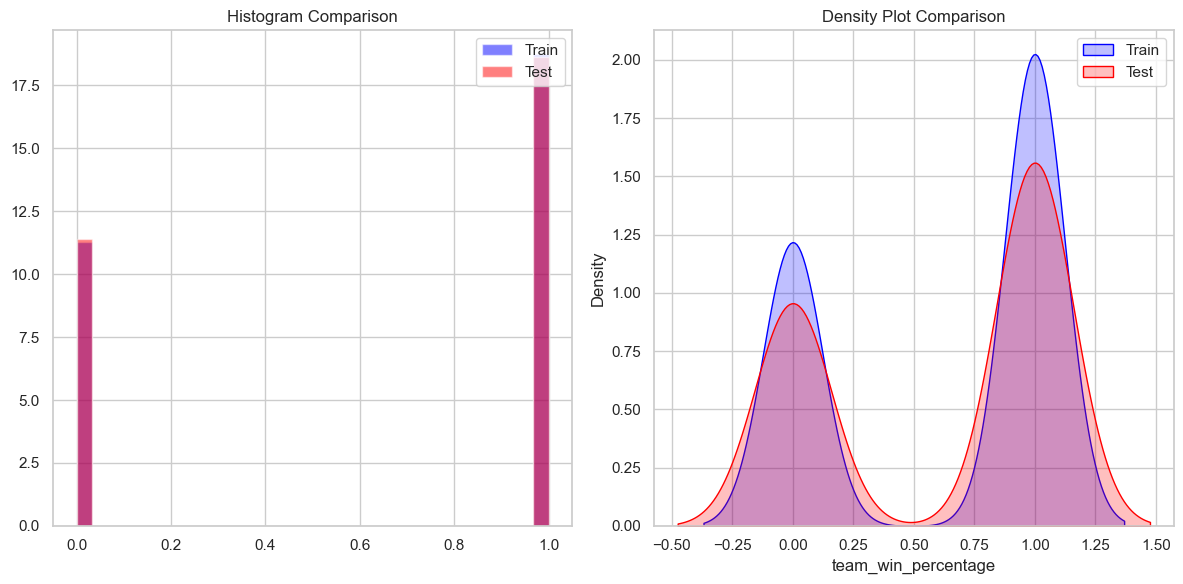

Kolmogorov-Smirnov test result: KS statistic = 0.0045, p-value = 1.0000

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.624473    0.619926
std       0.484514    0.486303
min       0.000000    0.000000
25%       0.000000    0.000000
50%       1.000000    1.000000
75%       1.000000    1.000000
max       1.000000    1.000000


In [44]:
check_distribution_match(train_data['team_win_percentage'], test_data['team_win_percentage'])

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


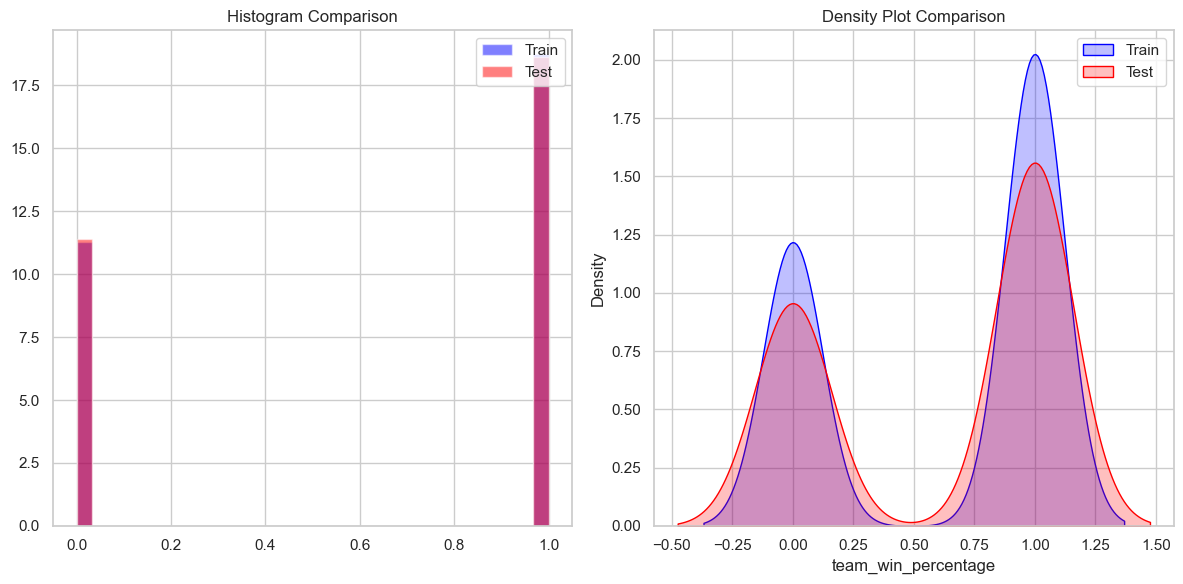

Kolmogorov-Smirnov test result: KS statistic = 0.0045, p-value = 1.0000

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.624473    0.619926
std       0.484514    0.486303
min       0.000000    0.000000
25%       0.000000    0.000000
50%       1.000000    1.000000
75%       1.000000    1.000000
max       1.000000    1.000000


In [45]:
check_distribution_match(train_data['team_win_percentage'], test_data['team_win_percentage'])

Feature 10

In [46]:
def recent_performance(team_id, date, n, match_lvl_data):
    recent_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ].tail(n)
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return wins / len(recent_matches) if len(recent_matches) > 0 else 0

In [47]:
train_data['team1_recent_win_rate'] = train_data.apply(
    lambda x: recent_performance(
        team_id=x['team1_id'],
        date=x['match_dt'],
        n=15,
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_recent_win_rate'] = train_data.apply(
    lambda x: recent_performance(
        team_id=x['team2_id'],
        date=x['match_dt'],
        n=15,
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_recent_win_rate', 'team2_recent_win_rate', 'team_recent_win_rate')

train_data = train_data.drop(columns=['team1_recent_win_rate', 'team2_recent_win_rate'])

test_data['team1_recent_win_rate'] = test_data.apply(
    lambda x: recent_performance(
        team_id=x['team1_id'],
        date=x['match_dt'],
        n=15,
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_recent_win_rate'] = test_data.apply(
    lambda x: recent_performance(
        team_id=x['team2_id'],
        date=x['match_dt'],
        n=15,
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_recent_win_rate', 'team2_recent_win_rate', 'team_recent_win_rate')

test_data = test_data.drop(columns=['team1_recent_win_rate', 'team2_recent_win_rate'])

slope: 0.56 / 0.41 =  1.36


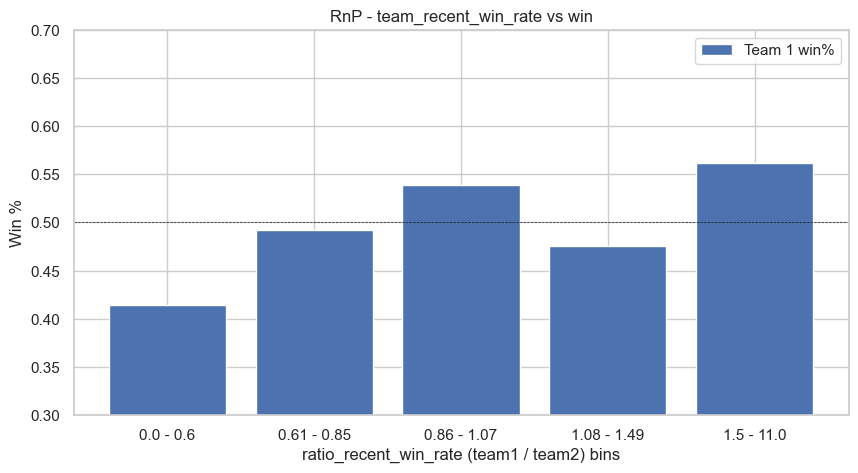

Correlation between team_recent_win_rate and winner_01 is: -0.0903891506216548


In [48]:
createRnP(train_data, 'team_recent_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


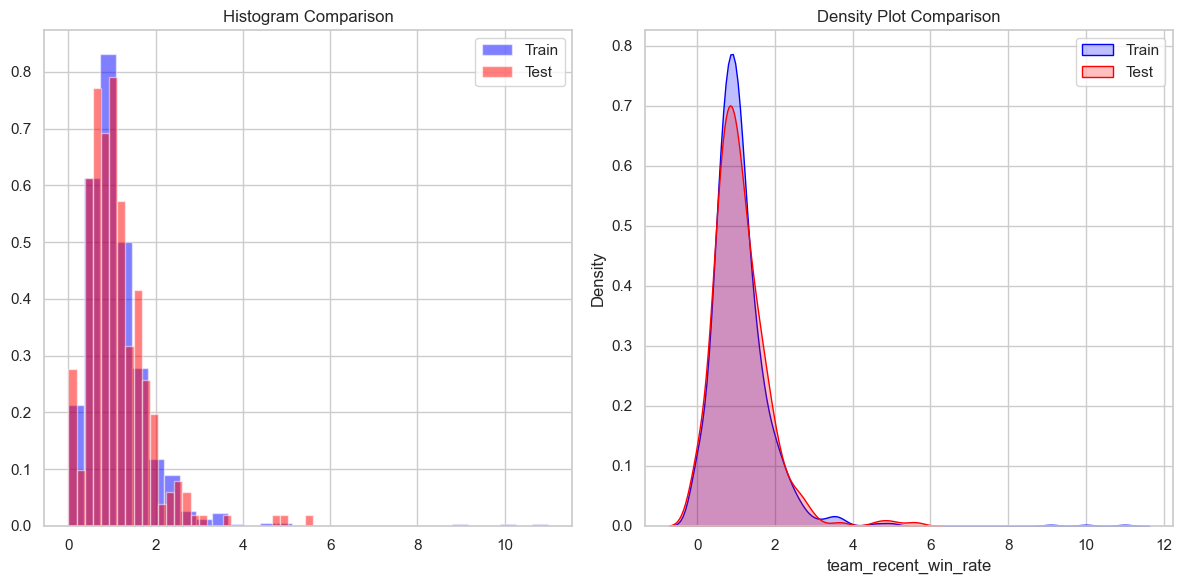

Kolmogorov-Smirnov test result: KS statistic = 0.0526, p-value = 0.5823

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.098706    1.106720
std       0.823729    0.737372
min       0.000000    0.000000
25%       0.666667    0.666667
50%       1.000000    1.000000
75%       1.333333    1.400000
max      11.000000    5.600000


In [49]:
check_distribution_match(train_data['team_recent_win_rate'], test_data['team_recent_win_rate'])

Feature 11

In [50]:
def average_winning_margin(team_id, date, match_lvl_data):
    winning_matches = match_lvl_data[
        (match_lvl_data['winner_id'] == team_id) & (match_lvl_data['match_dt'] < date)
    ]
    if len(winning_matches) > 0:
        runs_wins = winning_matches[winning_matches['by'] == 'runs']['win amount']
        wickets_wins = winning_matches[winning_matches['by'] == 'wickets']['win amount']
        average_margin = pd.concat([runs_wins, wickets_wins]).mean()
        return average_margin
    return 0

In [51]:
train_data['team1_average_winning_margin'] = train_data.apply(
    lambda x: average_winning_margin(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_average_winning_margin'] = train_data.apply(
    lambda x: average_winning_margin(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_average_winning_margin', 'team2_average_winning_margin', 'team_average_winning_margin')

train_data = train_data.drop(columns=['team1_average_winning_margin', 'team2_average_winning_margin'])

test_data['team1_average_winning_margin'] = test_data.apply(
    lambda x: average_winning_margin(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_average_winning_margin'] = test_data.apply(
    lambda x: average_winning_margin(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_average_winning_margin', 'team2_average_winning_margin', 'team_average_winning_margin')

test_data = test_data.drop(columns=['team1_average_winning_margin', 'team2_average_winning_margin'])

slope: 0.56 / 0.41 =  1.35


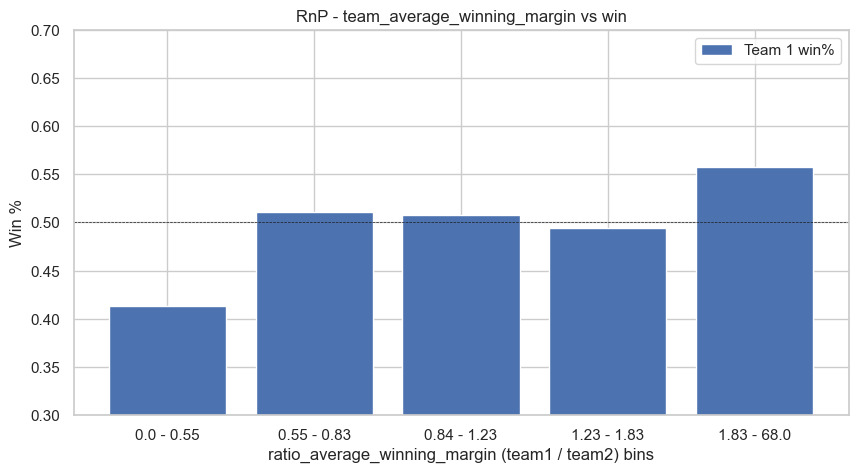

Correlation between team_average_winning_margin and winner_01 is: -0.06935292256582769


In [52]:
createRnP(train_data, 'team_average_winning_margin')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


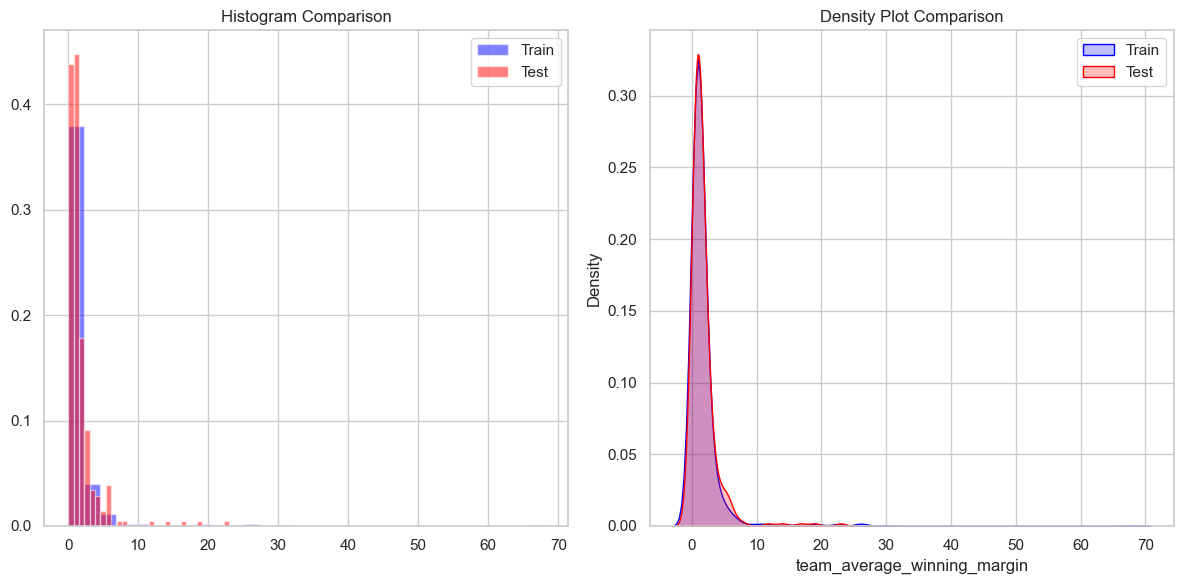

Kolmogorov-Smirnov test result: KS statistic = 0.0647, p-value = 0.3223

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.737016    1.732833
std       3.611949    2.523967
min       0.000000    0.000000
25%       0.624547    0.626917
50%       1.022034    1.084362
75%       1.618600    1.882749
max      68.000000   23.000000


In [53]:
check_distribution_match(train_data['team_average_winning_margin'], test_data['team_average_winning_margin'])

Feature 12

In [54]:
def team_scoring_average(team_id, date, match_lvl_data):
    team_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ]
    team_scores = team_matches.apply(
        lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1
    )
    return team_scores.mean() if len(team_scores) > 0 else 0

In [55]:
train_data['team1_scoring_average'] = train_data.apply(
    lambda x: team_scoring_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_scoring_average'] = train_data.apply(
    lambda x: team_scoring_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_scoring_average', 'team2_scoring_average', 'team_scoring_average')

train_data = train_data.drop(columns=['team1_scoring_average', 'team2_scoring_average'])

test_data['team1_scoring_average'] = test_data.apply(
    lambda x: team_scoring_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_scoring_average'] = test_data.apply(
    lambda x: team_scoring_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_scoring_average', 'team2_scoring_average', 'team_scoring_average')

test_data = test_data.drop(columns=['team1_scoring_average', 'team2_scoring_average'])

slope: 0.56 / 0.44 =  1.27


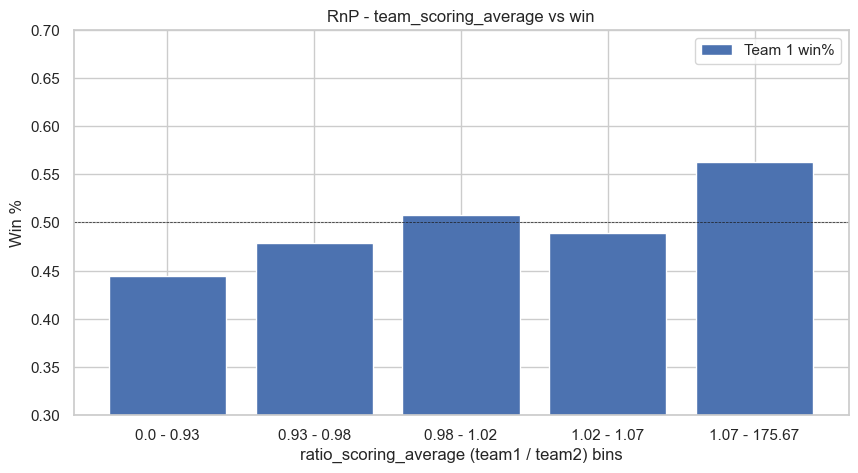

Correlation between team_scoring_average and winner_01 is: -0.03803020668432097


In [56]:
createRnP(train_data, 'team_scoring_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


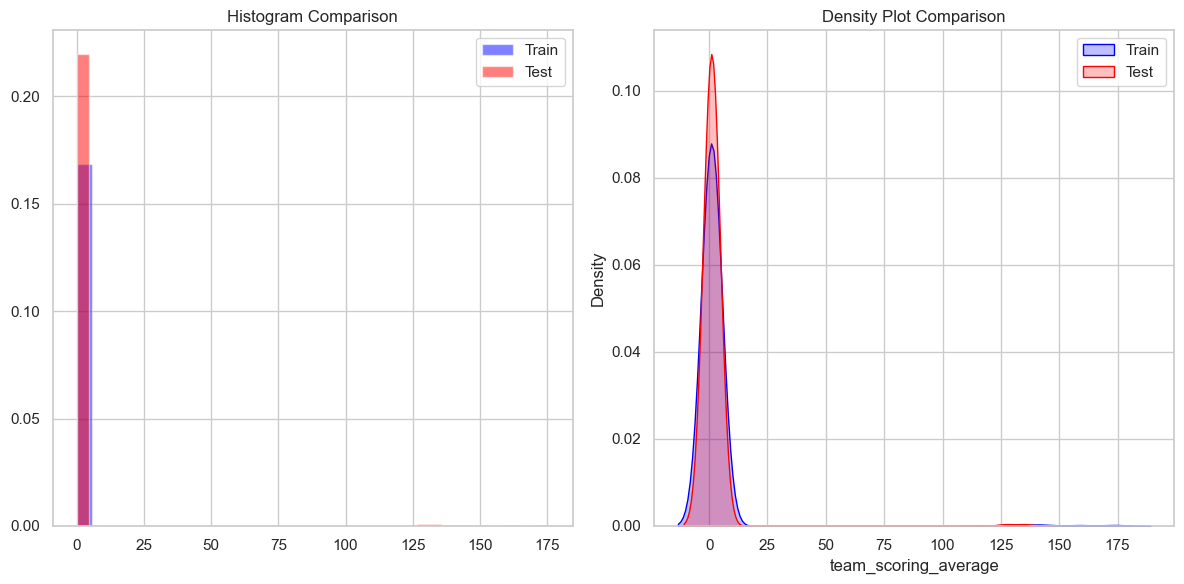

Kolmogorov-Smirnov test result: KS statistic = 0.0400, p-value = 0.8724

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.117817    1.946268
std      17.591052   11.182114
min       0.000000    0.000000
25%       0.947739    0.943881
50%       1.002780    1.000338
75%       1.059594    1.065438
max     175.666667  135.600000


In [57]:
check_distribution_match(train_data['team_scoring_average'], test_data['team_scoring_average'])

Feature 13

In [58]:
def team_wicket_loss_average(team_id, date, match_lvl_data):
    team_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ]
    team_wickets = team_matches.apply(
        lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1
    )
    return team_wickets.mean() if len(team_wickets) > 0 else 0

In [59]:
train_data['team1_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

train_data = train_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

test_data['team1_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

test_data = test_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

slope: 0.53 / 0.47 =  1.14


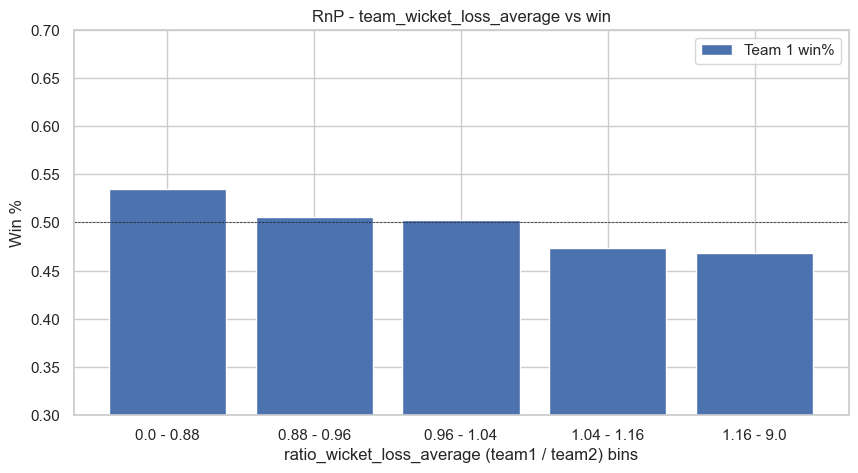

Correlation between team_wicket_loss_average and winner_01 is: -0.012728204099509413


In [60]:
createRnP(train_data, 'team_wicket_loss_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


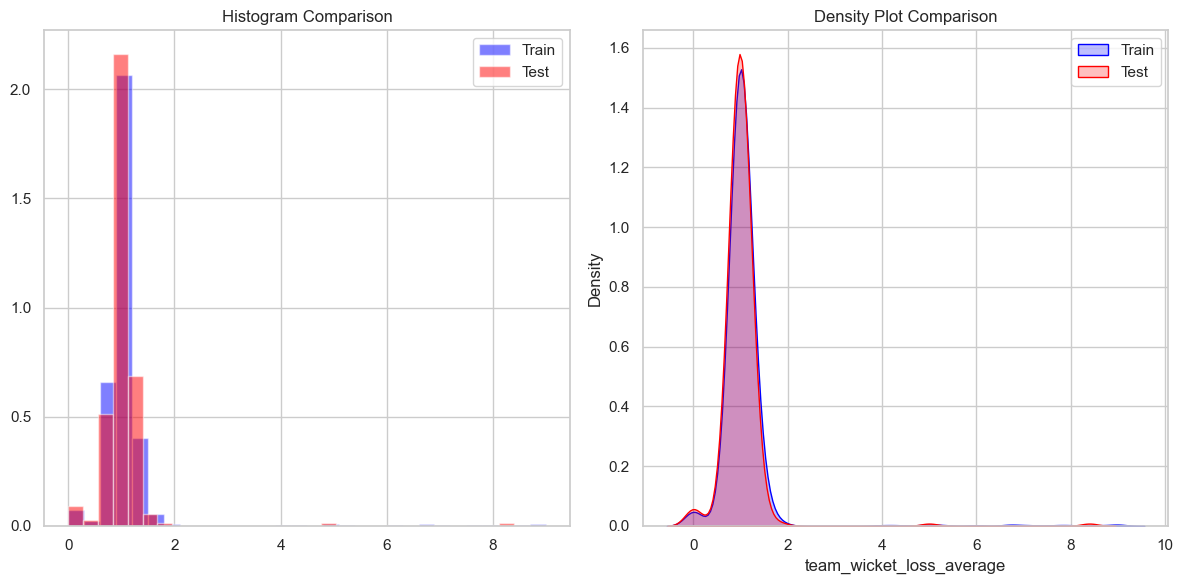

Kolmogorov-Smirnov test result: KS statistic = 0.1095, p-value = 0.0115

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.085126    1.012449
std       0.743221    0.563005
min       0.000000    0.000000
25%       0.909314    0.877306
50%       1.008309    0.985822
75%       1.122680    1.095405
max       9.000000    8.400000


In [61]:
check_distribution_match(train_data['team_wicket_loss_average'], test_data['team_wicket_loss_average'])

Feature 14

In [62]:
def team_win_rate_at_venue(team_id, venue_id, date, match_lvl_data):
    # Filter matches where the team played at the given venue up to the specified date
    relevant_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                      ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['match_dt'] < date)]
    wins = relevant_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    win_rate = wins / len(relevant_matches) if len(relevant_matches) > 0 else 0
    return win_rate

In [63]:
train_data['team1_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

test_data['team1_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.2


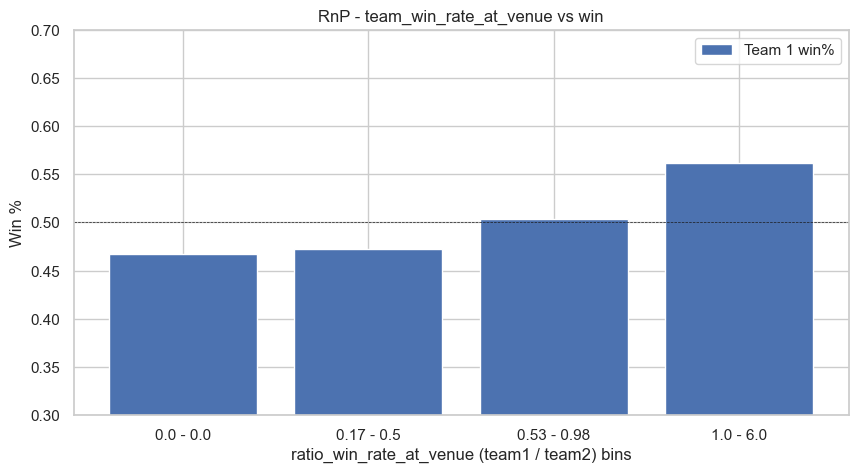

Correlation between team_win_rate_at_venue and winner_01 is: -0.053605345112640965


In [64]:
createRnP(train_data, 'team_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


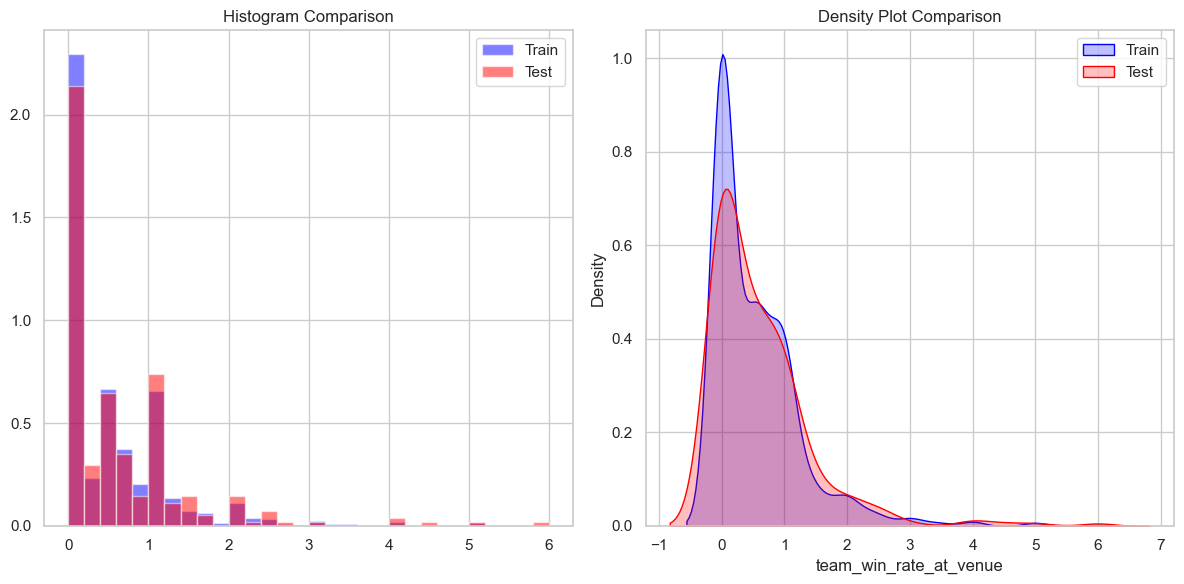

Kolmogorov-Smirnov test result: KS statistic = 0.0447, p-value = 0.7729

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542736    0.610468
std       0.740733    0.848285
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.930804    1.000000
max       6.000000    6.000000


In [65]:
check_distribution_match(train_data['team_win_rate_at_venue'], test_data['team_win_rate_at_venue'])

# Harshit

Feature 15

In [66]:
def team_batsman_performance_index(bat_df, match_id, team_roster_ids, date, n=5):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 0.5 +
                                  recent_matches['strike_rate'] * 0.3 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] * 2) * 0.2) * \
                                  (1 + 0.1 * recent_matches['is_batsman_captain'].iloc[0] +
                                   0.05 * recent_matches['is_batsman_keeper'].iloc[0])
            total_performance_index += player_performance.sum()

    return total_performance_index

In [67]:
train_data['team1_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

train_data = train_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

test_data['team1_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

test_data = test_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

slope: 0.56 / 0.38 =  1.46


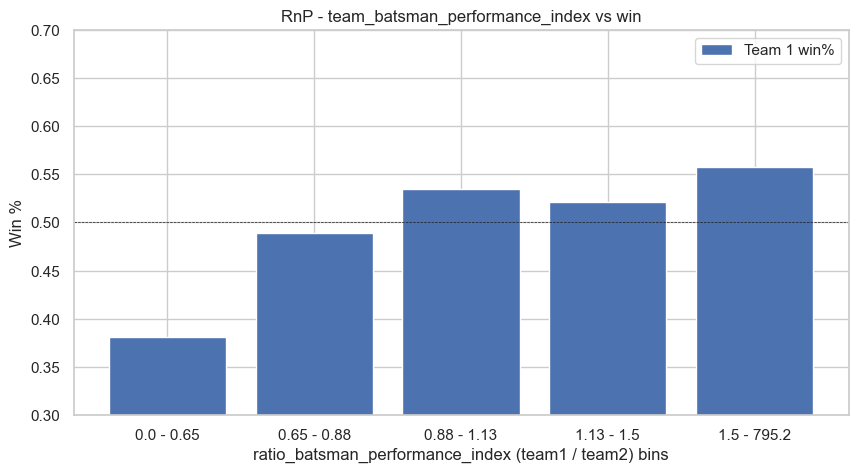

Correlation between team_batsman_performance_index and winner_01 is: -0.04003766613639936


In [68]:
createRnP(train_data, 'team_batsman_performance_index')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


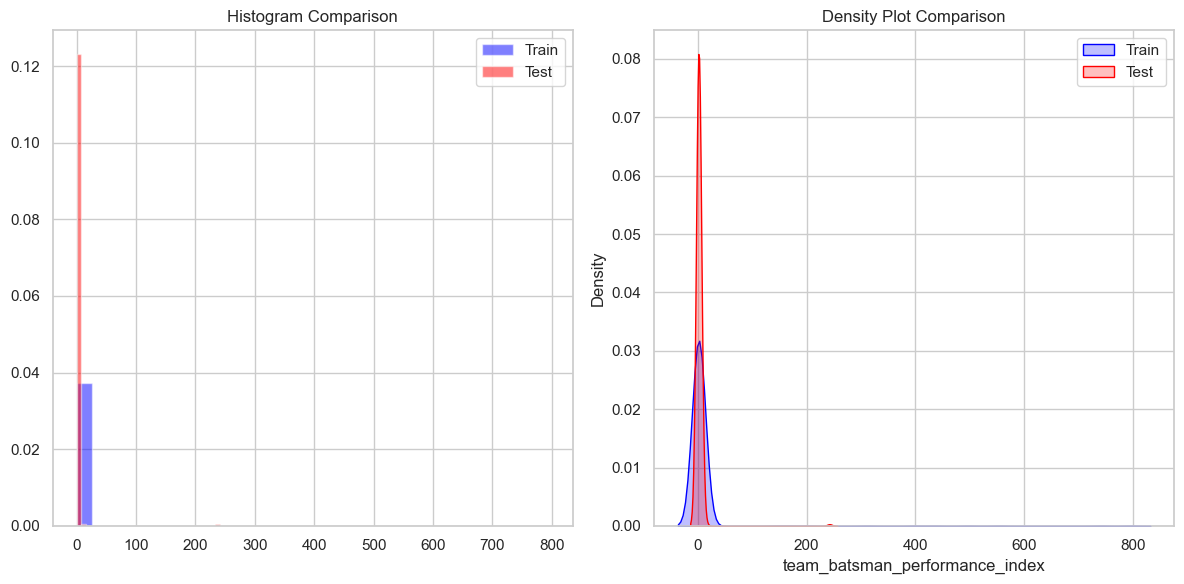

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8554

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.643986    2.142693
std      48.671236   14.668528
min       0.000000    0.000000
25%       0.725474    0.748330
50%       0.993099    1.037092
75%       1.400159    1.403964
max     795.199750  241.844000


In [69]:
check_distribution_match(train_data['team_batsman_performance_index'], test_data['team_batsman_performance_index'])

Feature 16

In [70]:
def team_bowler_impact_score(bowler_df, match_id, team_roster_ids, date, n=5):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count'] * 2 +
                             (120 / recent_matches['economy']) * 0.5 +
                             recent_matches['maiden'] * 1) * \
                            (1 + 0.1 * recent_matches['is_bowler_captain'].iloc[0] +
                             0.05 * recent_matches['is_bowler_keeper'].iloc[0])
            total_impact_score += player_impact.sum()

    return total_impact_score

In [71]:
train_data['team1_bowler_impact_score'] = train_data.apply(
    lambda x: team_bowler_impact_score(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_bowler_impact_score'] = train_data.apply(
    lambda x: team_bowler_impact_score(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_bowler_impact_score', 'team2_bowler_impact_score', 'team_bowler_impact_score')

train_data = train_data.drop(columns=['team1_bowler_impact_score', 'team2_bowler_impact_score'])

test_data['team1_bowler_impact_score'] = test_data.apply(
    lambda x: team_bowler_impact_score(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_bowler_impact_score'] = test_data.apply(
    lambda x: team_bowler_impact_score(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_bowler_impact_score', 'team2_bowler_impact_score', 'team_bowler_impact_score')

test_data = test_data.drop(columns=['team1_bowler_impact_score', 'team2_bowler_impact_score'])

slope: 0.51 / 0.46 =  1.1


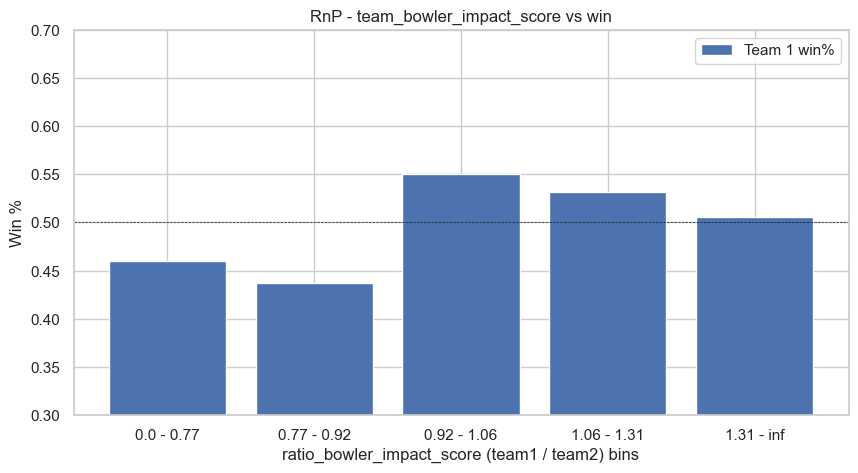

Correlation between team_bowler_impact_score and winner_01 is: nan


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [72]:
createRnP(train_data, 'team_bowler_impact_score')

In [73]:
# check_distribution_match(train_data['team_bowler_impact_score'], test_data['team_bowler_impact_score'])

Feature 17

In [74]:
def lighting_performance(match_lvl_data, lighting_type, team_id, date):
    matches = match_lvl_data[(match_lvl_data['lighting'] == lighting_type) & (match_lvl_data['match_dt'] < date)]
    if len(matches) > 0:
        wins = matches[matches['winner_id'] == team_id].shape[0]
        return wins / len(matches)
    return 0 

In [75]:
train_data['team1_night_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'night match', x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_night_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'night match', x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_night_match_win_rate', 'team2_night_match_win_rate', 'team_night_match_win_rate')

train_data = train_data.drop(columns=['team1_night_match_win_rate', 'team2_night_match_win_rate'])

test_data['team1_night_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'night match', x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_night_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'night match', x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_night_match_win_rate', 'team2_night_match_win_rate', 'team_night_match_win_rate')

test_data = test_data.drop(columns=['team1_night_match_win_rate', 'team2_night_match_win_rate'])

slope: 0.56 / 0.44 =  1.26


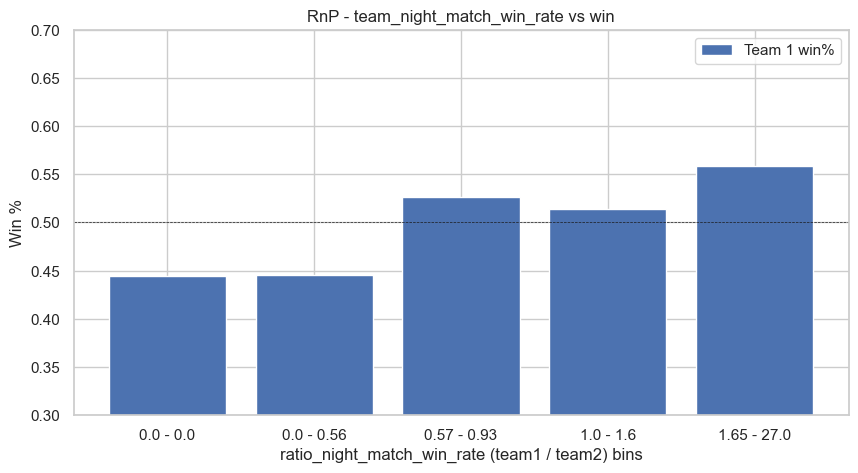

Correlation between team_night_match_win_rate and winner_01 is: -0.09499519809545301


In [76]:
createRnP(train_data, 'team_night_match_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


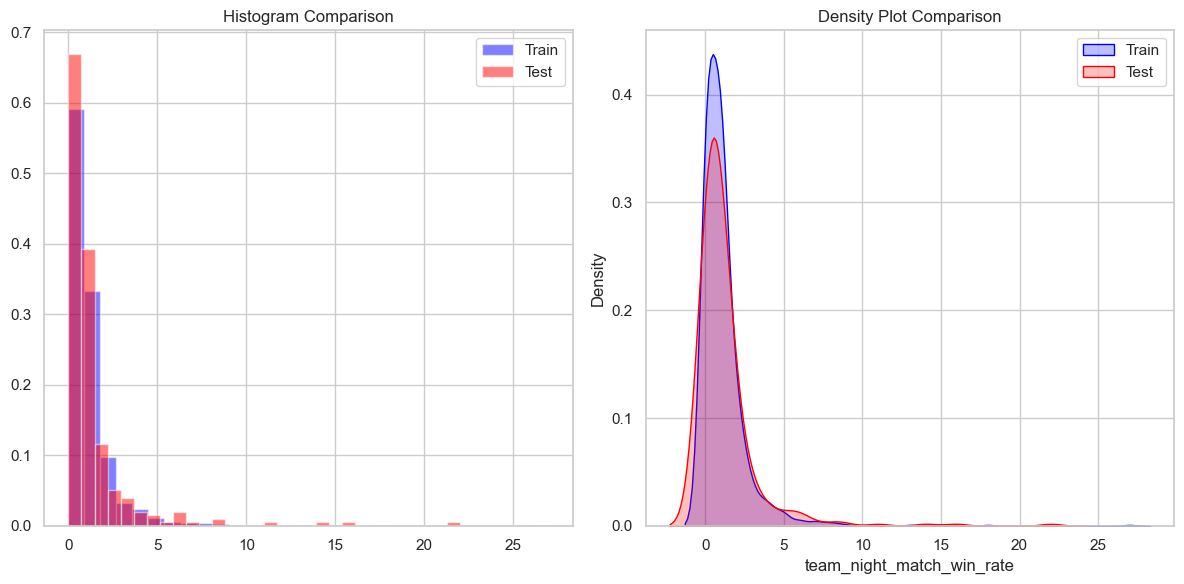

Kolmogorov-Smirnov test result: KS statistic = 0.0667, p-value = 0.2907

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.123941    1.276431
std       1.706754    2.305591
min       0.000000    0.000000
25%       0.131250    0.012898
50%       0.800000    0.750000
75%       1.333333    1.309524
max      27.000000   22.000000


In [77]:
check_distribution_match(train_data['team_night_match_win_rate'], test_data['team_night_match_win_rate'])

In [78]:
train_data['team1_day_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day match', x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_day_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day match', x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_day_match_win_rate', 'team2_day_match_win_rate', 'team_day_match_win_rate')

train_data = train_data.drop(columns=['team1_day_match_win_rate', 'team2_day_match_win_rate'])

test_data['team1_day_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day match', x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_day_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day match', x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_day_match_win_rate', 'team2_day_match_win_rate', 'team_day_match_win_rate')

test_data = test_data.drop(columns=['team1_day_match_win_rate', 'team2_day_match_win_rate'])

slope: 0.51 / 0.48 =  1.06


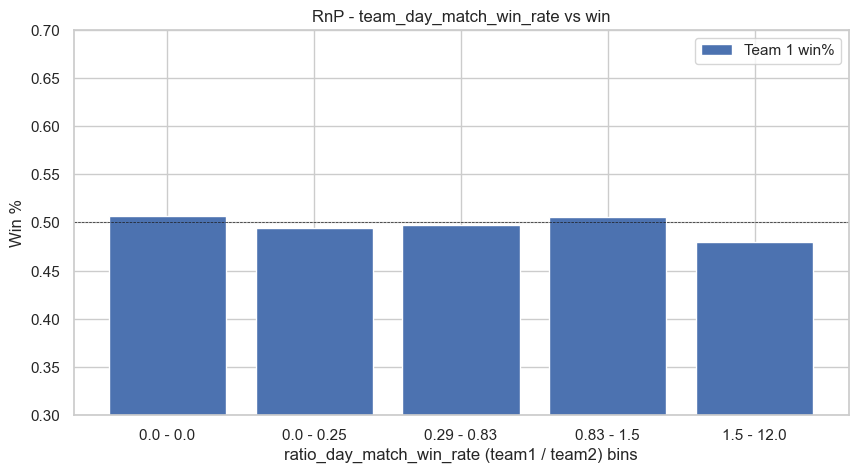

Correlation between team_day_match_win_rate and winner_01 is: -0.005042202808739653


In [79]:
createRnP(train_data, 'team_day_match_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


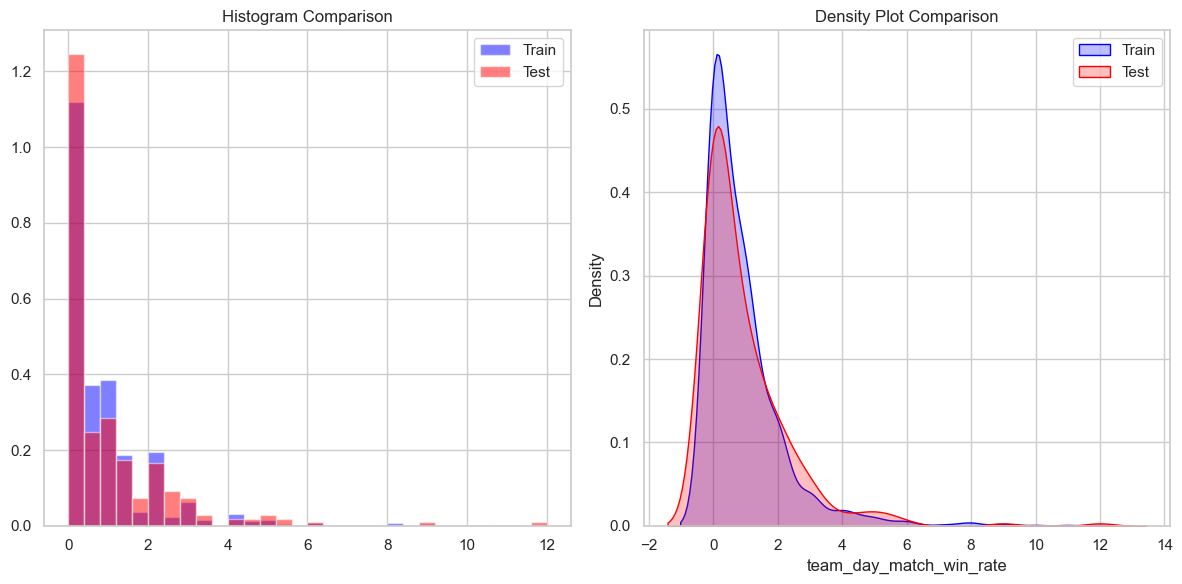

Kolmogorov-Smirnov test result: KS statistic = 0.0747, p-value = 0.1791

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.913478    0.947997
std       1.349556    1.452304
min       0.000000    0.000000
25%       0.001879    0.000000
50%       0.500000    0.400000
75%       1.200000    1.333333
max      12.000000   12.000000


In [80]:
check_distribution_match(train_data['team_day_match_win_rate'], test_data['team_day_match_win_rate'])

In [81]:
train_data['team1_day_night_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day/night match', x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_day_night_match_win_rate'] = train_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day/night match', x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_day_night_match_win_rate', 'team2_day_night_match_win_rate', 'team_day_night_match_win_rate')

train_data = train_data.drop(columns=['team1_day_night_match_win_rate', 'team2_day_night_match_win_rate'])

test_data['team1_day_night_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day/night match', x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_day_night_match_win_rate'] = test_data.apply(
    lambda x: lighting_performance(match_lvl_data, 'day/night match', x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_day_night_match_win_rate', 'team2_day_night_match_win_rate', 'team_day_night_match_win_rate')

test_data = test_data.drop(columns=['team1_day_night_match_win_rate', 'team2_day_night_match_win_rate'])

slope: 0.55 / 0.51 =  1.08


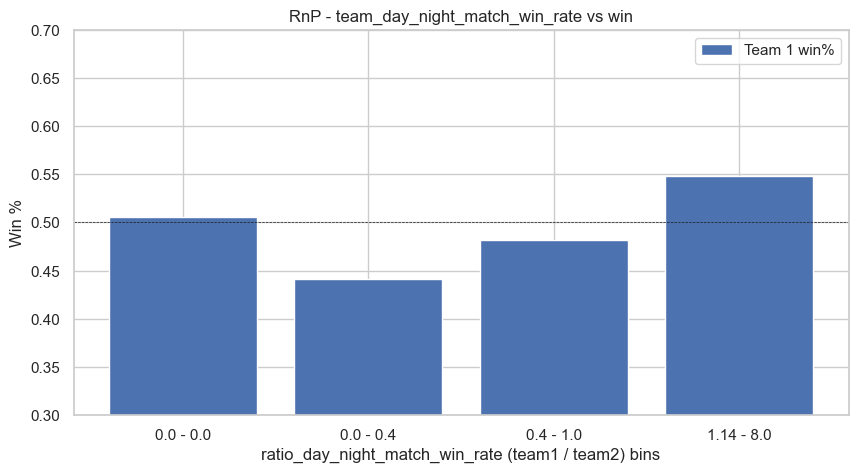

Correlation between team_day_night_match_win_rate and winner_01 is: -0.06474934446603657


In [82]:
createRnP(train_data, 'team_day_night_match_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


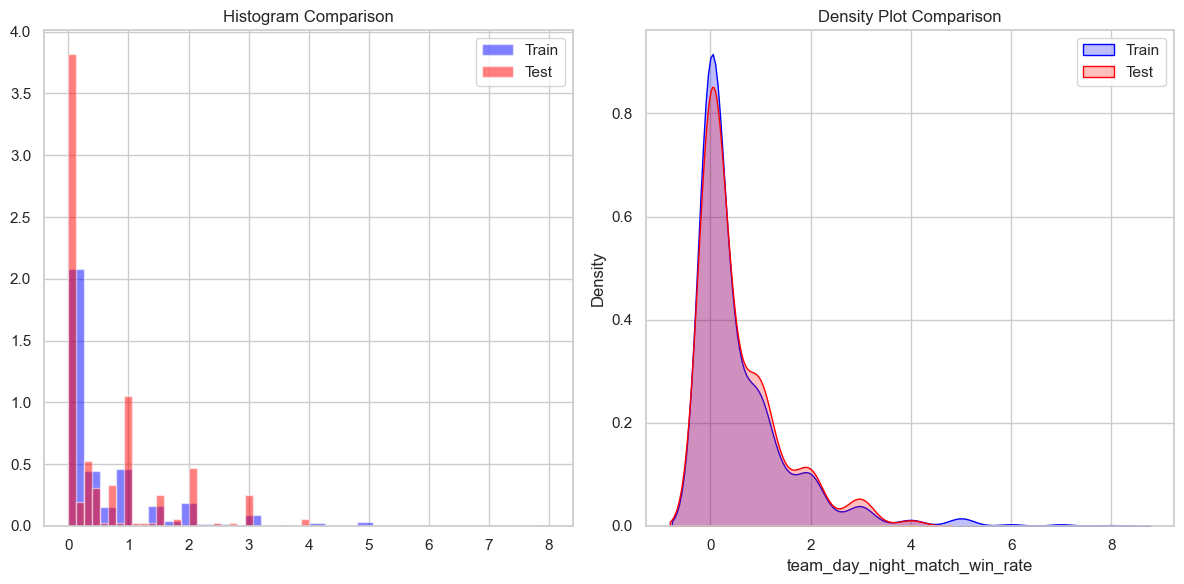

Kolmogorov-Smirnov test result: KS statistic = 0.0661, p-value = 0.2999

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.599584    0.576717
std       1.008230    0.827754
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.012780    0.027211
75%       1.000000    1.000000
max       8.000000    4.000000


In [83]:
check_distribution_match(train_data['team_day_night_match_win_rate'], test_data['team_day_night_match_win_rate'])

Feature 18

In [84]:
def adjusted_team_venue_win_rate(match_lvl_data, team_id, venue_id, date):
    # Filter matches at the venue for the specific team before the given date
    venue_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                   ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                   (match_lvl_data['match_dt'] < date)]
    # Calculate basic win rate
    wins = venue_matches[venue_matches['winner_id'] == team_id].shape[0]
    total = venue_matches.shape[0]
    win_rate = wins / total if total > 0 else 0

    # Adjust win rate by recent form (last 5 matches)
    recent_form = venue_matches.tail(5)
    recent_wins = recent_form[recent_form['winner_id'] == team_id].shape[0]
    recent_total = recent_form.shape[0]
    recent_win_rate = recent_wins / recent_total if recent_total > 0 else 0

    # Combine basic and recent win rates
    if total > 0:
        adjusted_win_rate = (win_rate * 0.75) + (recent_win_rate * 0.25)
    else:
        adjusted_win_rate = 0

    return adjusted_win_rate

In [85]:
train_data['team1_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
train_data['team2_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

test_data['team1_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
test_data['team2_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.19


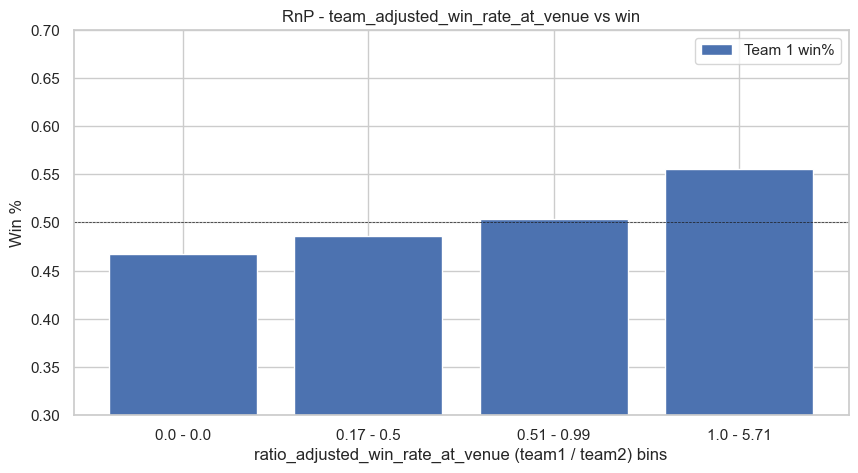

Correlation between team_adjusted_win_rate_at_venue and winner_01 is: -0.052518248499160855


In [86]:
createRnP(train_data, 'team_adjusted_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


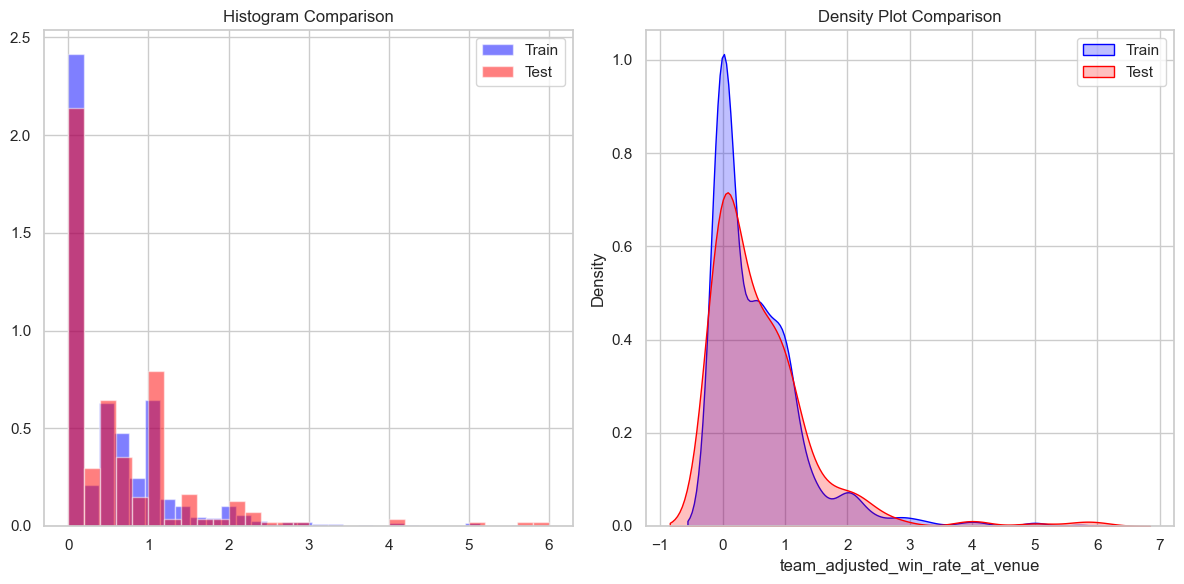

Kolmogorov-Smirnov test result: KS statistic = 0.0473, p-value = 0.7101

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.541013    0.609966
std       0.738334    0.864040
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.376339    0.421429
75%       0.925479    1.000000
max       5.714286    6.000000


In [87]:
check_distribution_match(train_data['team_adjusted_win_rate_at_venue'], test_data['team_adjusted_win_rate_at_venue'])

Feature 19

In [88]:
def overall_historical_win_rate(match_lvl_data, team_id, date):
    historical_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                        (match_lvl_data['match_dt'] < date)]
    wins = historical_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    total_matches = len(historical_matches)
    return wins / total_matches if total_matches > 0 else 0

In [89]:
train_data['team1_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

train_data = train_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

test_data['team1_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

test_data = test_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

slope: 0.57 / 0.43 =  1.33


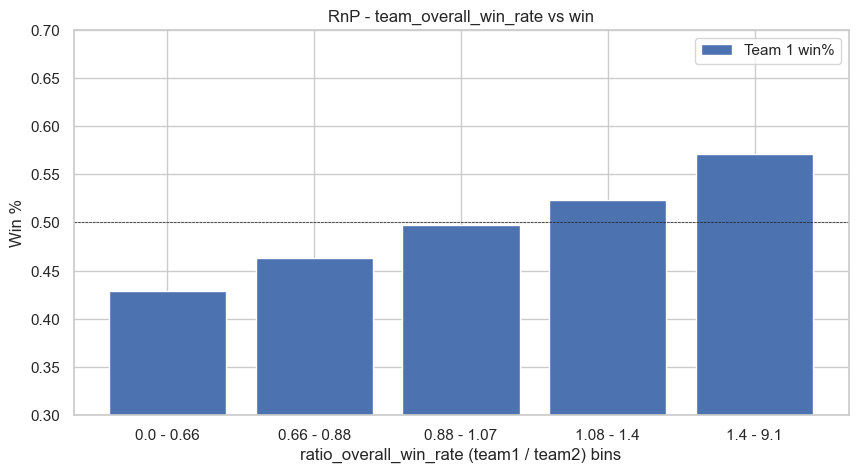

Correlation between team_overall_win_rate and winner_01 is: -0.0997730874267899


In [90]:
createRnP(train_data, 'team_overall_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


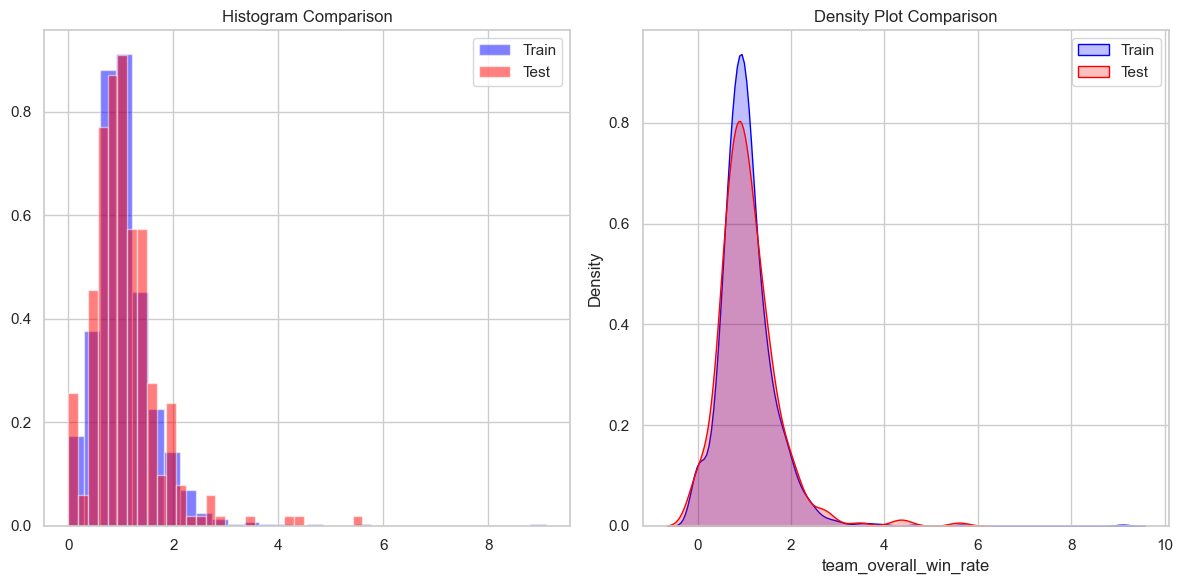

Kolmogorov-Smirnov test result: KS statistic = 0.0415, p-value = 0.8432

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.055088    1.078534
std       0.622973    0.670776
min       0.000000    0.000000
25%       0.717949    0.688018
50%       0.977346    0.969231
75%       1.285714    1.355731
max       9.100000    5.600000


In [91]:
check_distribution_match(train_data['team_overall_win_rate'], test_data['team_overall_win_rate'])

Feature 20

In [92]:
def recent_form(match_lvl_data, team_id, date):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(5)
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return wins / 5 if recent_matches.shape[0] > 0 else 0

In [93]:
train_data['team1_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

train_data = train_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

test_data['team1_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

test_data = test_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

slope: 0.53 / 0.44 =  1.21


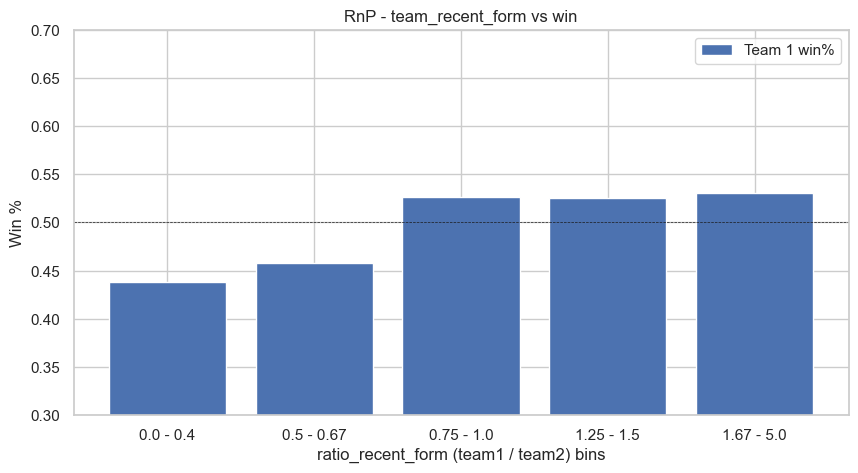

Correlation between team_recent_form and winner_01 is: -0.06215836793440212


In [94]:
createRnP(train_data, 'team_recent_form')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


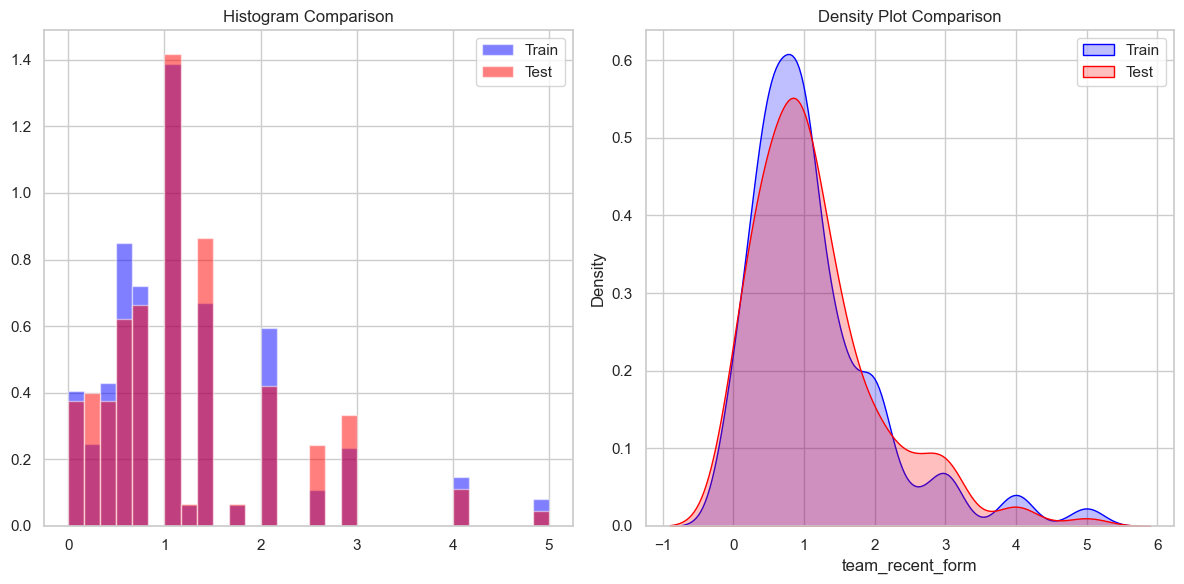

Kolmogorov-Smirnov test result: KS statistic = 0.0361, p-value = 0.9354

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.141842    1.164391
std       0.952862    0.917335
min       0.000000    0.000000
25%       0.500000    0.500000
50%       1.000000    1.000000
75%       1.500000    1.500000
max       5.000000    5.000000


In [95]:
check_distribution_match(train_data['team_recent_form'], test_data['team_recent_form'])

Feature 21

In [96]:
def head_to_head_win_rate(match_lvl_data, team1_id, team2_id, date):
    head_to_head_matches = match_lvl_data[((match_lvl_data['team1_id'] == team1_id) & (match_lvl_data['team2_id'] == team2_id) |
                                           (match_lvl_data['team1_id'] == team2_id) & (match_lvl_data['team2_id'] == team1_id)) &
                                          (match_lvl_data['match_dt'] < date)]
    wins = head_to_head_matches['winner_id'].apply(lambda x: 1 if x == team1_id else 0).sum()
    total = len(head_to_head_matches)
    return wins / total if total > 0 else 0

In [97]:
train_data['team_head_to_head_win_rate'] = train_data.apply(
    lambda x: head_to_head_win_rate(match_lvl_data, x['team1_id'], x['team2_id'], x['match_dt']),
    axis=1
)

test_data['team_head_to_head_win_rate'] = test_data.apply(
    lambda x: head_to_head_win_rate(match_lvl_data, x['team1_id'], x['team2_id'], x['match_dt']),
    axis=1
)

slope: 0.53 / 0.45 =  1.17


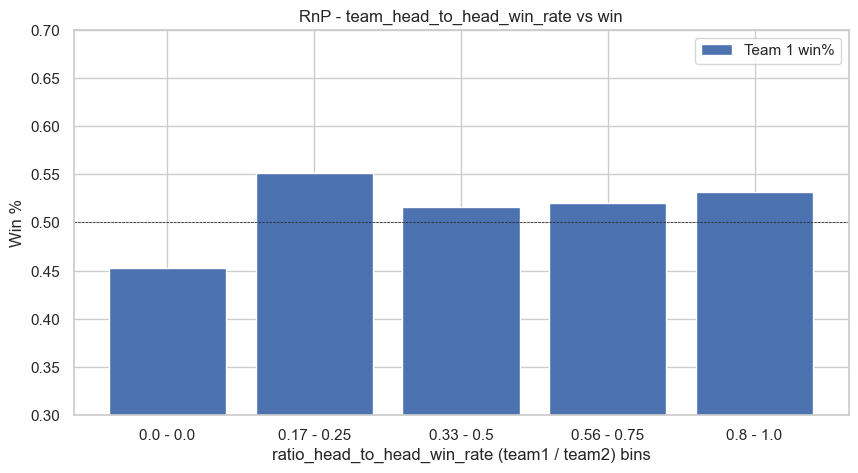

Correlation between team_head_to_head_win_rate and winner_01 is: -0.06060471536452742


In [98]:
createRnP(train_data, 'team_head_to_head_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


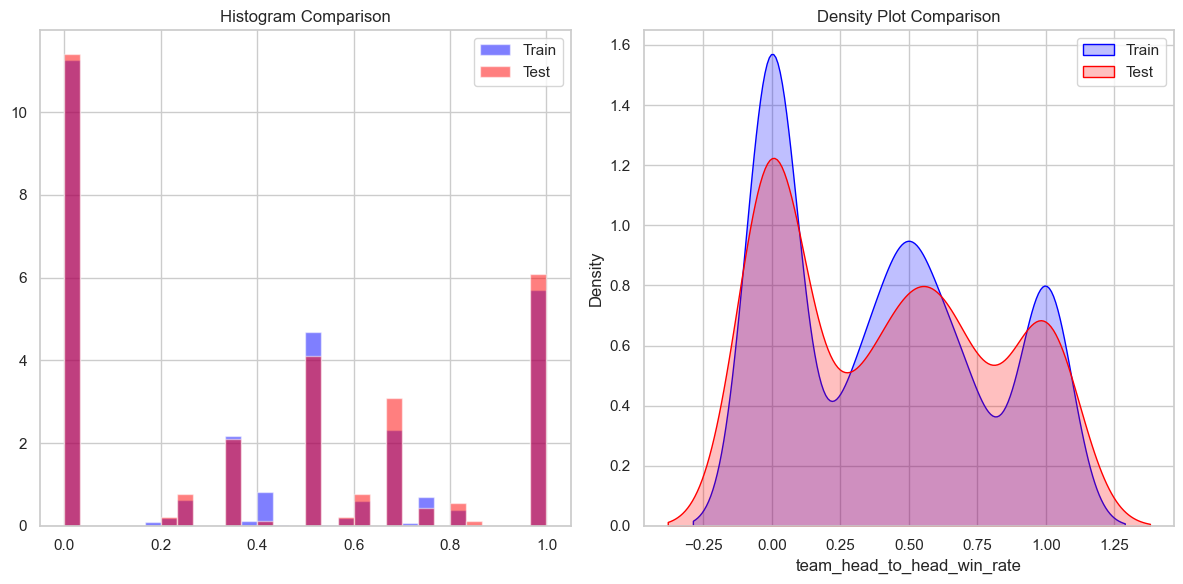

Kolmogorov-Smirnov test result: KS statistic = 0.0452, p-value = 0.7618

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.409052    0.421716
std       0.377966    0.388013
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.400000    0.500000
75%       0.666667    0.666667
max       1.000000    1.000000


In [99]:
check_distribution_match(train_data['team_head_to_head_win_rate'], test_data['team_head_to_head_win_rate'])

Feature 22

In [100]:
def adjusted_venue_win_rate_with_recent_form(match_lvl_data, team_id, venue_id, date):
    # Historical win rate at the venue
    venue_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                   ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                   (match_lvl_data['match_dt'] < date)]
    venue_wins = venue_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    venue_total = len(venue_matches)

    # Recent form (last 5 matches overall)
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(5)
    recent_wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    recent_total = len(recent_matches)

    # Combine both metrics
    venue_win_rate = venue_wins / venue_total if venue_total > 0 else 0
    recent_win_rate = recent_wins / recent_total if recent_total > 0 else 0
    adjusted_win_rate = 0.7 * venue_win_rate + 0.3 * recent_win_rate  # Weighted average

    return adjusted_win_rate

In [101]:
train_data['team1_adjusted_venue_win_rate'] = train_data.apply(
    lambda x: adjusted_venue_win_rate_with_recent_form(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
train_data['team2_adjusted_venue_win_rate'] = train_data.apply(
    lambda x: adjusted_venue_win_rate_with_recent_form(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_adjusted_venue_win_rate', 'team2_adjusted_venue_win_rate', 'team_adjusted_venue_win_rate')

train_data = train_data.drop(columns=['team1_adjusted_venue_win_rate', 'team2_adjusted_venue_win_rate'])

test_data['team1_adjusted_venue_win_rate'] = test_data.apply(
    lambda x: adjusted_venue_win_rate_with_recent_form(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
test_data['team2_adjusted_venue_win_rate'] = test_data.apply(
    lambda x: adjusted_venue_win_rate_with_recent_form(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_adjusted_venue_win_rate', 'team2_adjusted_venue_win_rate', 'team_adjusted_venue_win_rate')

test_data = test_data.drop(columns=['team1_adjusted_venue_win_rate', 'team2_adjusted_venue_win_rate'])

slope: 0.54 / 0.43 =  1.25


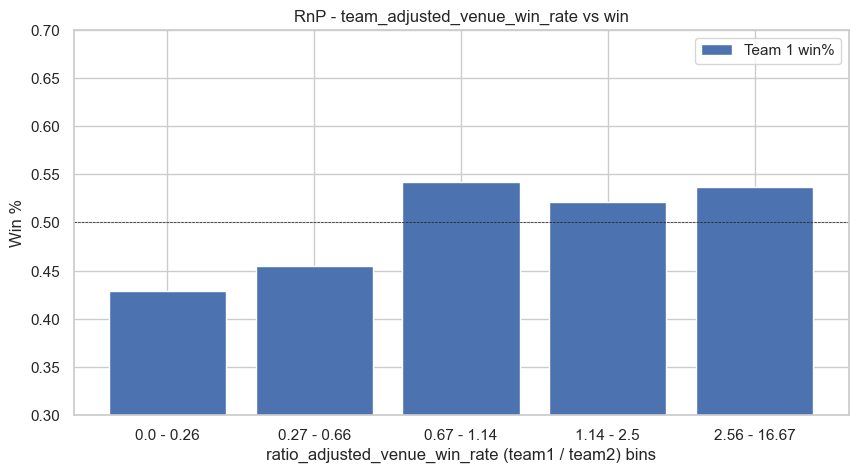

Correlation between team_adjusted_venue_win_rate and winner_01 is: -0.06461443189821502


In [102]:
createRnP(train_data, 'team_adjusted_venue_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


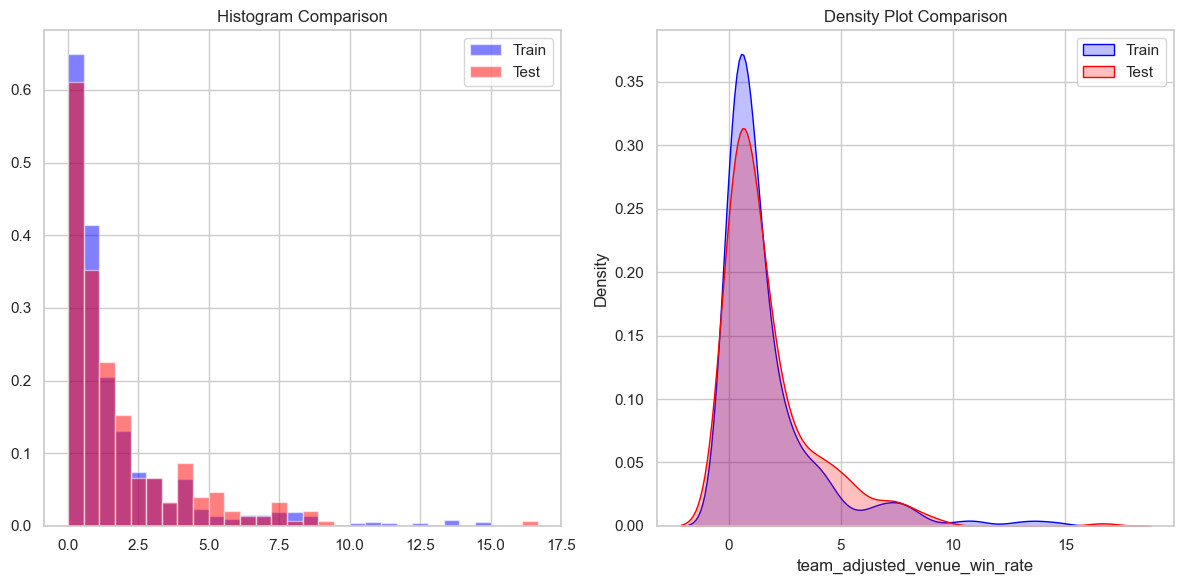

Kolmogorov-Smirnov test result: KS statistic = 0.0668, p-value = 0.2884

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.723801    1.811804
std       2.357491    2.176770
min       0.000000    0.000000
25%       0.339623    0.365854
50%       0.964356    1.000000
75%       2.000000    2.398936
max      16.666667   16.666667


In [103]:
check_distribution_match(train_data['team_adjusted_venue_win_rate'], test_data['team_adjusted_venue_win_rate'])

Feature 23

In [104]:
def scoring_consistency(match_lvl_data, team_id, date):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(10)
    runs_scored = recent_matches.apply(lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1)
    if len(runs_scored) > 0:
        mean_runs = runs_scored.mean()
        variance = runs_scored.var()
        consistency_index = mean_runs / variance if variance != 0 else mean_runs
    else:
        consistency_index = 0
    return consistency_index

In [105]:
train_data['team1_scoring_consistency'] = train_data.apply(
    lambda x: scoring_consistency(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_scoring_consistency'] = train_data.apply(
    lambda x: scoring_consistency(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_scoring_consistency', 'team2_scoring_consistency', 'team_scoring_consistency')

train_data = train_data.drop(columns=['team1_scoring_consistency', 'team2_scoring_consistency'])

test_data['team1_scoring_consistency'] = test_data.apply(
    lambda x: scoring_consistency(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_scoring_consistency'] = test_data.apply(
    lambda x: scoring_consistency(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_scoring_consistency', 'team2_scoring_consistency', 'team_scoring_consistency')

test_data = test_data.drop(columns=['team1_scoring_consistency', 'team2_scoring_consistency'])

slope: 0.51 / 0.45 =  1.11


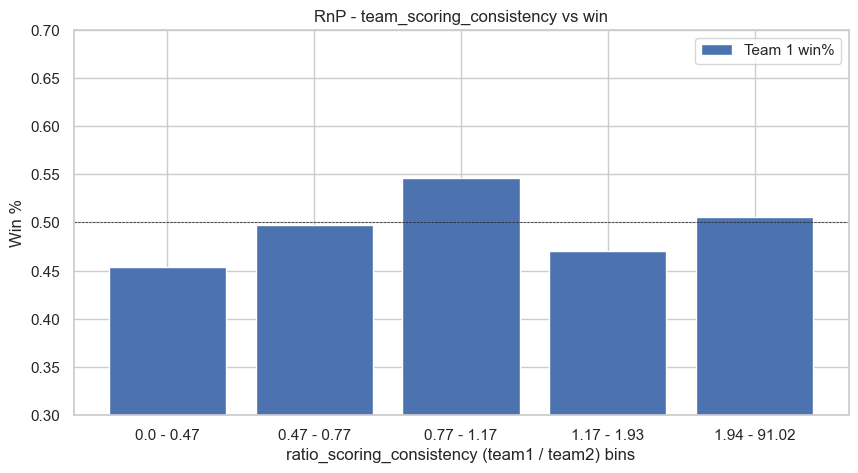

Correlation between team_scoring_consistency and winner_01 is: -0.01114275789882051


In [106]:
createRnP(train_data, 'team_scoring_consistency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


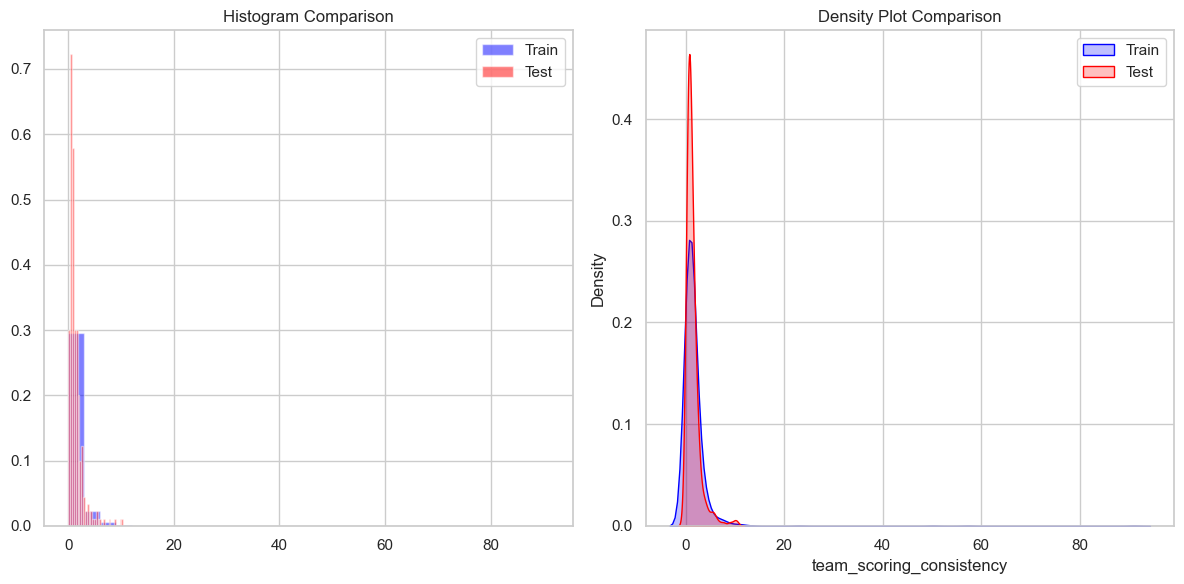

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   916.000000  260.000000
mean      1.640561    1.389233
std       4.199373    1.484024
min       0.000000    0.000000
25%       0.533660    0.567464
50%       0.954585    0.930722
75%       1.662021    1.667493
max      91.022523   10.375851


In [107]:
check_distribution_match(train_data['team_scoring_consistency'], test_data['team_scoring_consistency'])

Feature 24

In [108]:
def wicket_loss_variance(match_lvl_data, team_id, date):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(10)
    wickets_lost = recent_matches.apply(lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1)
    variance = wickets_lost.var() if len(wickets_lost) > 0 else 0
    return variance

In [109]:
train_data['team1_wicket_loss_variance'] = train_data.apply(
    lambda x: wicket_loss_variance(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_wicket_loss_variance'] = train_data.apply(
    lambda x: wicket_loss_variance(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_wicket_loss_variance', 'team2_wicket_loss_variance', 'team_wicket_loss_variance')

train_data = train_data.drop(columns=['team1_wicket_loss_variance', 'team2_wicket_loss_variance'])

test_data['team1_wicket_loss_variance'] = test_data.apply(
    lambda x: wicket_loss_variance(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_wicket_loss_variance'] = test_data.apply(
    lambda x: wicket_loss_variance(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_wicket_loss_variance', 'team2_wicket_loss_variance', 'team_wicket_loss_variance')

test_data = test_data.drop(columns=['team1_wicket_loss_variance', 'team2_wicket_loss_variance'])

slope: 0.52 / 0.48 =  1.09


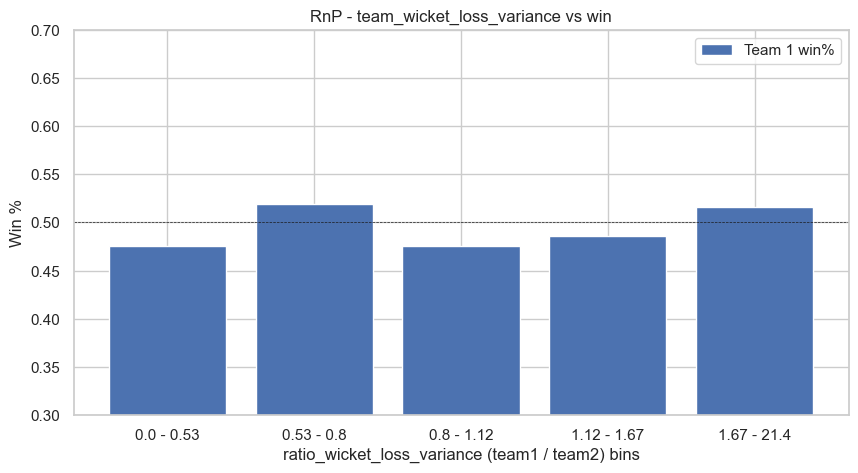

Correlation between team_wicket_loss_variance and winner_01 is: -0.038104624606281


In [110]:
createRnP(train_data, 'team_wicket_loss_variance')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


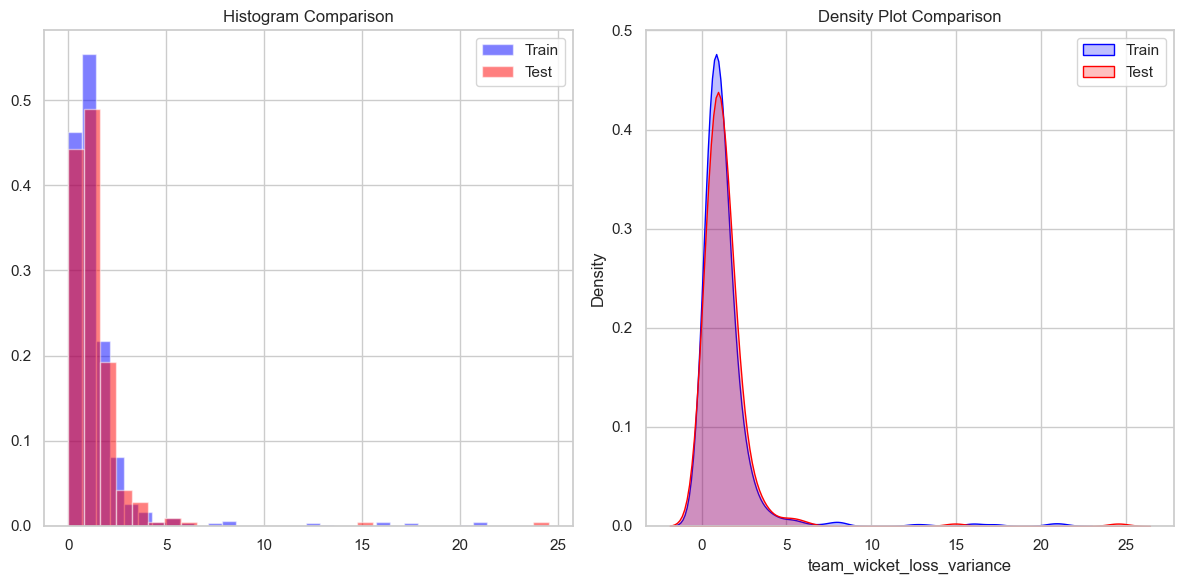

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   916.000000  260.000000
mean      1.395801    1.365298
std       2.101210    1.894115
min       0.000000    0.000000
25%       0.606278    0.647841
50%       0.963787    1.054051
75%       1.502998    1.607363
max      21.400000   24.533333


In [111]:
check_distribution_match(train_data['team_wicket_loss_variance'], test_data['team_wicket_loss_variance'])

Feature 25

In [112]:
def calculate_exponential_momentum(match_lvl_data, team_id, date, alpha=0.1):
    matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < date)].sort_values('match_dt', ascending=False)
    wins = matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).to_numpy()
    weights = np.exp(-alpha * np.arange(len(wins)))
    if np.sum(weights) > 0:
        momentum = np.dot(wins, weights) / np.sum(weights)
    else:
        momentum = 0  # Handle case with no matches
    return momentum

In [113]:
train_data['team1_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

train_data = train_data.drop(columns=['team1_momentum', 'team2_momentum'])

test_data['team1_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

test_data = test_data.drop(columns=['team1_momentum', 'team2_momentum'])

slope: 0.56 / 0.42 =  1.33


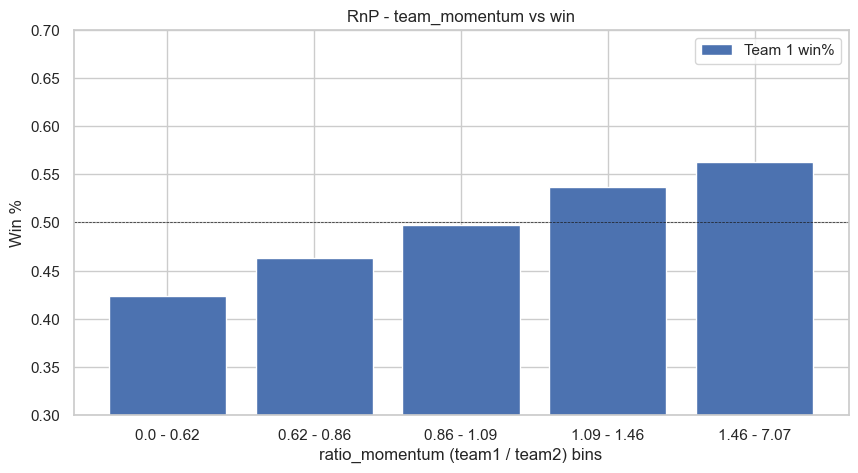

Correlation between team_momentum and winner_01 is: -0.09341226475457841


In [114]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


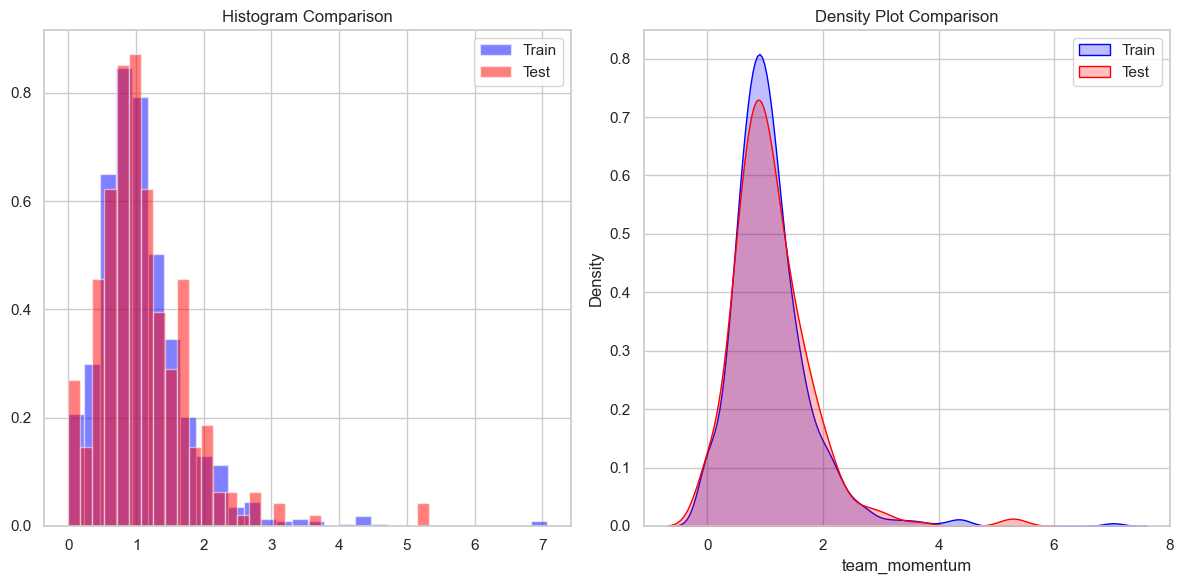

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.084422    1.105497
std       0.689988    0.701511
min       0.000000    0.000000
25%       0.682378    0.684016
50%       0.977013    0.987529
75%       1.347996    1.414583
max       7.065686    5.332317


In [115]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

Feature 26

In [116]:
def adjusted_win_rate_at_venue(match_lvl_data, team_id, venue, match_dt):
    # Filter matches for the team at this venue before this date
    relevant_matches = match_lvl_data[(match_lvl_data['venue'] == venue) &
                                      ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['match_dt'] < match_dt)]
    opponent_strengths = relevant_matches.apply(
        lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'] if x['team1_id'] == team_id else x['team1_id'], x['match_dt']),
        axis=1
    )
    wins = (relevant_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0) * opponent_strengths).sum()
    return wins / opponent_strengths.sum() if opponent_strengths.sum() > 0 else 0

In [117]:
train_data['team1_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_win_rate_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
train_data['team2_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_win_rate_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

test_data['team1_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_win_rate_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
test_data['team2_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_win_rate_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

slope: 0.55 / 0.47 =  1.18


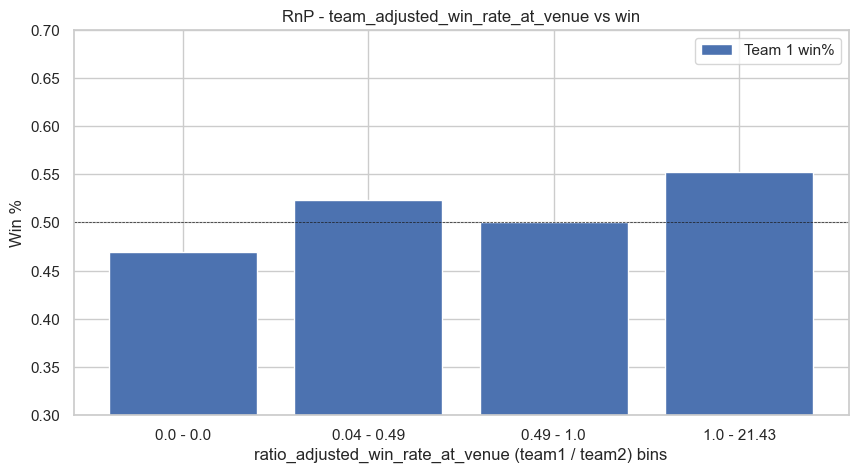

Correlation between team_adjusted_win_rate_at_venue and winner_01 is: -0.05554230632597651


In [118]:
createRnP(train_data, 'team_adjusted_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


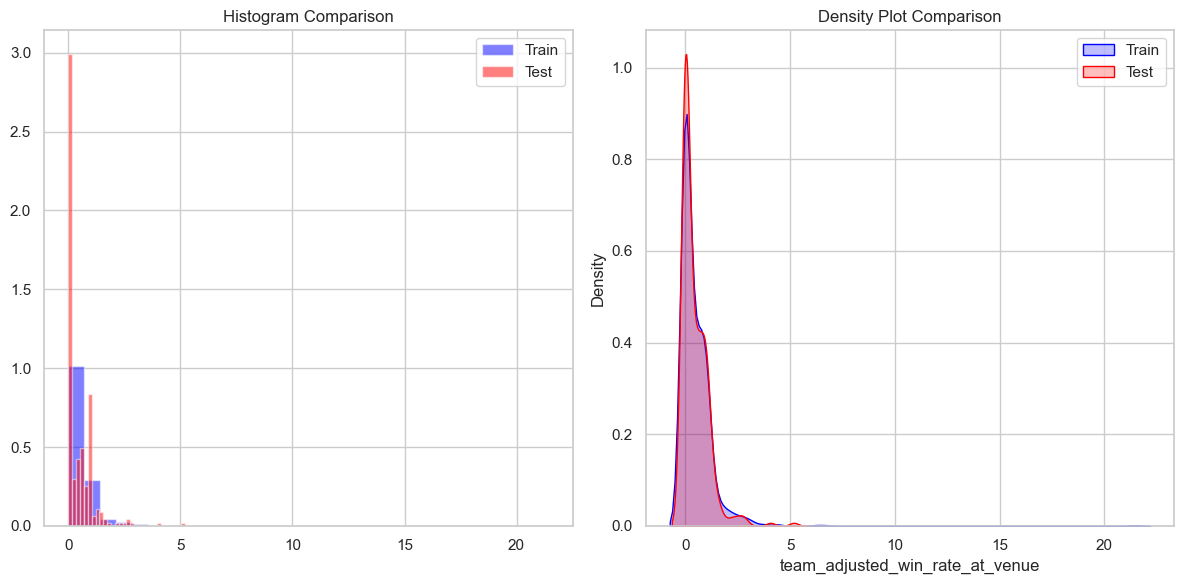

Kolmogorov-Smirnov test result: KS statistic = 0.0276, p-value = 0.9955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.486813    0.441416
std       0.973445    0.657201
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.000000    0.000000
75%       0.802675    0.726257
max      21.434676    5.180929


In [119]:
check_distribution_match(train_data['team_adjusted_win_rate_at_venue'], test_data['team_adjusted_win_rate_at_venue'])

Feature 27

In [120]:
def performance_after_loss(match_lvl_data, team_id, match_dt):
    past_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                  (match_lvl_data['match_dt'] < match_dt)].sort_values(by='match_dt', ascending=False)
    if not past_matches.empty and past_matches.iloc[0]['winner_id'] != team_id:
        # Find next match result
        if past_matches.shape[0] > 1:
            return 1 if past_matches.iloc[1]['winner_id'] == team_id else 0
    return None  # Not applicable if no match after a loss

In [121]:
train_data['team1_post_loss_performance'] = train_data.apply(
    lambda x: performance_after_loss(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_post_loss_performance'] = train_data.apply(
    lambda x: performance_after_loss(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_post_loss_performance', 'team2_post_loss_performance', 'team_post_loss_performance')

train_data = train_data.drop(columns=['team1_post_loss_performance', 'team2_post_loss_performance'])

test_data['team1_post_loss_performance'] = test_data.apply(
    lambda x: performance_after_loss(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_post_loss_performance'] = test_data.apply(
    lambda x: performance_after_loss(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_post_loss_performance', 'team2_post_loss_performance', 'team_post_loss_performance')

test_data = test_data.drop(columns=['team1_post_loss_performance', 'team2_post_loss_performance'])

slope: 0.56 / 0.46 =  1.22


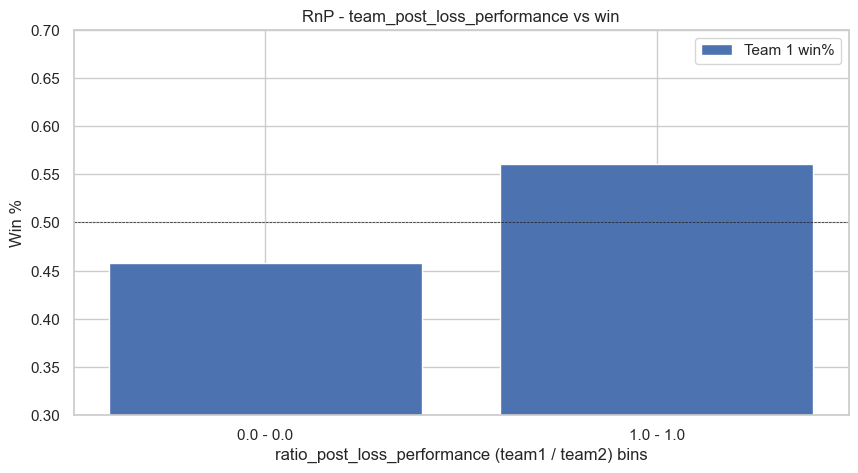

Correlation between team_post_loss_performance and winner_01 is: -0.10216565376752294


In [122]:
createRnP(train_data, 'team_post_loss_performance')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


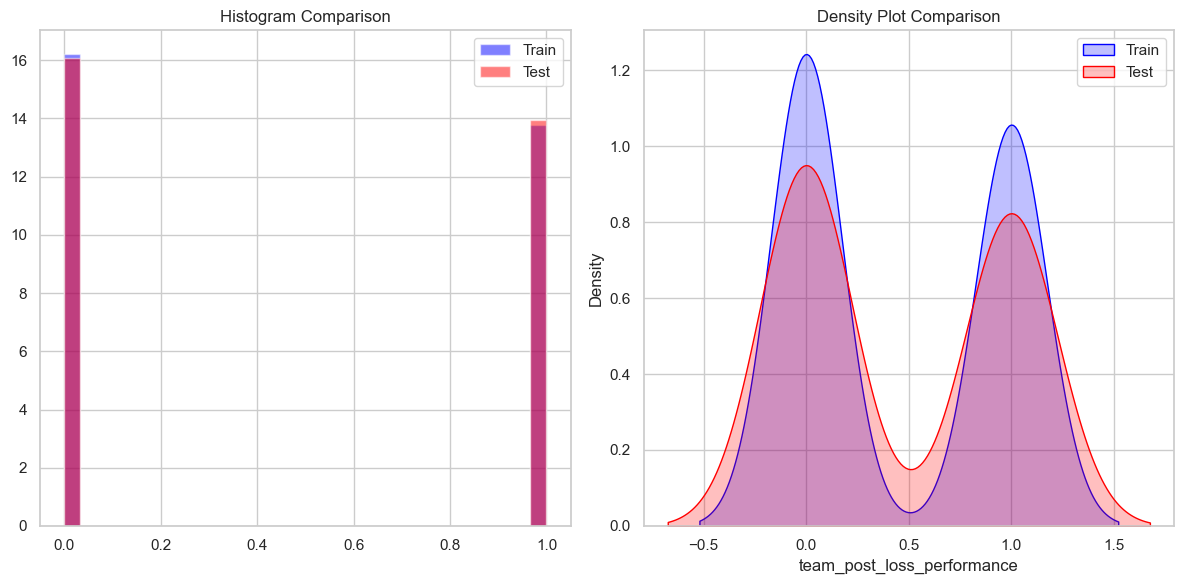

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   198.000000   56.000000
mean      0.459596    0.464286
std       0.499628    0.503236
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.000000    0.000000
75%       1.000000    1.000000
max       1.000000    1.000000


In [123]:
check_distribution_match(train_data['team_post_loss_performance'], test_data['team_post_loss_performance'])

Feature 28

In [124]:
def scoring_variance_at_venue(match_lvl_data, team_id, venue, match_dt):
    scores = match_lvl_data[((match_lvl_data['venue'] == venue) &
                             ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < match_dt))].apply(
        lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'],
        axis=1
    )
    if len(scores) > 1:
        return np.var(scores)
    return None  # Not applicable if fewer than 2 scores

In [125]:
train_data['team1_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
train_data['team2_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

train_data = train_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

test_data['team1_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
test_data['team2_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

test_data = test_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

slope: 0.67 / 0.42 =  1.6


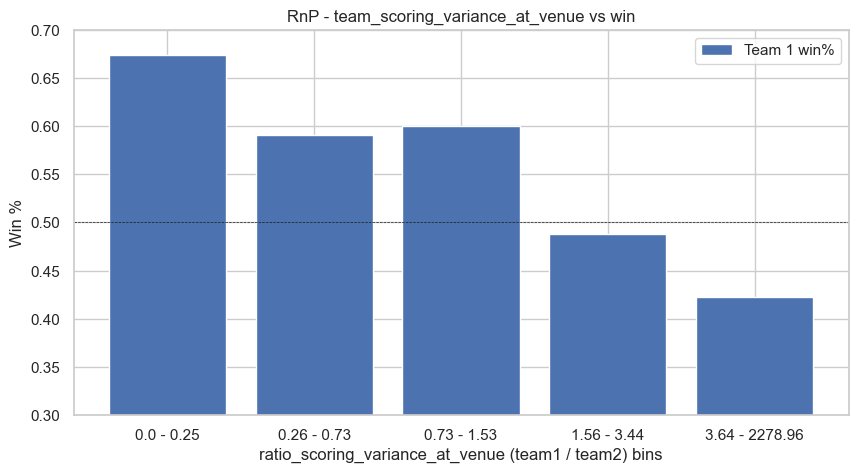

Correlation between team_scoring_variance_at_venue and winner_01 is: 0.07382813750939758


In [126]:
createRnP(train_data, 'team_scoring_variance_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


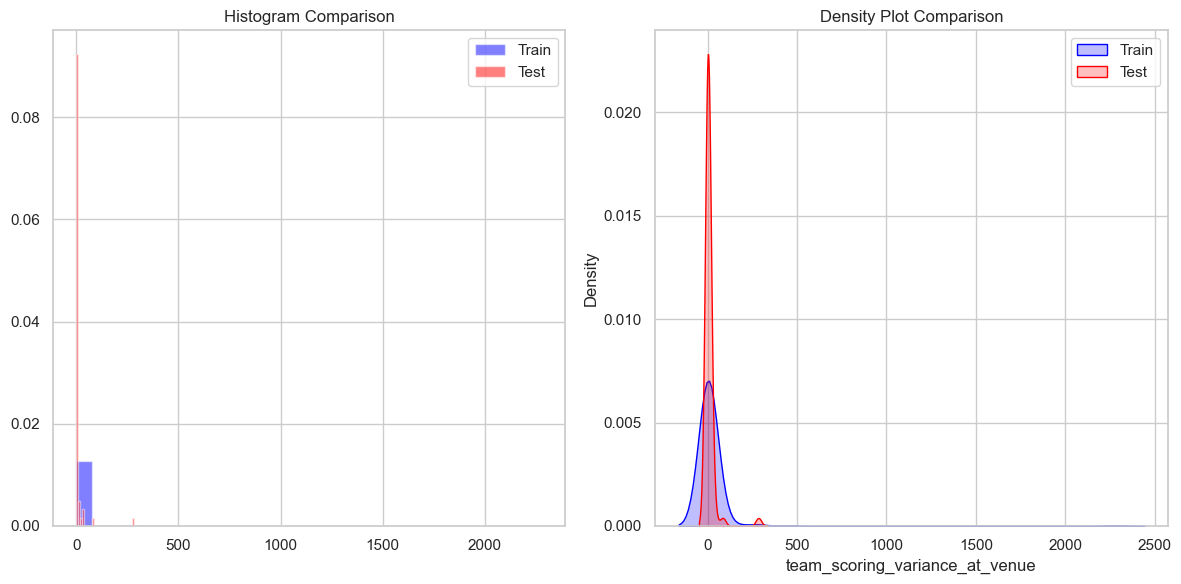

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   220.000000   64.000000
mean     20.670464    8.811408
std     159.135882   36.995710
min       0.002268    0.000000
25%       0.391702    0.410554
50%       1.154405    1.040817
75%       2.456717    2.601452
max    2278.958333  284.305556


In [127]:
check_distribution_match(train_data['team_scoring_variance_at_venue'], test_data['team_scoring_variance_at_venue'])

Feature 29

In [128]:
def team_batsman_performance_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 4.5 +
                                  recent_matches['strike_rate'] * 2.5 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] ) * 1.5) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [129]:
train_data['team1_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

train_data = train_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

test_data['team1_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

test_data = test_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

slope: 0.58 / 0.35 =  1.65


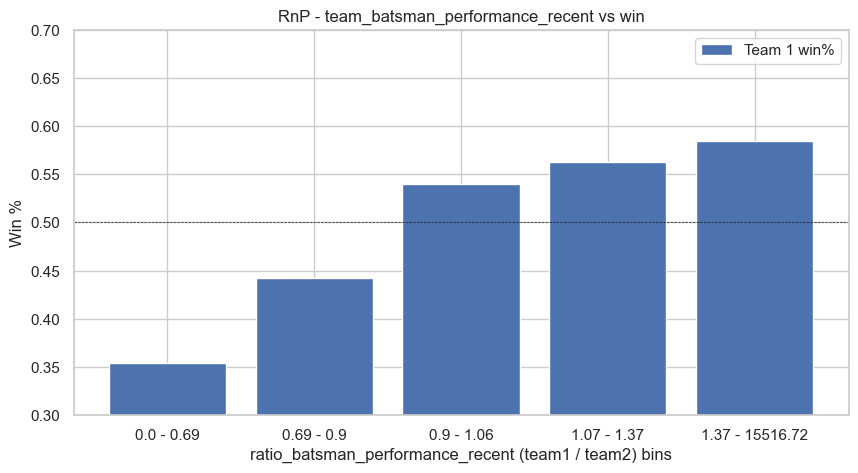

Correlation between team_batsman_performance_recent and winner_01 is: -0.04340818347684576


In [130]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


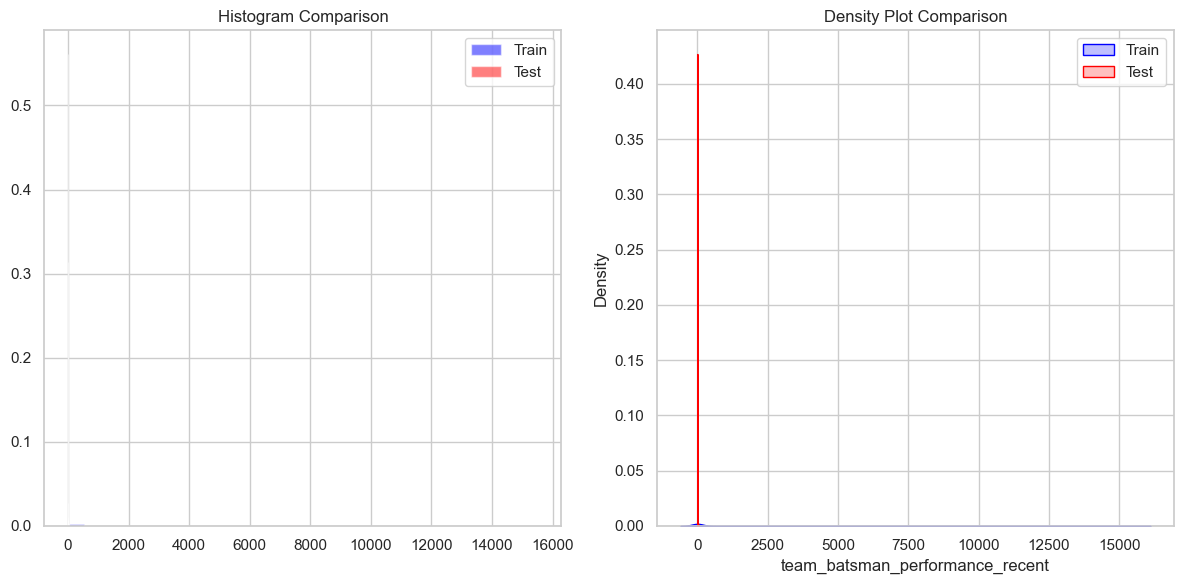

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean      60.915898    1.406714
std      785.743925    2.404311
min        0.000000    0.000000
25%        0.758679    0.748565
50%        0.977252    0.954295
75%        1.264147    1.312189
max    15516.725000   31.760455


In [131]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

Feature 30

In [132]:
def team_batsman_runs_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] ) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [133]:
train_data['team1_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

train_data = train_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

test_data['team1_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

test_data = test_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

slope: 0.63 / 0.34 =  1.87


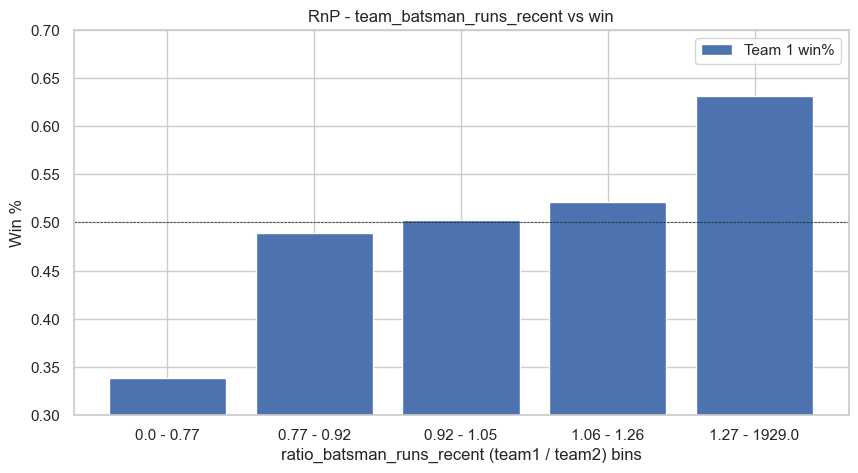

Correlation between team_batsman_runs_recent and winner_01 is: -0.05063885076794448


In [134]:
createRnP(train_data, 'team_batsman_runs_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


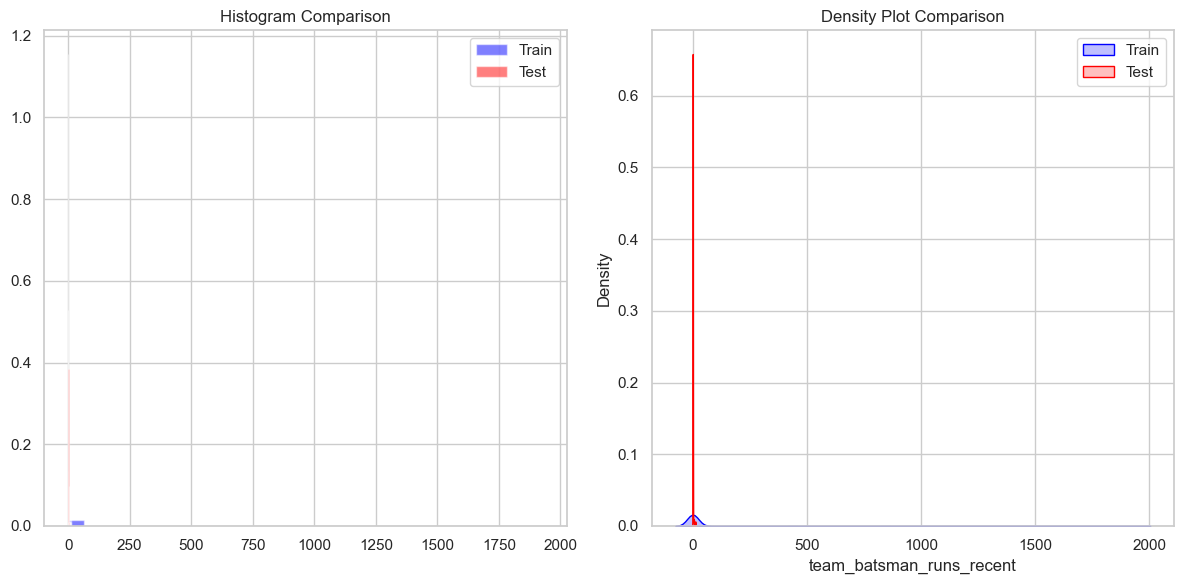

Kolmogorov-Smirnov test result: KS statistic = 0.0556, p-value = 0.5113

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      8.322739    1.270554
std      97.981448    1.435869
min       0.000000    0.000000
25%       0.815550    0.815097
50%       0.978937    0.993631
75%       1.190198    1.239880
max    1929.000000   12.362069


In [135]:
check_distribution_match(train_data['team_batsman_runs_recent'], test_data['team_batsman_runs_recent'])

Feature 31

In [136]:
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [137]:
def teamAvgRunsLastn(team_id, date, n):
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean()

In [138]:
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

train_data['team2only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1only_avg_runs_last15', 'team2only_avg_runs_last15', 'team_avg_runs_last15')

# train_data = train_data.drop(columns=['team1only_avg_runs_last15', 'team2only_avg_runs_last15'])

test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

test_data['team2only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1only_avg_runs_last15', 'team2only_avg_runs_last15', 'team_avg_runs_last15')

# test_data = test_data.drop(columns=['team1only_avg_runs_last15', 'team2only_avg_runs_last15'])

100%|██████████| 271/271 [00:00<00:00, 452.86it/s]


slope: 0.49 / 0.44 =  1.12


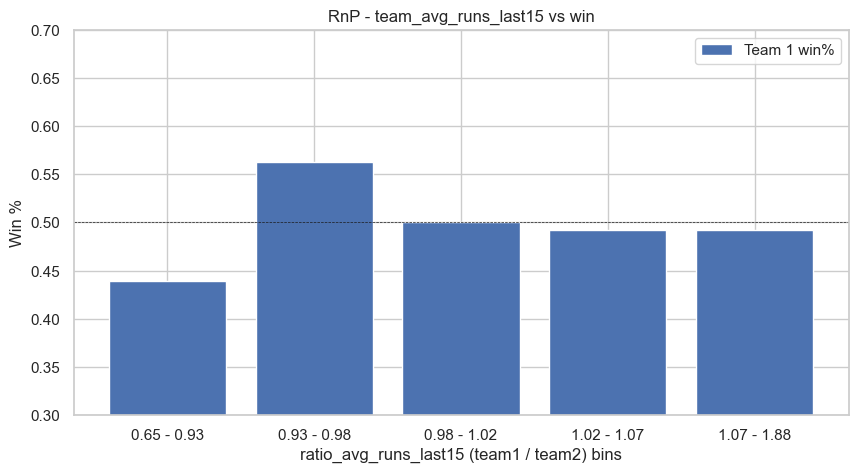

Correlation between team_avg_runs_last15 and winner_01 is: -0.006697902761351899


In [139]:
createRnP(train_data, 'team_avg_runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


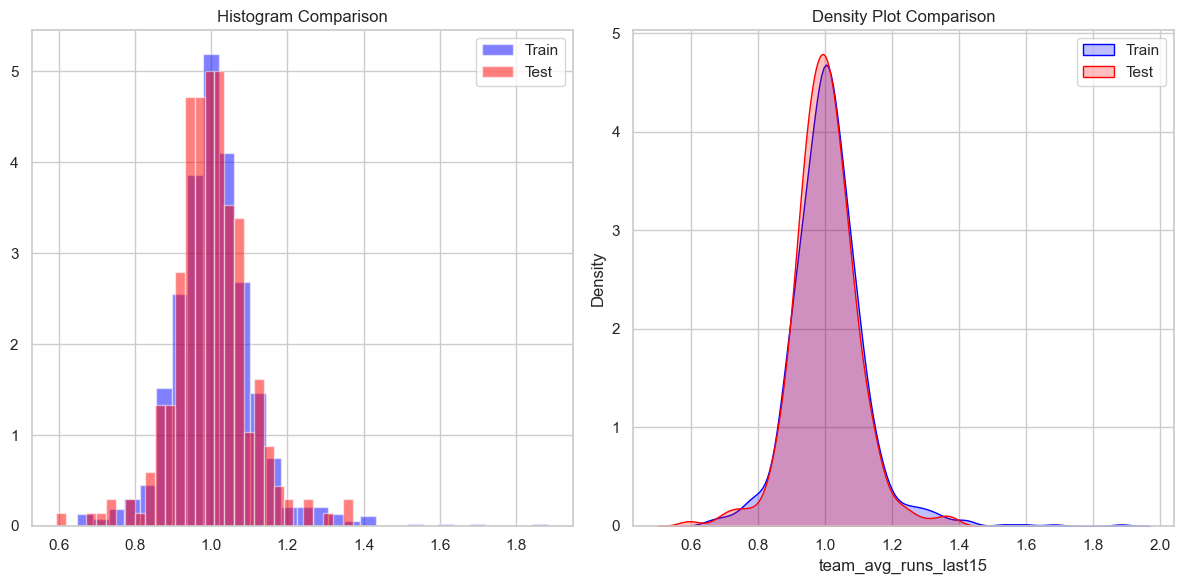

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   913.000000  262.000000
mean      1.008478    0.999040
std       0.110101    0.096271
min       0.649396    0.594000
25%       0.947489    0.947565
50%       1.003356    0.996737
75%       1.058465    1.049603
max       1.883621    1.371429


In [140]:
check_distribution_match(train_data['team_avg_runs_last15'], test_data['team_avg_runs_last15'])

In [141]:
train_data['team1run-ground_avg_runs'] = train_data['team1only_avg_runs_last15'] - train_data['ground_avg_runs_last15']
train_data['team2run-ground_avg_runs'] = train_data['team2only_avg_runs_last15'] - train_data['ground_avg_runs_last15']

train_data = add_ratio_column(train_data, 'team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team_ground_factor_ratio')

train_data = train_data.drop(columns=['team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team1only_avg_runs_last15', 'team2only_avg_runs_last15'])

test_data['team1run-ground_avg_runs'] = test_data['team1only_avg_runs_last15'] - test_data['ground_avg_runs_last15']
test_data['team2run-ground_avg_runs'] = test_data['team2only_avg_runs_last15'] - test_data['ground_avg_runs_last15']

test_data = add_ratio_column(test_data, 'team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team_ground_factor_ratio')

test_data = test_data.drop(columns=['team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team1only_avg_runs_last15', 'team2only_avg_runs_last15'])

slope: 0.49 / 0.46 =  1.07


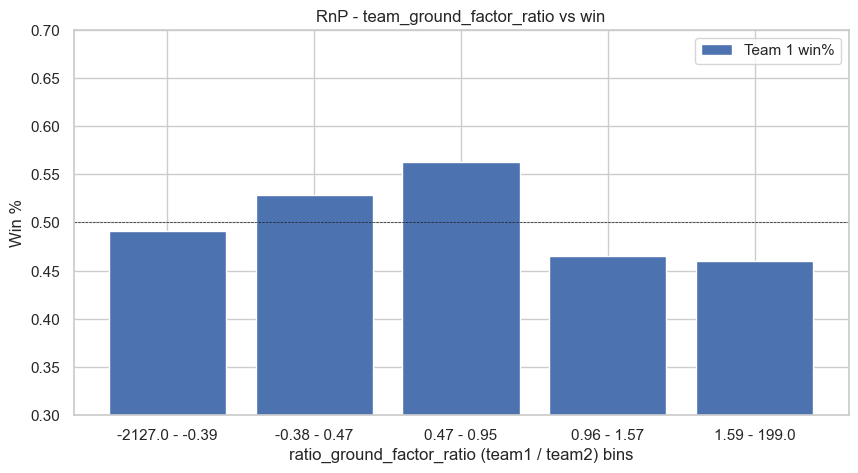

Correlation between team_ground_factor_ratio and winner_01 is: 0.030606731119674237


In [142]:
createRnP(train_data, 'team_ground_factor_ratio')

Feature 32

In [143]:
def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.

In [144]:
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)
train_data['team2_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team2_id'], x['team1_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_team2_last15', 'team2_winp_team2_last15', 'team_winp_team2_last15')

train_data = train_data.drop(columns=['team1_winp_team2_last15', 'team2_winp_team2_last15'])

test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)
test_data['team2_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team2_id'], x['team1_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_team2_last15', 'team2_winp_team2_last15', 'team_winp_team2_last15')

test_data = test_data.drop(columns=['team1_winp_team2_last15', 'team2_winp_team2_last15'])

100%|██████████| 271/271 [00:00<00:00, 1289.80it/s]


slope: 0.53 / 0.45 =  1.17


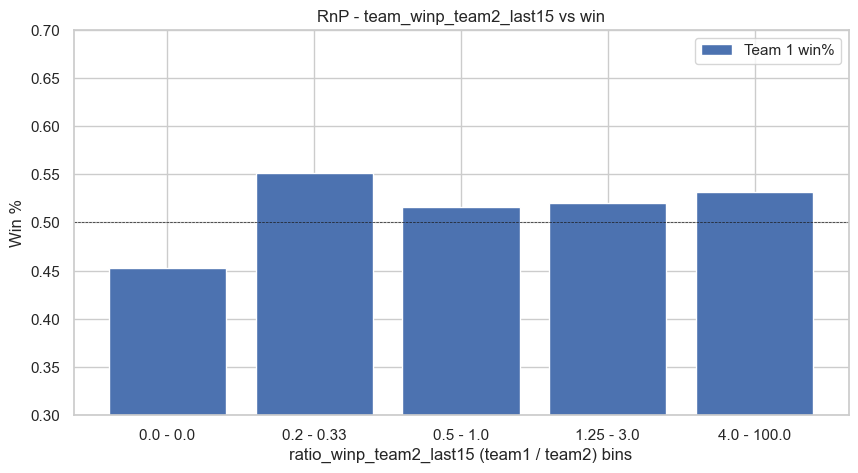

Correlation between team_winp_team2_last15 and winner_01 is: -0.031131207155308815


In [145]:
createRnP(train_data, 'team_winp_team2_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


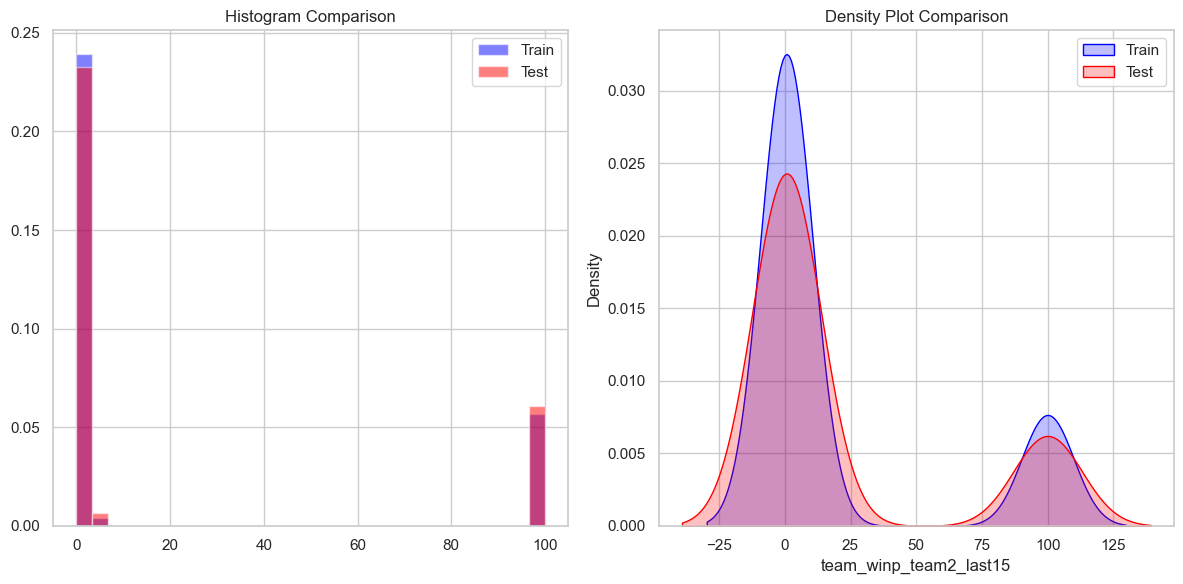

Kolmogorov-Smirnov test result: KS statistic = 0.0452, p-value = 0.7618

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean     19.530485   20.872055
std      38.985635   40.011871
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.666667    1.000000
75%       2.000300    2.000300
max     100.000000  100.000000


In [146]:
check_distribution_match(train_data['team_winp_team2_last15'], test_data['team_winp_team2_last15'])

Feature 33

In [147]:
def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [148]:
train_data['team1_winp_last10'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last10'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 10), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_last10', 'team2_winp_last10', 'team_winp_last10')

train_data = train_data.drop(columns=['team1_winp_last10', 'team2_winp_last10'])

test_data['team1_winp_last10'] = test_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
test_data['team2_winp_last10'] = test_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 10), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_last10', 'team2_winp_last10', 'team_winp_last10')

test_data = test_data.drop(columns=['team1_winp_last10', 'team2_winp_last10'])

100%|██████████| 271/271 [00:00<00:00, 1483.49it/s]


slope: 0.58 / 0.41 =  1.43


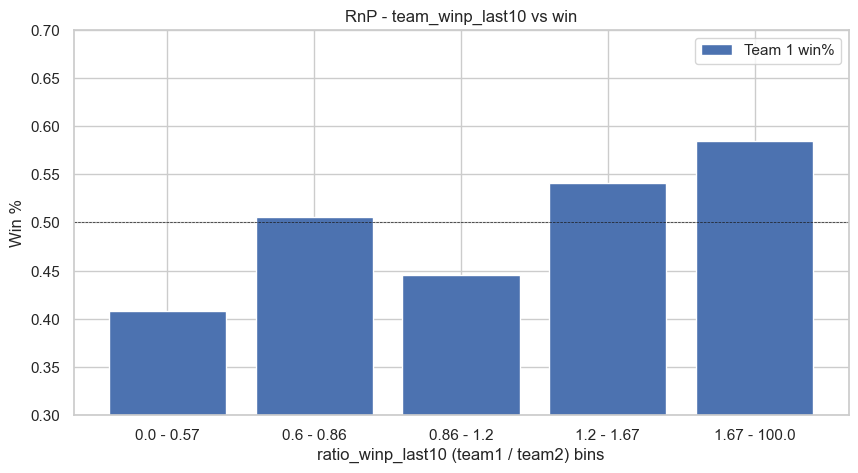

Correlation between team_winp_last10 and winner_01 is: -0.03783956884164148


In [149]:
createRnP(train_data, 'team_winp_last10')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


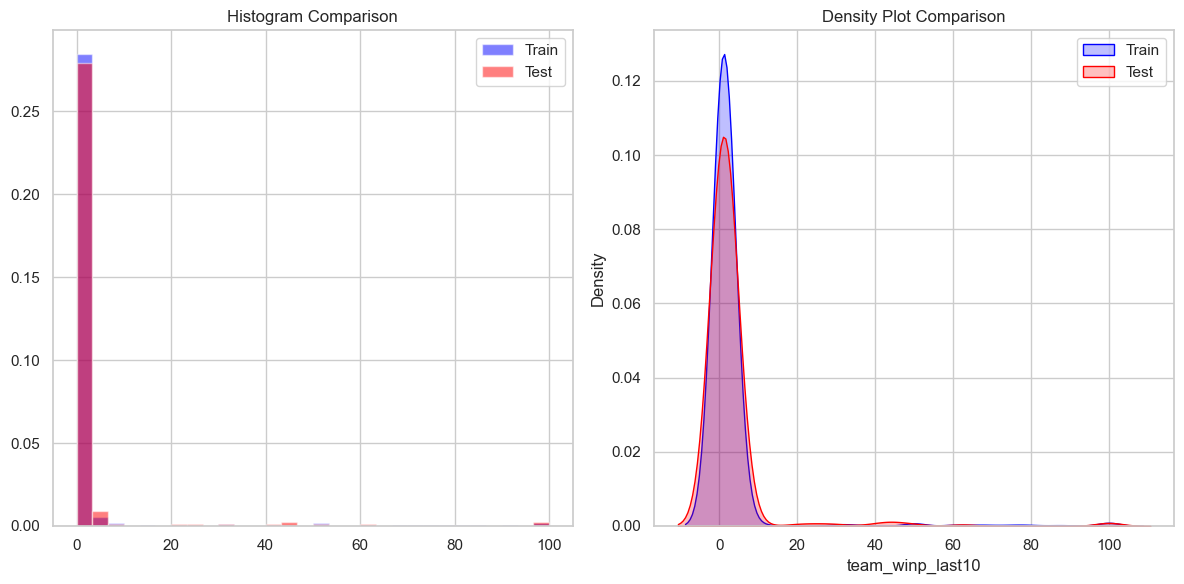

Kolmogorov-Smirnov test result: KS statistic = 0.0383, p-value = 0.9019

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.998773    3.073383
std      11.560068   10.877326
min       0.000000    0.000000
25%       0.666667    0.666667
50%       1.000000    1.000000
75%       1.500000    1.600000
max     100.000000  100.000000


In [150]:
check_distribution_match(train_data['team_winp_last10'], test_data['team_winp_last10'])

Feature 34

In [151]:
def team_economy_rate_recent(bowler_df, team_roster_ids, date, n=10):
    team_ids = str(team_roster_ids).split(':')
    total_runs_given = 0
    total_balls_bowled = 0
    
    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_runs_given += recent_matches['runs'].sum()
        total_balls_bowled += recent_matches['balls_bowled'].sum()

    if total_balls_bowled > 0:
        return (total_runs_given / total_balls_bowled) * 6
    return 0

In [152]:
train_data['team1_economy_rate_recent'] = train_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_economy_rate_recent'] = train_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_economy_rate_recent', 'team2_economy_rate_recent', 'team_economy_rate_recent')

train_data = train_data.drop(columns=['team1_economy_rate_recent', 'team2_economy_rate_recent'])

test_data['team1_economy_rate_recent'] = test_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_economy_rate_recent'] = test_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_economy_rate_recent', 'team2_economy_rate_recent', 'team_economy_rate_recent')

test_data = test_data.drop(columns=['team1_economy_rate_recent', 'team2_economy_rate_recent'])

slope: 0.48 / 0.48 =  1.01


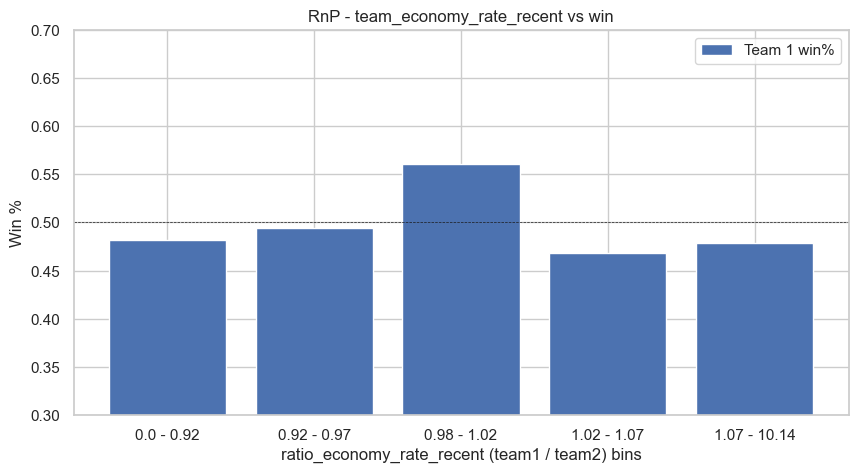

Correlation between team_economy_rate_recent and winner_01 is: -0.041420130484776996


In [153]:
createRnP(train_data, 'team_economy_rate_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


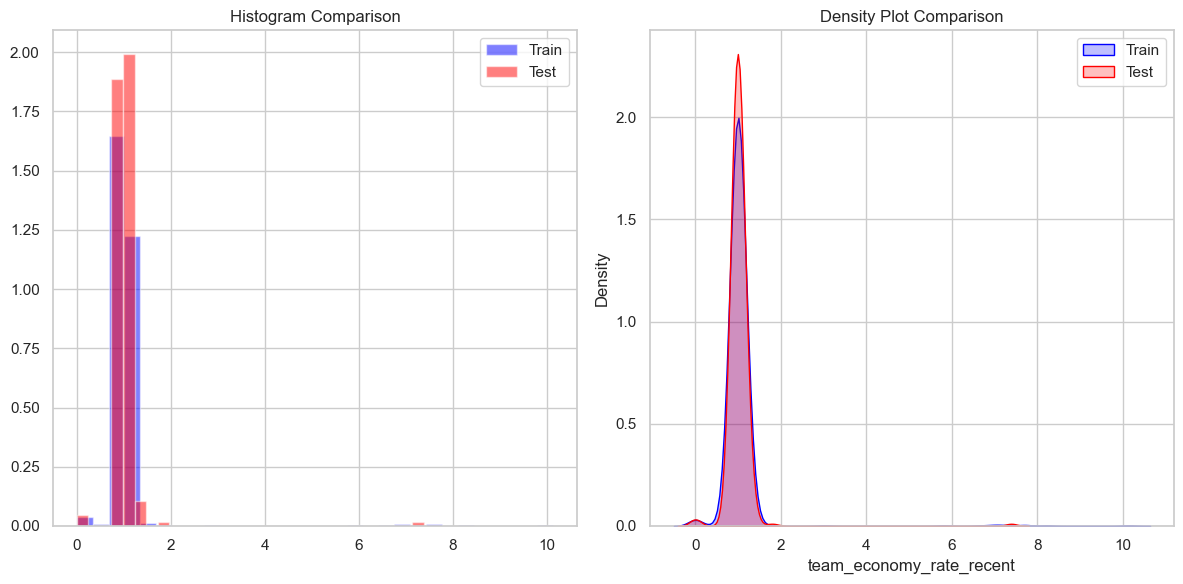

Kolmogorov-Smirnov test result: KS statistic = 0.0410, p-value = 0.8534

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.053477    1.017602
std       0.662709    0.418423
min       0.000000    0.000000
25%       0.935384    0.926498
50%       0.994524    0.990638
75%       1.061143    1.062396
max      10.136519    7.390244


In [154]:
check_distribution_match(train_data['team_economy_rate_recent'], test_data['team_economy_rate_recent'])

Feature 35

In [155]:
def player_of_match_frequency(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    pom_awards = 0
    total_matches = 0

    for player_id in team_ids:
        past_matches = matches[(matches['match_dt'] < date) & (matches['player_of_the_match_id'] == float(player_id))]
        pom_awards += past_matches.shape[0]
        total_matches += matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(str(player_id))) | (matches['team2_roster_ids'].str.contains(str(player_id))))].shape[0]

    return pom_awards / total_matches if total_matches > 0 else 0

In [156]:
train_data['team1_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

train_data = train_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

test_data['team1_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

test_data = test_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

slope: 0.53 / 0.39 =  1.36


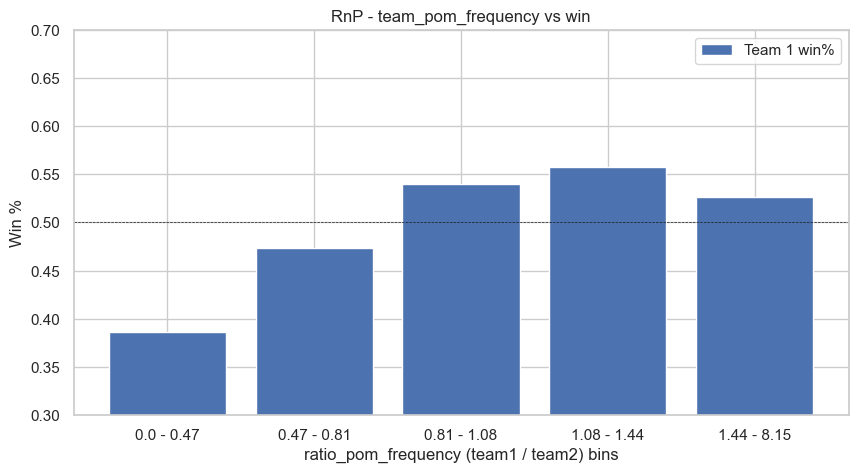

Correlation between team_pom_frequency and winner_01 is: -0.10387943593858757


In [157]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


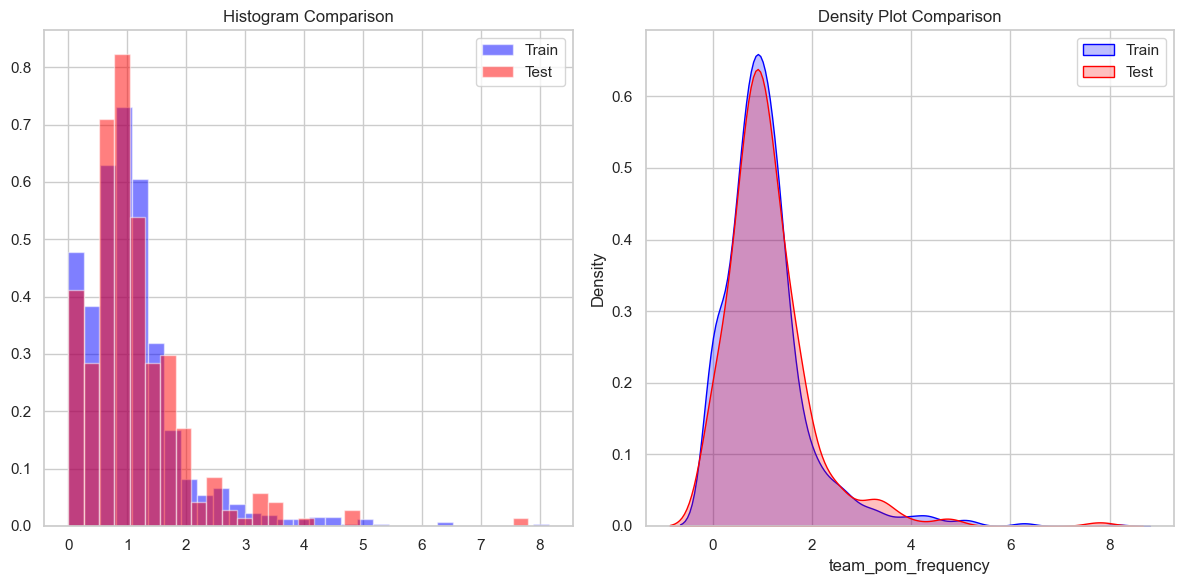

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.062113    1.116506
std       0.872368    0.888507
min       0.000000    0.000000
25%       0.575646    0.617815
50%       0.927612    0.960854
75%       1.323588    1.420928
max       8.151111    7.802120


In [158]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

Feature 36

In [159]:
def team_count_100runs_last15(matches, team1_roster, team2_roster, date, n=25):
    def count_100s(team_roster):
        total_100s = 0
        for player_id in team_roster.split(':'):
            player_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
            total_100s += (player_matches['runs'] >= 75).sum()
        return total_100s

    team1_100s = count_100s(team1_roster)
    team2_100s = count_100s(team2_roster)

    return team1_100s / team2_100s if team2_100s > 0 else team1_100s

In [160]:
train_data['team_count_100runs_ratio_last15'] = train_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team_count_100runs_ratio_last15'] = test_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)

slope: 0.59 / 0.4 =  1.48


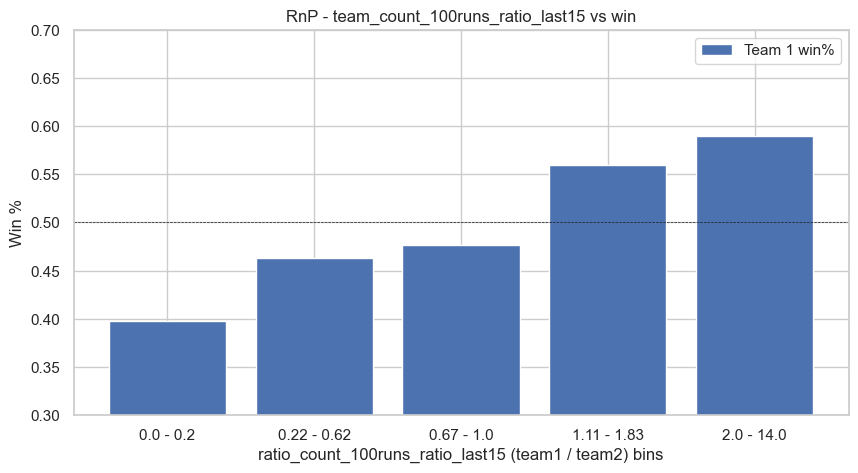

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14108232795000986


In [161]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


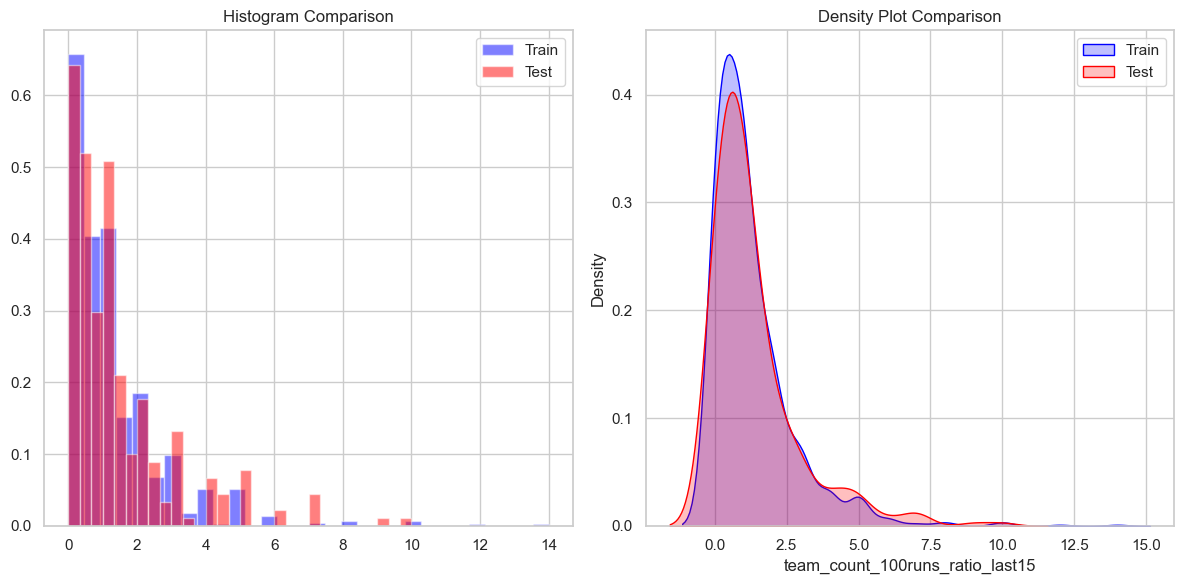

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.274676    1.365704
std       1.483916    1.597194
min       0.000000    0.000000
25%       0.333333    0.375000
50%       1.000000    1.000000
75%       1.750000    1.666667
max      14.000000   10.000000


In [162]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

Feature 37

In [163]:
def avg_extras_conceded(matches, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    total_extras = 0
    total_matches = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()
        total_matches += recent_matches.shape[0]

    return total_extras / total_matches if total_matches > 0 else 0

In [164]:
train_data['team1_avg_extras_conceded'] = train_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_extras_conceded'] = train_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_extras_conceded', 'team2_avg_extras_conceded', 'team_avg_extras_conceded')

train_data = train_data.drop(columns=['team1_avg_extras_conceded', 'team2_avg_extras_conceded'])

test_data['team1_avg_extras_conceded'] = test_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_extras_conceded'] = test_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_extras_conceded', 'team2_avg_extras_conceded', 'team_avg_extras_conceded')

test_data = test_data.drop(columns=['team1_avg_extras_conceded', 'team2_avg_extras_conceded'])

slope: 0.51 / 0.45 =  1.15


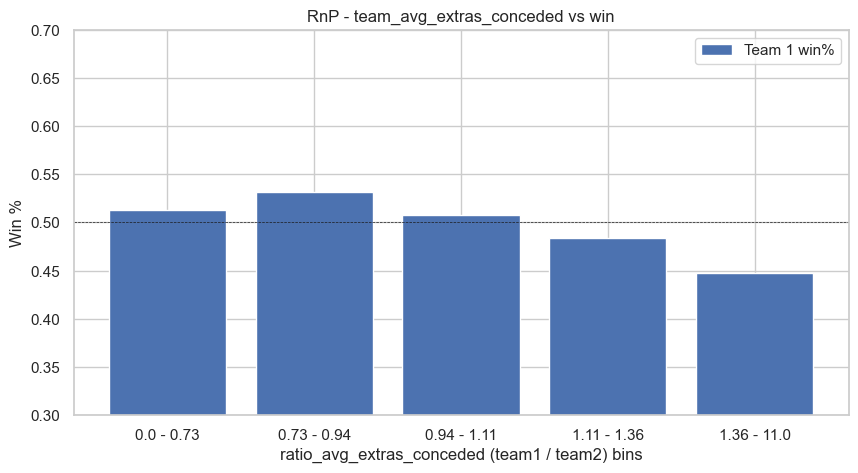

Correlation between team_avg_extras_conceded and winner_01 is: 0.011531867667539242


In [165]:
createRnP(train_data, 'team_avg_extras_conceded')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


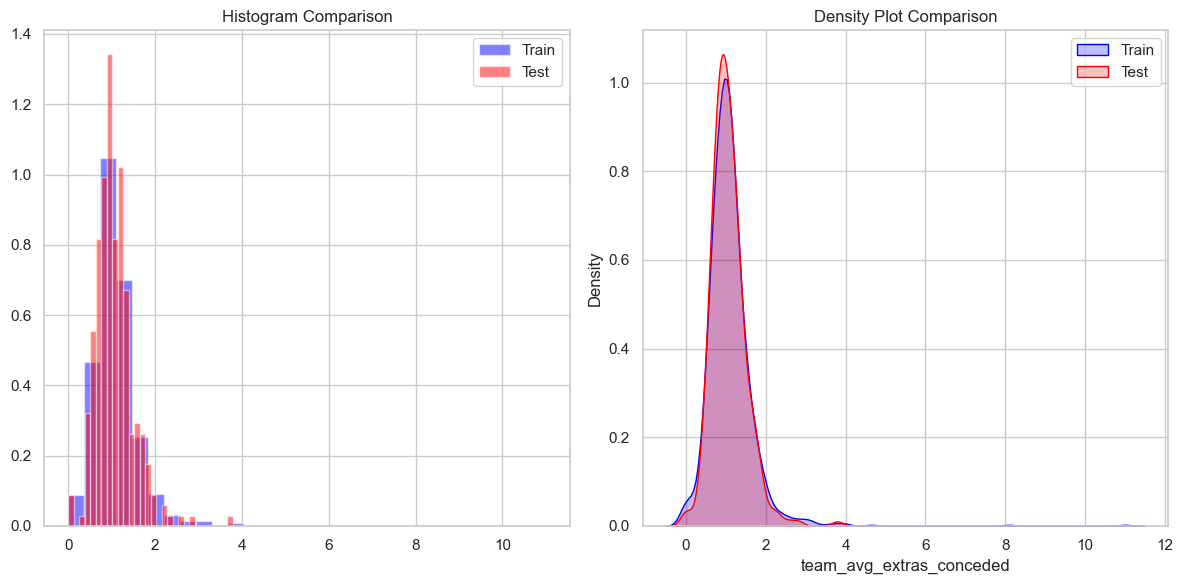

Kolmogorov-Smirnov test result: KS statistic = 0.0424, p-value = 0.8237

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.098039    1.057220
std       0.635198    0.436454
min       0.000000    0.000000
25%       0.775008    0.775116
50%       1.021090    1.006236
75%       1.276888    1.253942
max      11.000000    3.791667


In [166]:
check_distribution_match(train_data['team_avg_extras_conceded'], test_data['team_avg_extras_conceded'])

Feature 38

In [167]:
def avg_partnership_length(matches, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    total_partnership_runs = 0
    total_partnerships = 0

    for player_id in team_ids[:6]:  # Assuming top 4 are the main batsmen
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
        total_partnership_runs += recent_matches['runs'].sum()
        total_partnerships += recent_matches.shape[0]

    return total_partnership_runs / total_partnerships if total_partnerships > 0 else 0

In [168]:
train_data['team1_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length')

train_data = train_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])

test_data['team1_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length')

test_data = test_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])

slope: 0.58 / 0.45 =  1.29


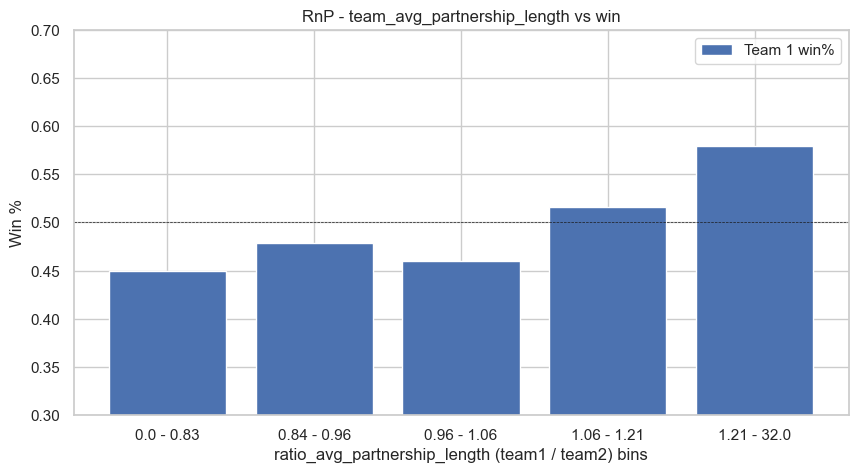

Correlation between team_avg_partnership_length and winner_01 is: -0.019392684698191665


In [169]:
createRnP(train_data, 'team_avg_partnership_length')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


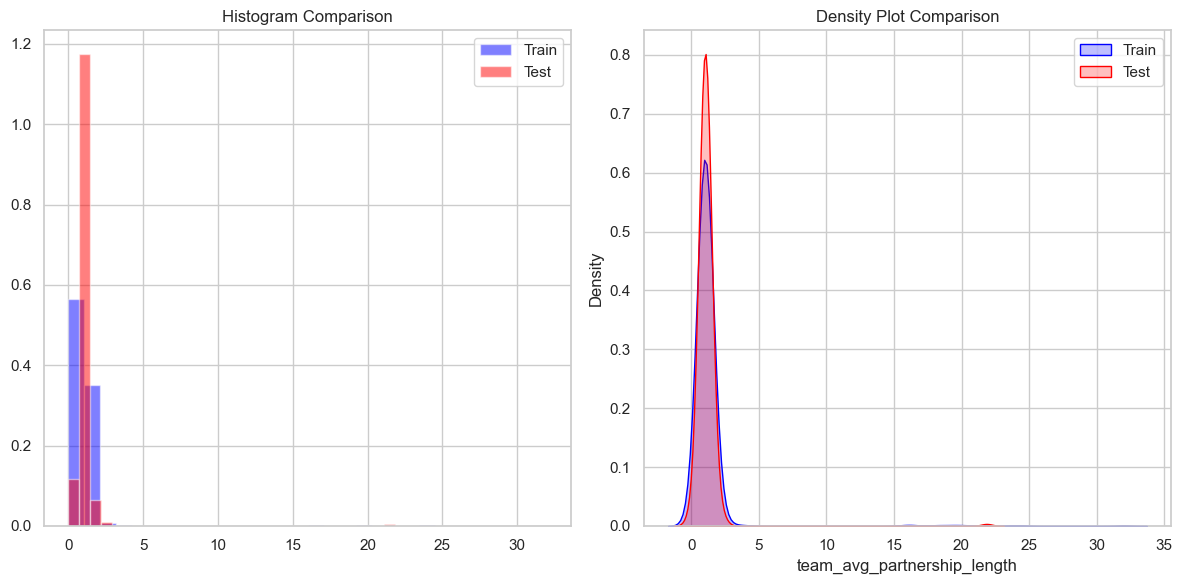

Kolmogorov-Smirnov test result: KS statistic = 0.0319, p-value = 0.9775

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.276472    1.107867
std       2.256012    1.299572
min       0.000000    0.000000
25%       0.869373    0.870976
50%       1.016158    1.027321
75%       1.169077    1.173778
max      32.000000   21.857143


In [170]:
check_distribution_match(train_data['team_avg_partnership_length'], test_data['team_avg_partnership_length'])

Feature 39

In [171]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

In [172]:
train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

slope: 0.59 / 0.43 =  1.38


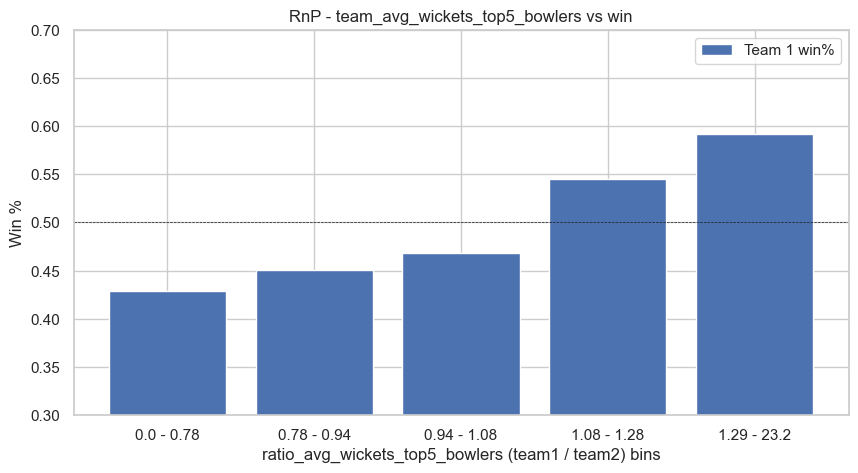

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.11325488452584982


In [173]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


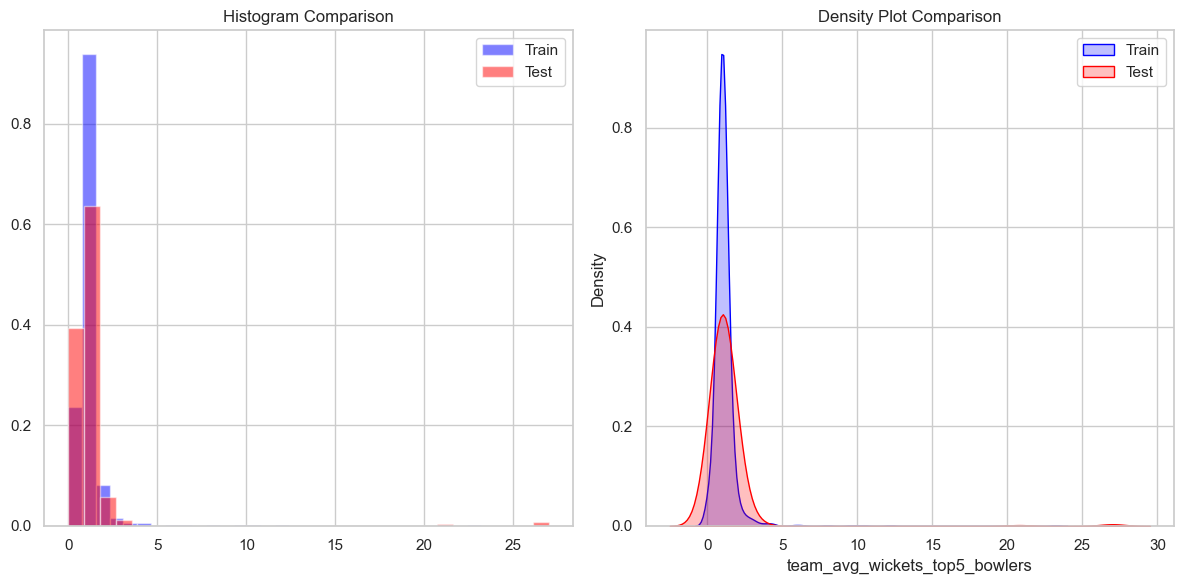

Kolmogorov-Smirnov test result: KS statistic = 0.0393, p-value = 0.8852

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.129825    1.336742
std       1.070175    2.560748
min       0.000000    0.000000
25%       0.824930    0.824781
50%       1.015625    1.032787
75%       1.216510    1.236695
max      23.200000   27.000000


In [174]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

Feature 40

In [175]:
def win_percentage_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')) & (matches['match_dt'] < date)]
    wins = fielding_first_matches[fielding_first_matches['winner_id'] == team_id].shape[0]
    total_matches = fielding_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

In [176]:
train_data['team1_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

train_data = train_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

test_data['team1_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

test_data = test_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

slope: 0.65 / 0.29 =  2.24


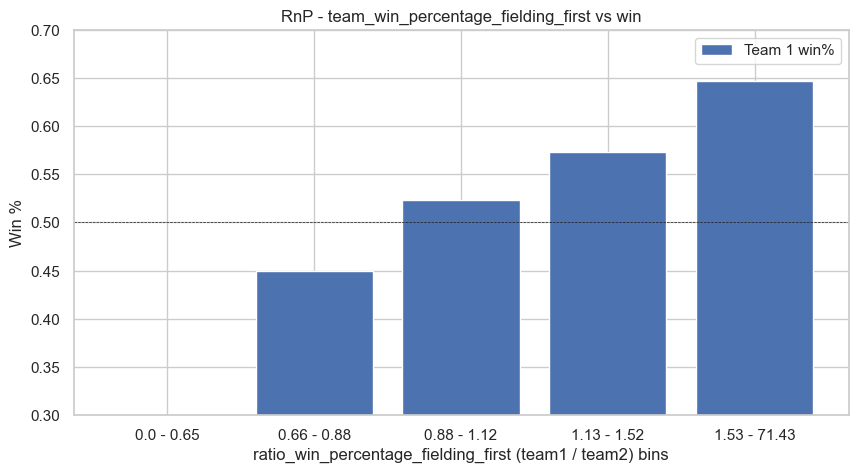

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.08742231380636549


In [177]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


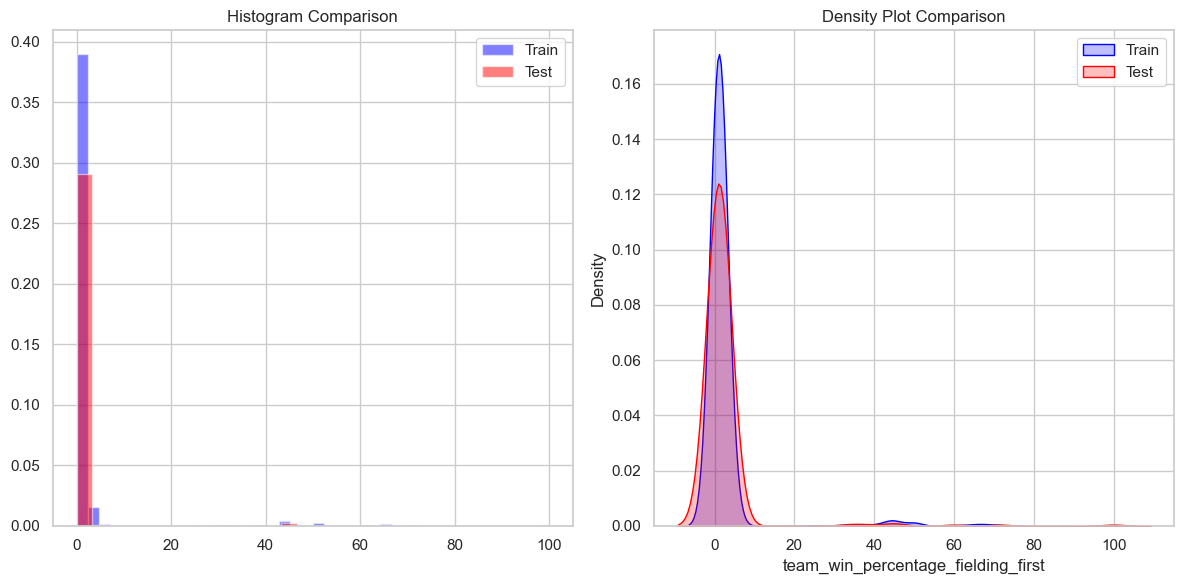

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.588952    2.489498
std       8.579653    9.424597
min       0.000000    0.000000
25%       0.715503    0.666667
50%       1.000000    1.000000
75%       1.370924    1.423962
max      71.428571  100.000000


In [178]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

Feature 41

In [179]:
def win_percentage_batting_first(matches, team_id, date):
    batting_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'bat')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'bat')) & (matches['match_dt'] < date)]
    wins = batting_first_matches[batting_first_matches['winner_id'] == team_id].shape[0]
    total_matches = batting_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

In [180]:
train_data['team1_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'team_win_percentage_batting_first')

train_data = train_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])

test_data['team1_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'team_win_percentage_batting_first')

test_data = test_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])

slope: 0.61 / 0.34 =  1.81


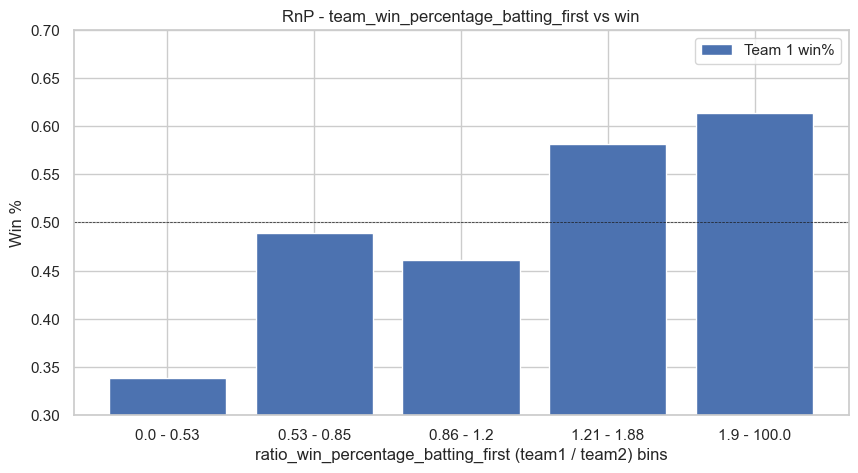

Correlation between team_win_percentage_batting_first and winner_01 is: -0.09853428612030792


In [181]:
createRnP(train_data, 'team_win_percentage_batting_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


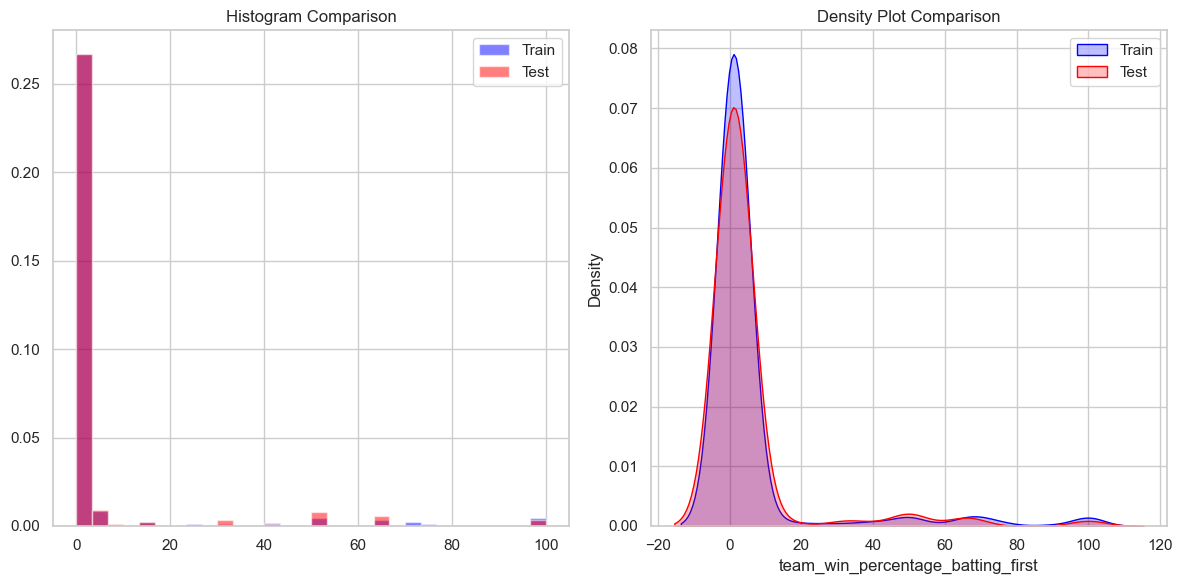

Kolmogorov-Smirnov test result: KS statistic = 0.0510, p-value = 0.6207

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.959401    5.299278
std      17.933664   15.812639
min       0.000000    0.000000
25%       0.604545    0.600000
50%       1.000000    1.000000
75%       1.609203    1.587500
max     100.000000  100.000000


In [182]:
check_distribution_match(train_data['team_win_percentage_batting_first'], test_data['team_win_percentage_batting_first'])

Feature 42

In [183]:
def avg_win_margin_runs(matches, team_id, date):
    win_by_runs_matches = matches[(matches['by'] == 'runs') & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)]
    total_margin = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id]['win amount'].sum()
    total_matches = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id].shape[0]
    return total_margin / total_matches if total_matches > 0 else 0

In [184]:
train_data['team1_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

train_data = train_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

test_data['team1_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

test_data = test_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

slope: 0.53 / 0.44 =  1.2


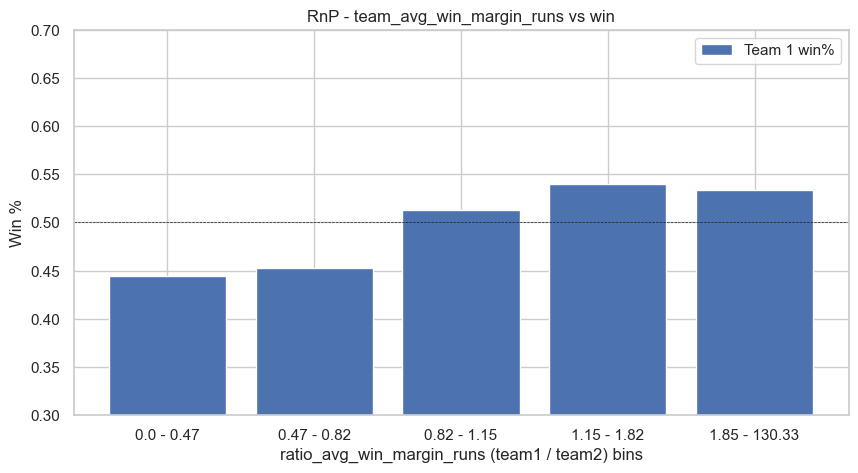

Correlation between team_avg_win_margin_runs and winner_01 is: -0.03073344181156112


In [185]:
createRnP(train_data, 'team_avg_win_margin_runs')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


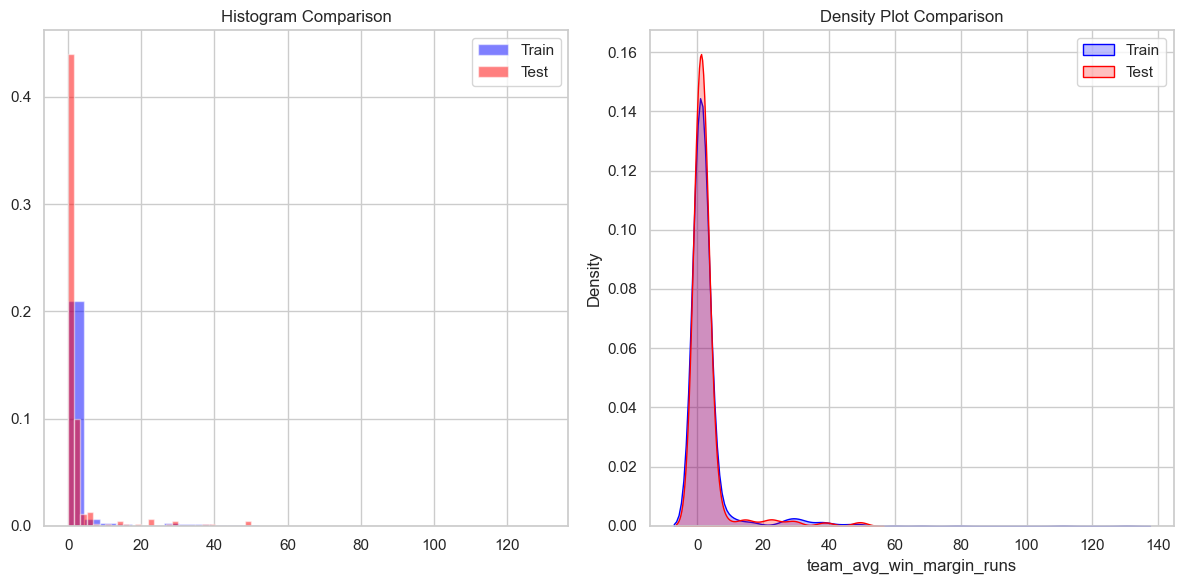

Kolmogorov-Smirnov test result: KS statistic = 0.0662, p-value = 0.2972

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.146298    2.660165
std       9.426177    6.618963
min       0.000000    0.000000
25%       0.589105    0.621948
50%       0.993953    1.024614
75%       1.597176    1.749286
max     130.333333   50.076923


In [186]:
check_distribution_match(train_data['team_avg_win_margin_runs'], test_data['team_avg_win_margin_runs'])

# Priyanshu

Feature 43

In [187]:
def winpLastn_venue(team_id, date, ground_id,n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['ground_id']==ground_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [188]:
train_data['team1_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data['team2_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

train_data = train_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

test_data['team1_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data['team2_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

test_data = test_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

100%|██████████| 271/271 [00:00<00:00, 548.78it/s]


slope: 0.56 / 0.4 =  1.42


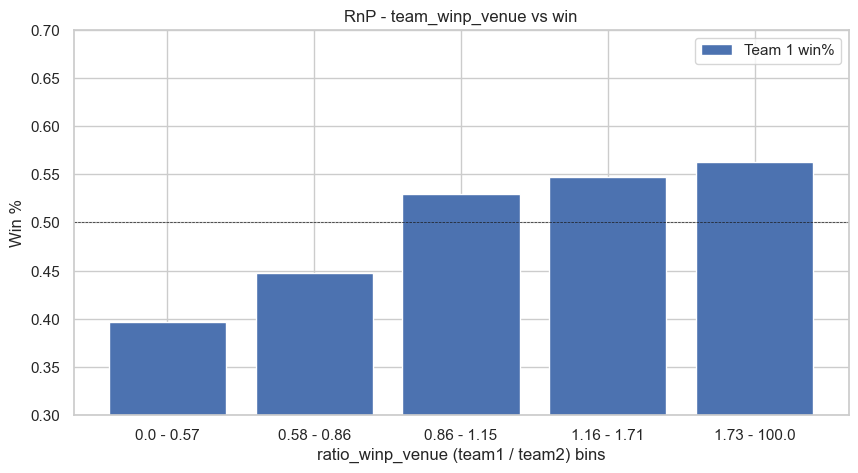

Correlation between team_winp_venue and winner_01 is: -0.05312515097696646


In [189]:
createRnP(train_data, 'team_winp_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


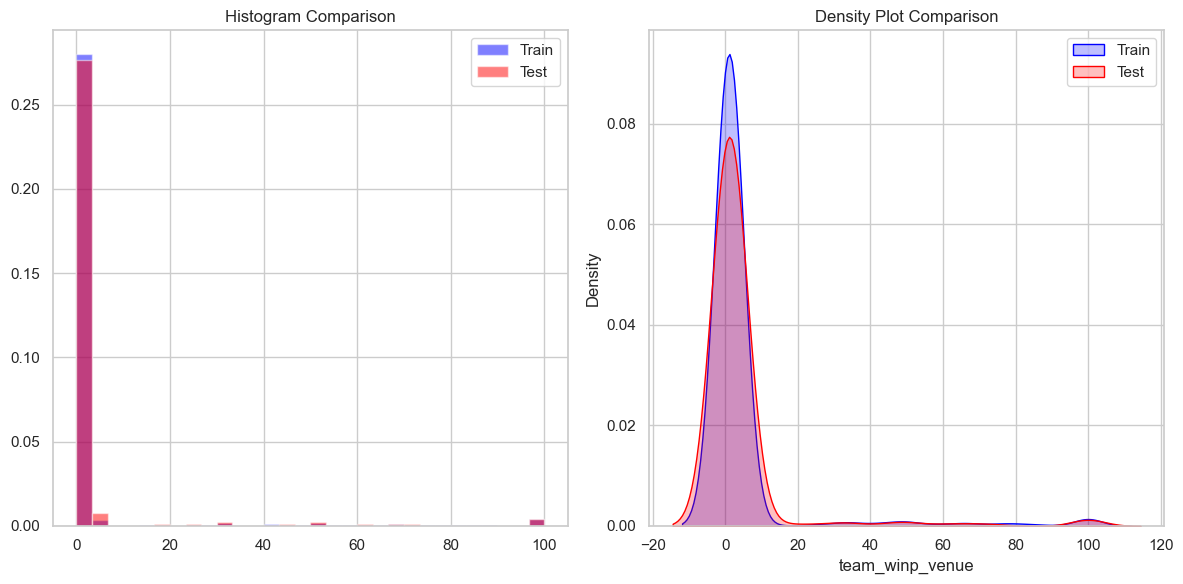

Kolmogorov-Smirnov test result: KS statistic = 0.0630, p-value = 0.3556

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      4.492258    4.253280
std      15.602713   14.798107
min       0.000000    0.000000
25%       0.650037    0.687004
50%       1.000000    1.047612
75%       1.500150    1.658566
max     100.000000  100.000000


In [190]:
check_distribution_match(train_data['team_winp_venue'], test_data['team_winp_venue'])

Feature 44

In [191]:
def assign_toss_winner_flag(row):
    if row['team1'] == row['toss winner']:
        return row['team1_id']
    elif row['team2'] == row['toss winner']:
        return row['team2_id']
train_data['toss_winner_id'] = train_data.apply(assign_toss_winner_flag, axis=1)
match_lvl_data['toss_winner_id'] = match_lvl_data.apply(assign_toss_winner_flag, axis=1)
test_data['toss_winner_id']= test_data.apply(assign_toss_winner_flag, axis=1)

def assign_bat(row):
    if (row['toss_winner_id'] == row['team1_id']) & (row['toss decision']=='bat'):
        return row['team1_id']
    if (row['toss_winner_id'] != row['team1_id']) & (row['toss decision']=='field'):
        return row['team1_id']
    else:
        return row['team2_id']
train_data['bat_id'] = train_data.apply(assign_bat, axis=1) 
match_lvl_data['bat_id'] = match_lvl_data.apply(assign_bat, axis=1)
test_data['bat_id'] = test_data.apply(assign_bat, axis=1)

In [192]:
def winpLastn_batndchase(team_id, bat_id,date,n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    if(bat_id==team_id):
        df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) )]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
        win_count = df_rel[(df_rel['winner_id' ]==team_id )& (df_rel['bat_id']==team_id)].shape[0] # count number of rows having winner as the input team
        if win_count == 0:
          return 0
        return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points
    else:
       df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
       
       win_count = df_rel[(df_rel['winner_id']==team_id) & (df_rel['bat_id']!=team_id)].shape[0] # count number of rows having winner as the input team
       if win_count == 0:
          return 0
       return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [193]:
train_data['team1_winp_bat\chase'] = train_data.progress_apply(lambda x: \
                                  winpLastn_batndchase(x['team1_id'], x['bat_id'], x['match_dt'], 15), axis=1)
train_data['team2_winp_bat\chase'] = train_data.progress_apply(lambda x: \
                                  winpLastn_batndchase(x['team2_id'], x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_bat\chase', 'team2_winp_bat\chase', 'team_winp_bat\chase')

train_data = train_data.drop(columns=['team1_winp_bat\chase', 'team2_winp_bat\chase'])

test_data['team1_winp_bat\chase'] = test_data.progress_apply(lambda x: \
                                    winpLastn_batndchase(x['team1_id'], x['bat_id'], x['match_dt'], 15), axis=1)
test_data['team2_winp_bat\chase'] = test_data.progress_apply(lambda x: \
                                    winpLastn_batndchase(x['team2_id'], x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_bat\chase', 'team2_winp_bat\chase', 'team_winp_bat\chase')

test_data = test_data.drop(columns=['team1_winp_bat\chase', 'team2_winp_bat\chase'])

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequenc

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/1749058175.py:1: SyntaxWarning: invalid escape sequence '\c'
  createRnP(train_data, 'team_winp_bat\chase')


slope: 0.55 / 0.42 =  1.31


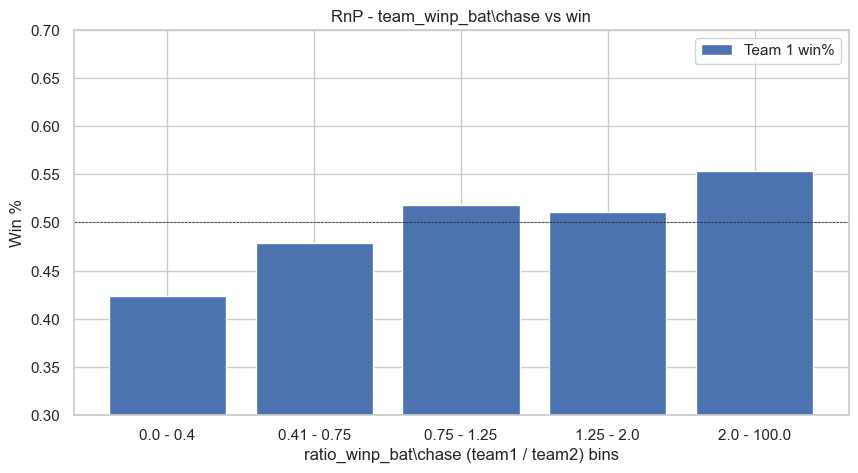

Correlation between team_winp_bat\chase and winner_01 is: -0.05076392881737684


In [194]:
createRnP(train_data, 'team_winp_bat\chase')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/1808093529.py:1: SyntaxWarning: invalid escape sequence '\c'
  check_distribution_match(train_data['team_winp_bat\chase'], test_data['team_winp_bat\chase'])
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/1808093529.py:1: SyntaxWarning: invalid escape sequence '\c'
  check_distribution_match(train_data['team_winp_bat\chase'], test_data['team_winp_bat\chase'])
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/pyth

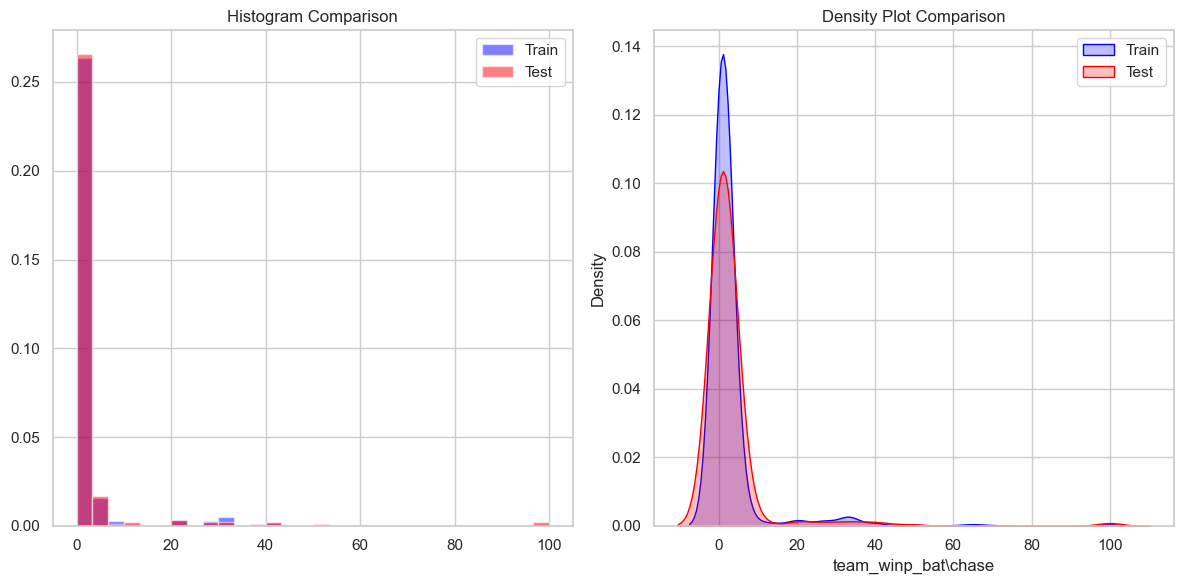

Kolmogorov-Smirnov test result: KS statistic = 0.0424, p-value = 0.8239

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.385968    3.306445
std       9.859185   10.612001
min       0.000000    0.000000
25%       0.500000    0.527054
50%       1.000000    1.000000
75%       1.783110    1.998501
max     100.000000  100.000000


In [195]:
check_distribution_match(train_data['team_winp_bat\chase'], test_data['team_winp_bat\chase'])

Feature 45

In [196]:
def teamAvgRunsLastn_innings1(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning1_runs'].mean()

In [197]:
train_data['runs_team1_1st_inning']= train_data.progress_apply(lambda x: \
                                 teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['runs_team2_1st_inning']= train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

train_data = train_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

test_data['runs_team1_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['runs_team2_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

test_data = test_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

100%|██████████| 271/271 [00:00<00:00, 1503.09it/s]


slope: 0.55 / 0.44 =  1.25


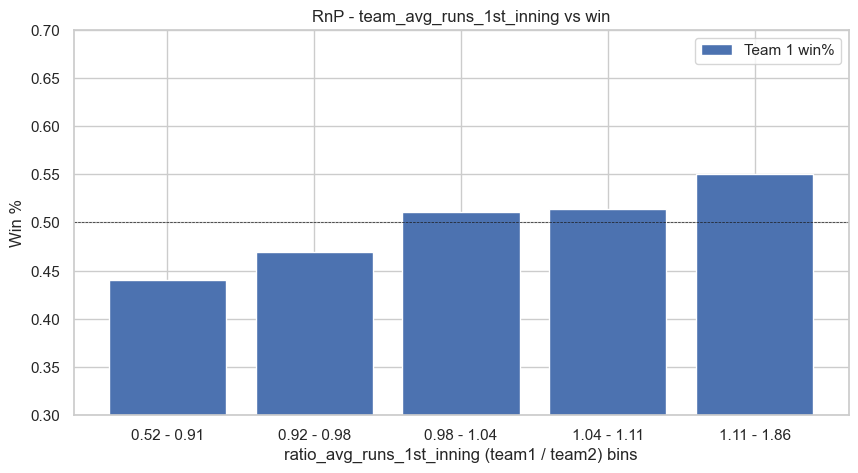

Correlation between team_avg_runs_1st_inning and winner_01 is: -0.08210253516941837


In [198]:
createRnP(train_data, 'team_avg_runs_1st_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


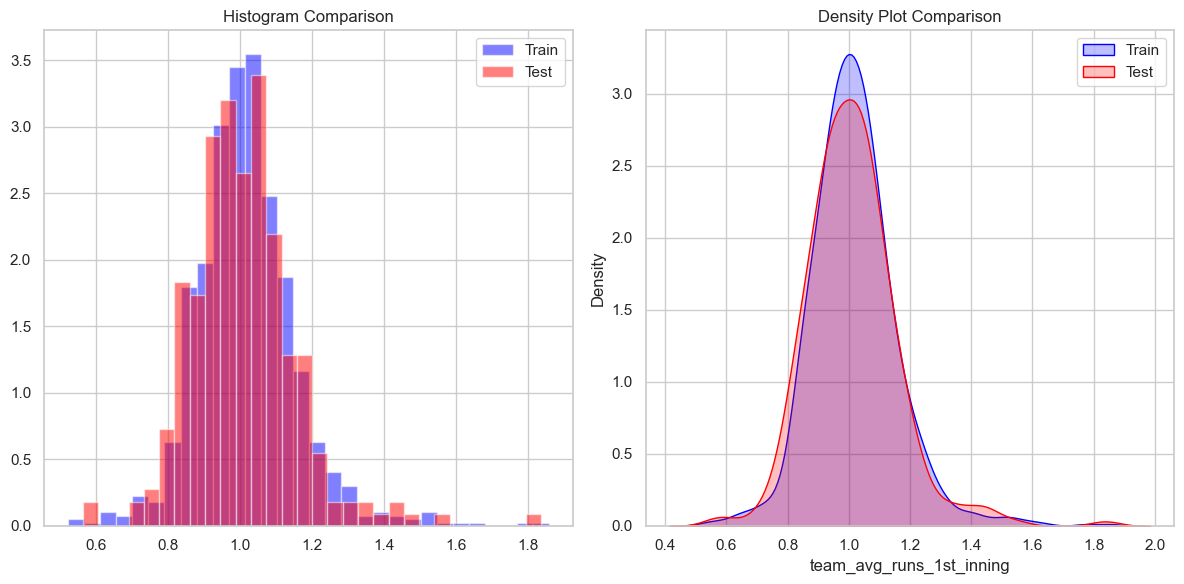

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.016814    1.009674
std       0.141082    0.147750
min       0.523536    0.563282
25%       0.931371    0.919311
50%       1.007966    1.001393
75%       1.087347    1.082585
max       1.858280    1.838217


In [199]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

Feature 46

In [200]:
def teamAvgRunsLastn_innings2(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']!=team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning2_runs'].mean()

In [201]:
train_data['runs_team1_2nd_inning']= train_data.progress_apply(lambda x: \
                                 teamAvgRunsLastn_innings2(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['runs_team2_2nd_inning']= train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn_innings2(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'runs_team1_2nd_inning', 'runs_team2_2nd_inning', 'team_avg_runs_2nd_inning')

train_data = train_data.drop(columns=['runs_team1_2nd_inning', 'runs_team2_2nd_inning'])

test_data['runs_team1_2nd_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings2(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['runs_team2_2nd_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings2(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'runs_team1_2nd_inning', 'runs_team2_2nd_inning', 'team_avg_runs_2nd_inning')

test_data = test_data.drop(columns=['runs_team1_2nd_inning', 'runs_team2_2nd_inning'])

100%|██████████| 271/271 [00:00<00:00, 627.90it/s]


slope: 0.47 / 0.46 =  1.01


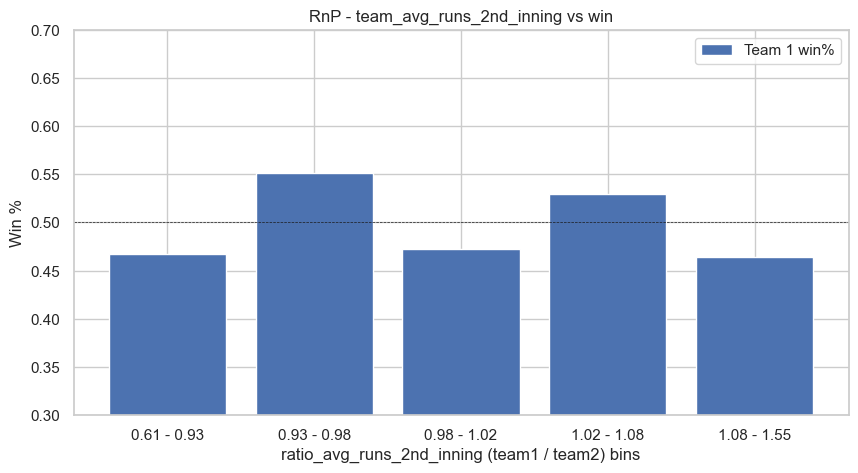

Correlation between team_avg_runs_2nd_inning and winner_01 is: -0.04036824173616819


In [202]:
createRnP(train_data, 'team_avg_runs_2nd_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


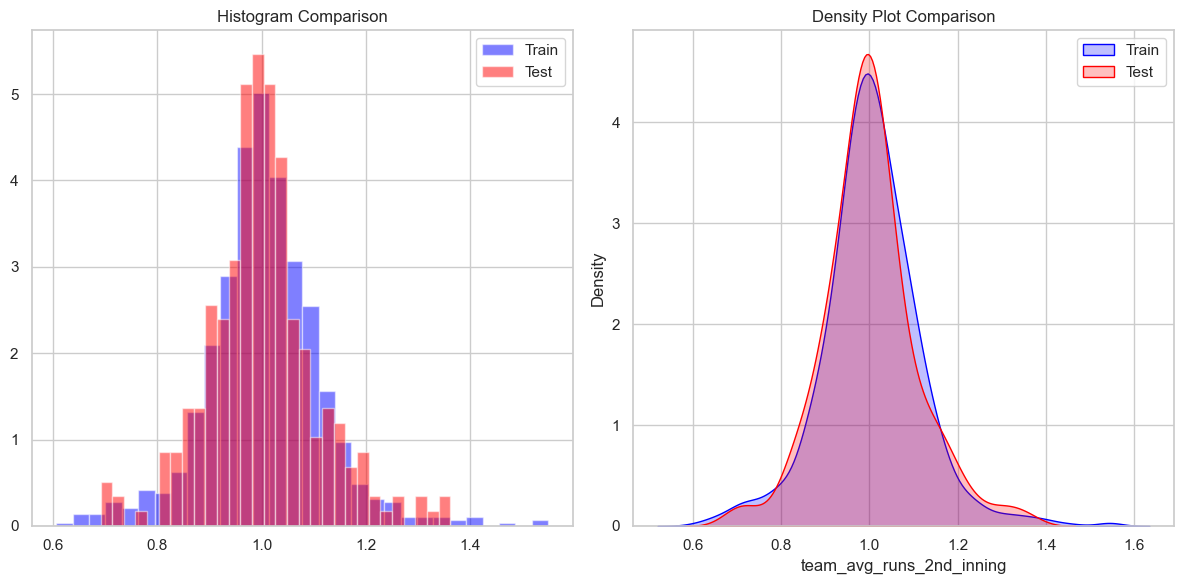

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   913.000000  262.000000
mean      1.004440    1.001041
std       0.111931    0.106771
min       0.606061    0.690860
25%       0.948169    0.943886
50%       1.002294    0.995004
75%       1.064594    1.048700
max       1.549114    1.361465


In [203]:
check_distribution_match(train_data['team_avg_runs_2nd_inning'], test_data['team_avg_runs_2nd_inning'])

Feature 47

In [204]:
def teamAvgwicketsLastn_innings1(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']!=team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning1_wickets'].mean()

In [205]:
train_data['wickets_team2_inning1']= train_data.progress_apply(lambda x: \
                                 teamAvgwicketsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['wickets_team1_inning1']= train_data.progress_apply(lambda x: \
                                 teamAvgwicketsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'wickets_team1_inning1', 'wickets_team2_inning1', 'team_avg_wickets_inning1')

train_data = train_data.drop(columns=['wickets_team1_inning1', 'wickets_team2_inning1'])

test_data['wickets_team2_inning1']= test_data.progress_apply(lambda x: \
                                    teamAvgwicketsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['wickets_team1_inning1']= test_data.progress_apply(lambda x: \
                                    teamAvgwicketsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'wickets_team1_inning1', 'wickets_team2_inning1', 'team_avg_wickets_inning1')

test_data = test_data.drop(columns=['wickets_team1_inning1', 'wickets_team2_inning1'])

100%|██████████| 271/271 [00:00<00:00, 1373.39it/s]


slope: 0.58 / 0.48 =  1.23


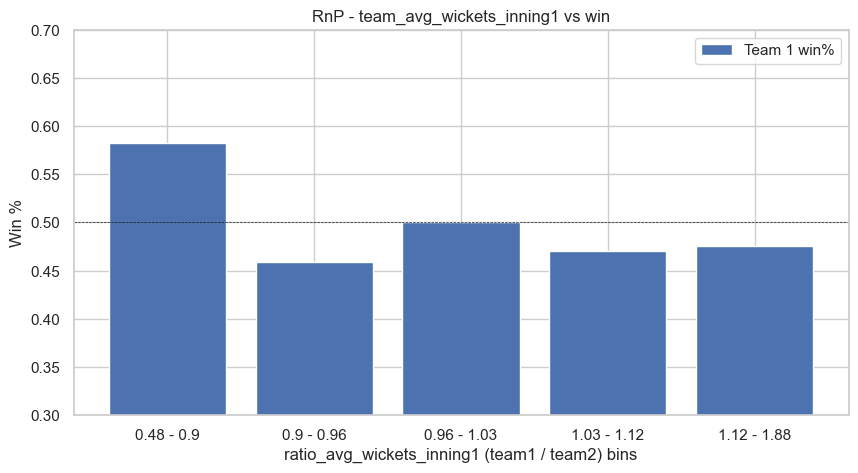

Correlation between team_avg_wickets_inning1 and winner_01 is: 0.03056972094802438


In [206]:
createRnP(train_data, 'team_avg_wickets_inning1')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


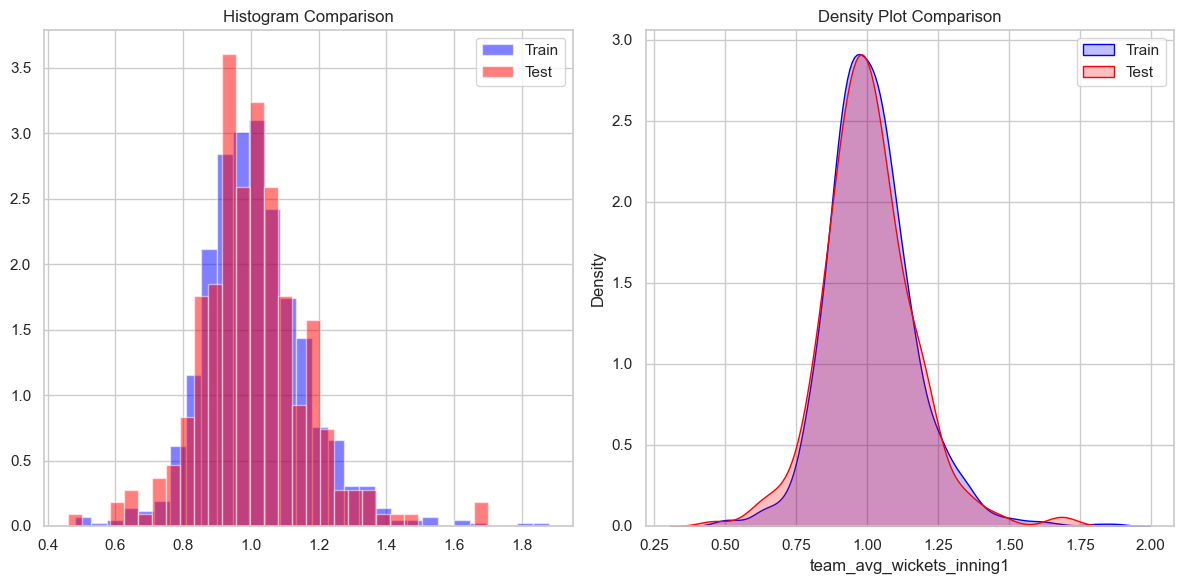

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   913.000000  262.000000
mean      1.012731    1.005149
std       0.153654    0.158483
min       0.481481    0.461538
25%       0.918182    0.916881
50%       1.000000    0.998097
75%       1.092593    1.085773
max       1.879121    1.700000


In [207]:
check_distribution_match(train_data['team_avg_wickets_inning1'], test_data['team_avg_wickets_inning1'])

Feature 48

In [208]:
def teamAvgwicketsLastn_innings2(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning2_wickets'].mean()

In [209]:
train_data['wickets_team1_inning2']= train_data.progress_apply(lambda x: \
                                 teamAvgwicketsLastn_innings2(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['wickets_team2_inning2']= train_data.progress_apply(lambda x: \
                                 teamAvgwicketsLastn_innings2(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'wickets_team1_inning2', 'wickets_team2_inning2', 'team_avg_wickets_inning2')

train_data = train_data.drop(columns=['wickets_team1_inning2', 'wickets_team2_inning2'])

test_data['wickets_team1_inning2']= test_data.progress_apply(lambda x: \
                                    teamAvgwicketsLastn_innings2(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['wickets_team2_inning2']= test_data.progress_apply(lambda x: \
                                    teamAvgwicketsLastn_innings2(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'wickets_team1_inning2', 'wickets_team2_inning2', 'team_avg_wickets_inning2')

test_data = test_data.drop(columns=['wickets_team1_inning2', 'wickets_team2_inning2'])

100%|██████████| 271/271 [00:00<00:00, 1029.76it/s]


slope: 0.57 / 0.38 =  1.52


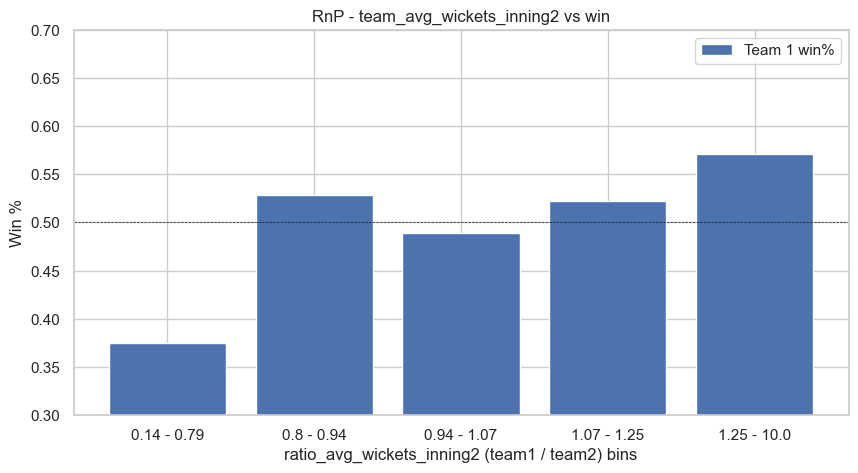

Correlation between team_avg_wickets_inning2 and winner_01 is: -0.04562933403266725


In [210]:
createRnP(train_data, 'team_avg_wickets_inning2')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


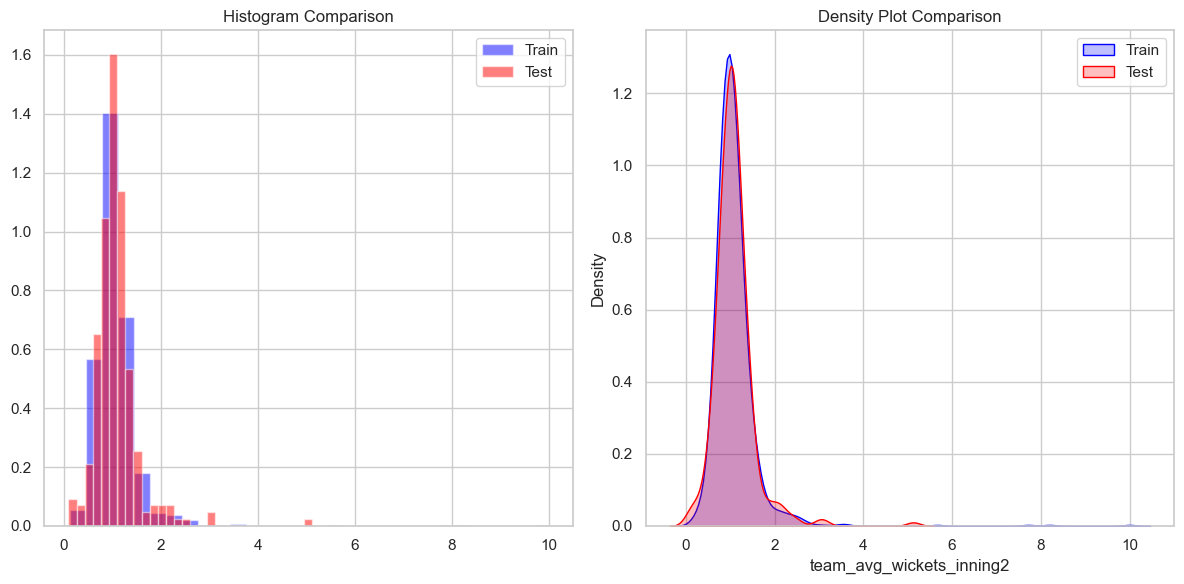

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.087465    1.081454
std       0.596973    0.468516
min       0.140845    0.100000
25%       0.833333    0.837500
50%       1.000000    1.031042
75%       1.191071    1.230769
max      10.000000    5.125000


In [211]:
check_distribution_match(train_data['team_avg_wickets_inning2'], test_data['team_avg_wickets_inning2'])

Feature 49

In [212]:
def SRLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['strike_rate']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [213]:
train_data['team1_SR'] = train_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_SR'] = train_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_SR', 'team2_SR', 'team_SR')

train_data = train_data.drop(columns=['team1_SR', 'team2_SR'])

test_data['team1_SR'] = test_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_SR'] = test_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_SR', 'team2_SR', 'team_SR')

test_data = test_data.drop(columns=['team1_SR', 'team2_SR'])

 60%|██████    | 569/948 [00:10<00:06, 59.81it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
 35%|███▍      | 329/948 [00:05<00:10, 57.92it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
 89%|████████▉ | 241/271 [00:04<00:00, 52.16it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_36100/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
100%|██████████| 271/271 [00:04<00:00, 59.17it/s]


slope: 0.54 / 0.37 =  1.48


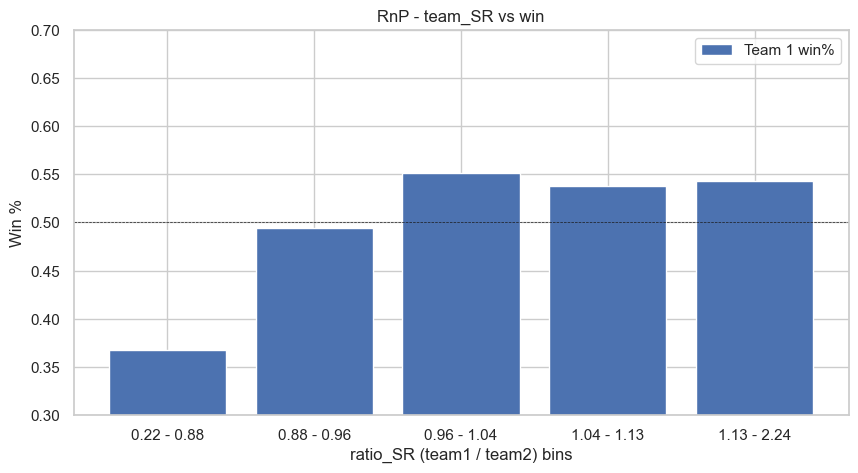

Correlation between team_SR and winner_01 is: -0.10303322140127094


In [214]:
createRnP(train_data, 'team_SR')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


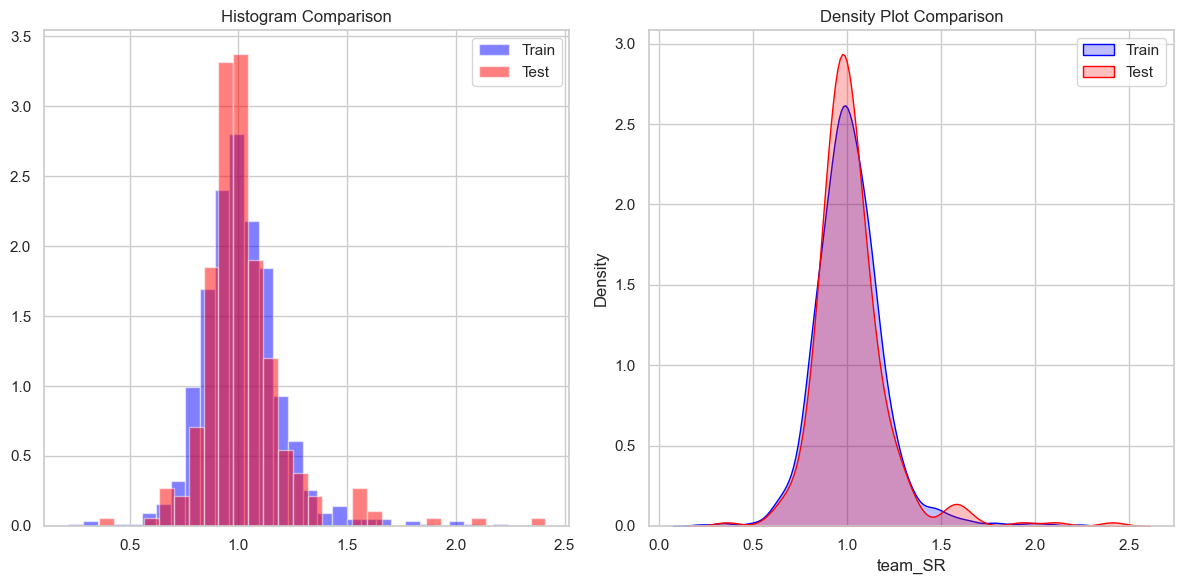

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   928.000000  269.000000
mean      1.013948    1.021168
std       0.186654    0.203674
min       0.217916    0.361178
25%       0.908766    0.918584
50%       1.000700    0.986027
75%       1.106565    1.083092
max       2.238495    2.411770


In [215]:
check_distribution_match(train_data['team_SR'], test_data['team_SR'])

Feature 50

In [216]:
def RunsLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['runs']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [217]:
train_data['team1_avg'] = train_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg'] = train_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg', 'team2_avg', 'team_avg')

train_data = train_data.drop(columns=['team1_avg', 'team2_avg'])

test_data['team1_avg'] = test_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg'] = test_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg', 'team2_avg', 'team_avg')

test_data = test_data.drop(columns=['team1_avg', 'team2_avg'])

100%|██████████| 271/271 [00:04<00:00, 60.42it/s]


slope: 0.58 / 0.45 =  1.28


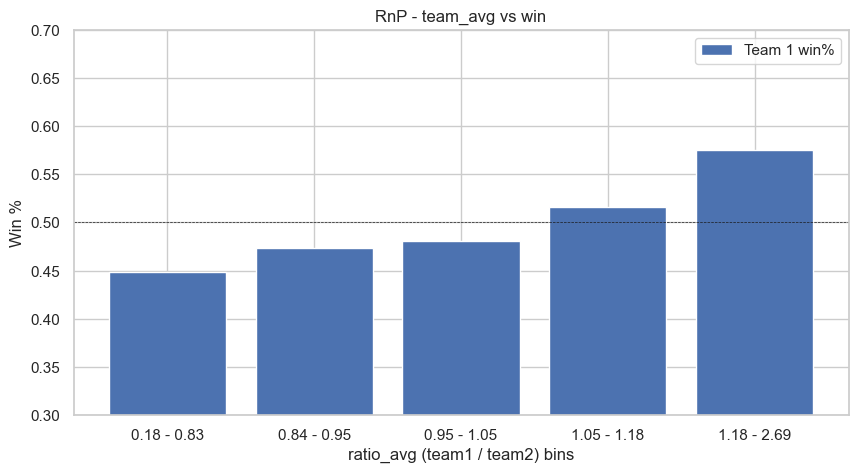

Correlation between team_avg and winner_01 is: -0.08523384183174122


In [218]:
createRnP(train_data, 'team_avg')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


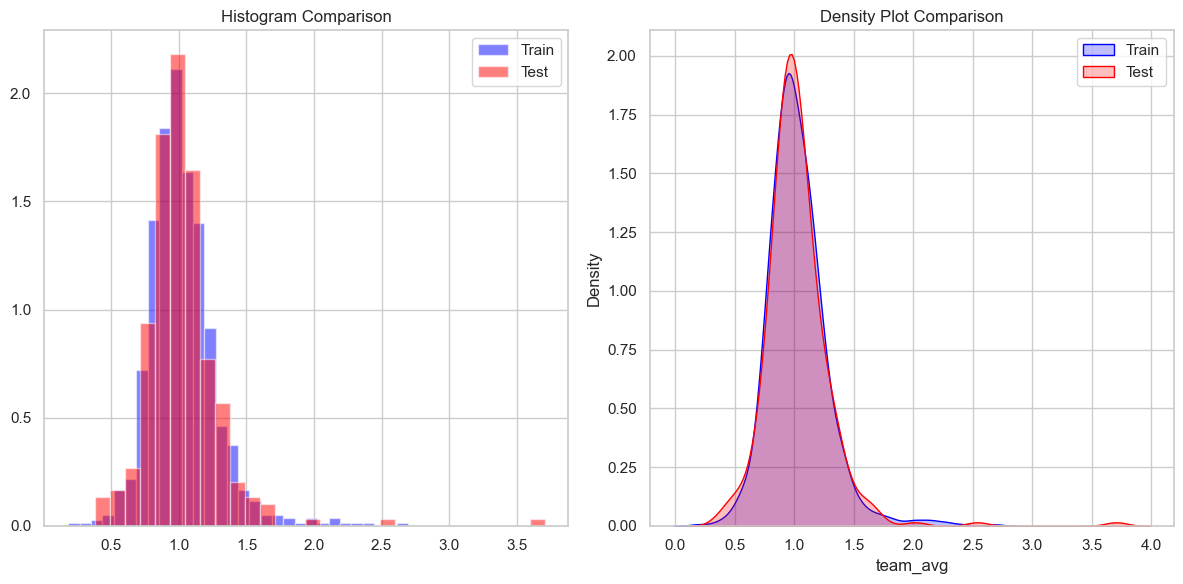

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   928.000000  269.000000
mean      1.025177    1.025734
std       0.254277    0.291027
min       0.181745    0.381546
25%       0.872787    0.898367
50%       0.991571    0.977446
75%       1.144019    1.114197
max       2.694952    3.705109


In [219]:
check_distribution_match(train_data['team_avg'], test_data['team_avg'])

Feature 51

In [220]:
#
def WicketsLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['wicket_count']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [221]:
train_data['team1_avg_wkt'] = train_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wkt'] = train_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wkt', 'team2_avg_wkt', 'team_avg_wkt')

train_data = train_data.drop(columns=['team1_avg_wkt', 'team2_avg_wkt'])

test_data['team1_avg_wkt'] = test_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_wkt'] = test_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wkt', 'team2_avg_wkt', 'team_avg_wkt')

test_data = test_data.drop(columns=['team1_avg_wkt', 'team2_avg_wkt'])

100%|██████████| 271/271 [00:03<00:00, 75.56it/s]


slope: 0.52 / 0.48 =  1.09


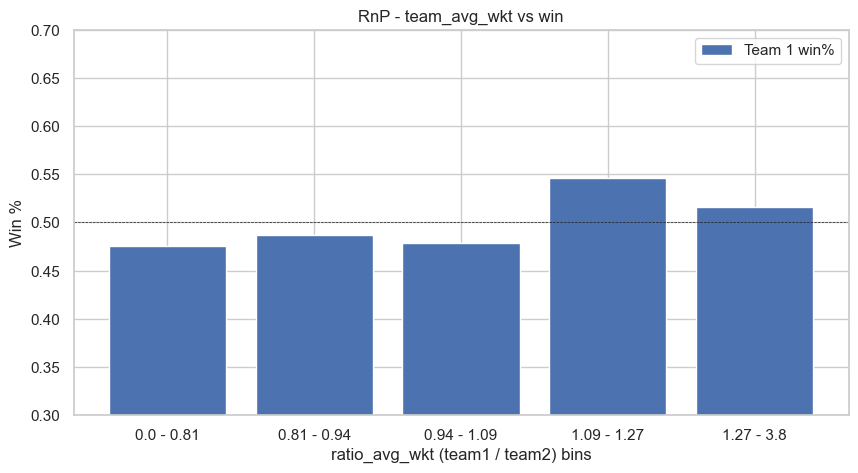

Correlation between team_avg_wkt and winner_01 is: -0.0601197082612971


In [222]:
createRnP(train_data, 'team_avg_wkt')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


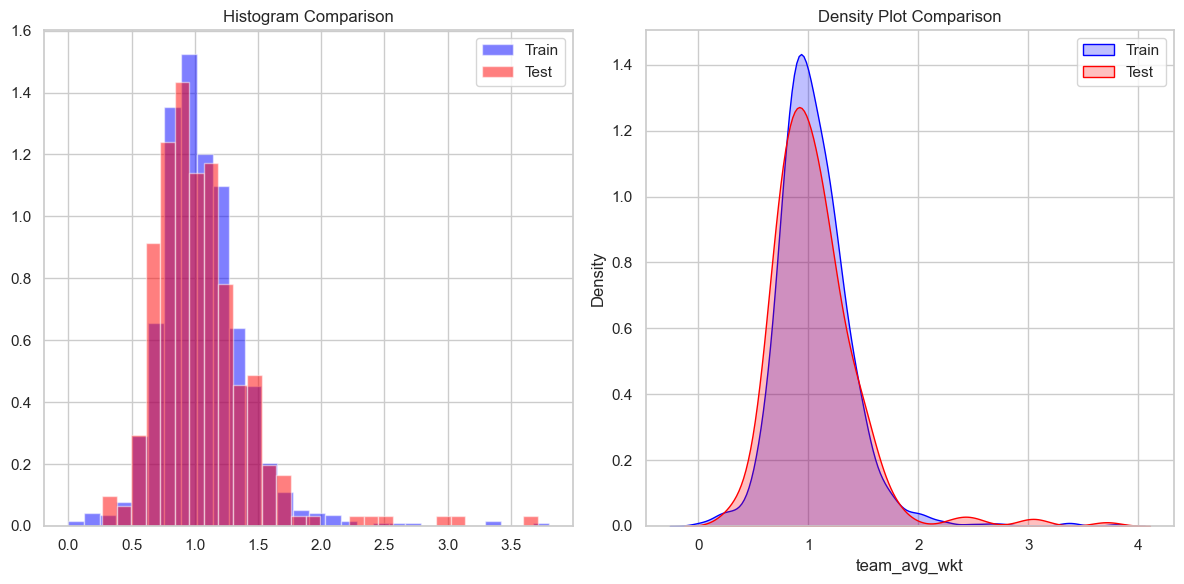

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.053838    1.051226
std       0.341371    0.401116
min       0.000000    0.267846
25%       0.850109    0.805248
50%       1.010415    0.981622
75%       1.217520    1.213815
max       3.800000    3.713542


In [223]:
check_distribution_match(train_data['team_avg_wkt'], test_data['team_avg_wkt'])

Feature 52

In [224]:
def EcoLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['economy']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [225]:
train_data['team1_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

train_data = train_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

test_data['team1_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

test_data = test_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

100%|██████████| 271/271 [00:04<00:00, 67.28it/s]


slope: 0.57 / 0.45 =  1.27


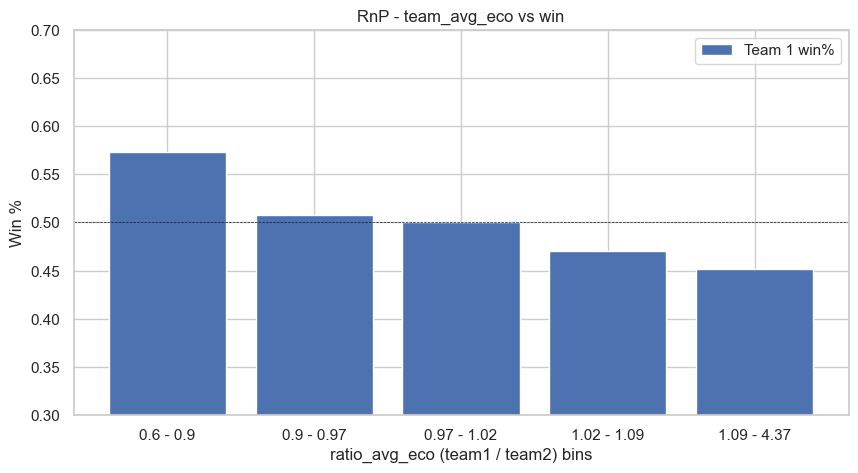

Correlation between team_avg_eco and winner_01 is: 0.029889408874522787


In [226]:
createRnP(train_data, 'team_avg_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


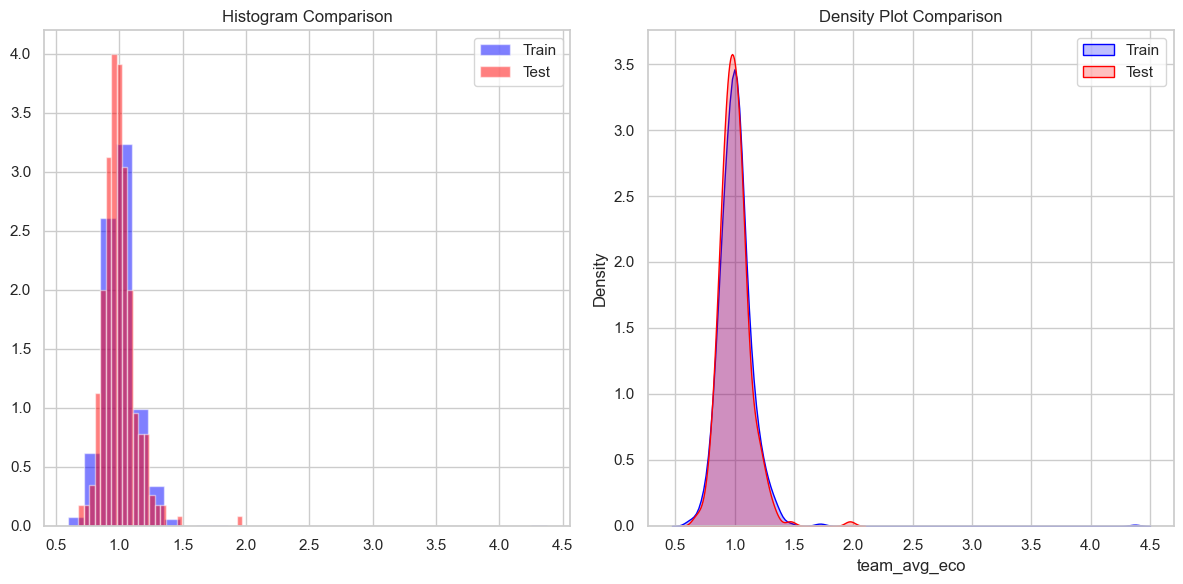

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.006520    0.997867
std       0.168425    0.130098
min       0.598698    0.676974
25%       0.921918    0.920045
50%       0.997530    0.985647
75%       1.065874    1.052922
max       4.371515    1.969705


In [227]:
check_distribution_match(train_data['team_avg_eco'], test_data['team_avg_eco'])